In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pickle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from IPython.display import display

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
#from imutils import paths #might need to install imutils package

#import shutil
#from pycocotools.coco import COCO
#from pathlib import Path
#from PIL import Image

#import torch
#import torchvision
#from torch.utils.data import Dataset
#from torchvision.transforms import ToTensor
#from torchvision.io import read_image    #could not import because running older version of torchvision in learn env

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Pulling data into Dataframes

In [2]:
# setting data paths and making list of each file type

path = '../Data/data/'

image_list = [x for x in os.listdir(path) if x.endswith('.jpeg')]

label_list = [x for x in os.listdir(path) if x.endswith('.txt')]

image_list.sort()
label_list.sort()

In [3]:
# checking image and label lists
image_list_check = [x[:-5] for x in image_list]
label_list_check = [x[:-4] for x in label_list]
                    
image_list_check == label_list_check

True

In [4]:
# creating initial dataframe from txt files (YOLO format)
df = pd.DataFrame(columns=['image_file', 'class', 'x_center', 'y_center', 'width', 'height'])

df['image_file'] = image_list

i=0
for file in df['image_file']:
    label = open(path + file[:-5] +'.txt', 'r').readline().split()
    df.loc[i, 'class'] = int(label[0])
    df.loc[i, 'x_center'] = float(label[1])
    df.loc[i, 'y_center'] = float(label[2])
    df.loc[i, 'width'] = float(label[3])
    df.loc[i, 'height'] = float(label[4])
    i +=1
    
df.head()

,image_file,class,x_center,y_center,width,height
0,agri_0_1009.jpeg,1,0.608398,0.498047,0.541016,0.53125
1,agri_0_1017.jpeg,1,0.496094,0.384766,0.960938,0.753906
2,agri_0_1018.jpeg,1,0.445312,0.483398,0.808594,0.634766
3,agri_0_1020.jpeg,1,0.494141,0.350586,0.730469,0.611328
4,agri_0_1024.jpeg,1,0.601562,0.448242,0.570312,0.595703


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_file  1300 non-null   object
 1   class       1300 non-null   object
 2   x_center    1300 non-null   object
 3   y_center    1300 non-null   object
 4   width       1300 non-null   object
 5   height      1300 non-null   object
dtypes: object(6)
memory usage: 61.1+ KB


In [6]:
# creating dataframe in Pascal VOC format with bounding boxes scaled (from originl data)
df_pas_voc = pd.DataFrame(columns = ['filename', 'width', 'height', 'x_min', 'y_min', 'x_max', 'y_max', 'class'])

df_pas_voc['filename'] = df['image_file']
df_pas_voc['class'] = df['class']
df_pas_voc['width'] = 512
df_pas_voc['height'] = 512

for i in range(len(df_pas_voc)):
    df_pas_voc.loc[i, 'x_min'] = df.loc[i, 'x_center'] - (df.loc[i, 'width']/2)
    df_pas_voc.loc[i, 'y_min'] = df.loc[i, 'y_center'] - (df.loc[i, 'height']/2)
    df_pas_voc.loc[i, 'x_max'] = df.loc[i, 'x_center'] + (df.loc[i, 'width']/2)
    df_pas_voc.loc[i, 'y_max'] = df.loc[i, 'y_center'] + (df.loc[i, 'height']/2)

df_pas_voc.head()

,filename,width,height,x_min,y_min,x_max,y_max,class
0,agri_0_1009.jpeg,512,512,0.33789,0.232422,0.878906,0.763672,1
1,agri_0_1017.jpeg,512,512,0.015625,0.007813,0.976563,0.761719,1
2,agri_0_1018.jpeg,512,512,0.041015,0.166015,0.849609,0.800781,1
3,agri_0_1020.jpeg,512,512,0.128906,0.044922,0.859376,0.65625,1
4,agri_0_1024.jpeg,512,512,0.316406,0.15039,0.886718,0.746093,1


In [7]:
# creating dataframe in proper Pascal VOC format with bounding boxes not scaled
df_pascal_voc = pd.DataFrame(columns = ['filename', 'width', 'height', 'x_min', 'y_min', 'x_max', 'y_max', 'class'])

df_pascal_voc['filename'] = df['image_file']
df_pascal_voc['class'] = df['class']
df_pascal_voc['width'] = 512
df_pascal_voc['height'] = 512

for i in range(len(df_pascal_voc)):
    df_pascal_voc.loc[i, 'x_min'] = round((df.loc[i, 'x_center'] - (df.loc[i, 'width']/2))*512)
    df_pascal_voc.loc[i, 'y_min'] = round((df.loc[i, 'y_center'] - (df.loc[i, 'height']/2))*512)
    df_pascal_voc.loc[i, 'x_max'] = round((df.loc[i, 'x_center'] + (df.loc[i, 'width']/2))*512)
    df_pascal_voc.loc[i, 'y_max'] = round((df.loc[i, 'y_center'] + (df.loc[i, 'height']/2))*512)

df_pascal_voc.head()

,filename,width,height,x_min,y_min,x_max,y_max,class
0,agri_0_1009.jpeg,512,512,173,119,450,391,1
1,agri_0_1017.jpeg,512,512,8,4,500,390,1
2,agri_0_1018.jpeg,512,512,21,85,435,410,1
3,agri_0_1020.jpeg,512,512,66,23,440,336,1
4,agri_0_1024.jpeg,512,512,162,77,454,382,1


### Formating data for modeling

In [8]:
# loading images and preprocessing into and array of pixel values
data = []
for filename in df_pas_voc['filename']:
    image = load_img(path + filename, target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)

In [9]:
# converting data (images) into numpy array and scaling pixel intensities
data = np.array(data, dtype='float32') / 255.0
data[0:5]

array([[[[0.9254902 , 0.92941177, 0.8666667 ],
         [0.9098039 , 0.9019608 , 0.8509804 ],
         [0.9764706 , 0.9607843 , 0.91764706],
         ...,
         [0.45882353, 0.4117647 , 0.42745098],
         [0.47843137, 0.41960785, 0.44705883],
         [0.47058824, 0.40784314, 0.44705883]],

        [[0.8901961 , 0.89411765, 0.83137256],
         [0.8901961 , 0.88235295, 0.83137256],
         [0.9647059 , 0.9490196 , 0.90588236],
         ...,
         [0.47058824, 0.42352942, 0.4392157 ],
         [0.4627451 , 0.4117647 , 0.4392157 ],
         [0.4745098 , 0.4117647 , 0.4509804 ]],

        [[0.92156863, 0.9254902 , 0.87058824],
         [0.9254902 , 0.91764706, 0.8666667 ],
         [0.94509804, 0.92941177, 0.8862745 ],
         ...,
         [0.60784316, 0.5647059 , 0.5803922 ],
         [0.61960787, 0.5764706 , 0.6       ],
         [0.63529414, 0.5921569 , 0.62352943]],

        ...,

        [[0.65882355, 0.6431373 , 0.60784316],
         [0.6666667 , 0.6509804 , 0.6156863 ]

In [10]:
type(data)

numpy.ndarray

In [11]:
# creating list of labels
labels = []
for i in range(len(df_pas_voc)):
    labels.append(df_pas_voc.loc[i, 'class']) 
labels[0:5]

[1, 1, 1, 1, 1]

In [12]:
# converting labels into numpy array
labels = np.array(labels)
labels

array([1, 1, 1, ..., 1, 1, 1])

In [13]:
type(labels)

numpy.ndarray

In [14]:
# since there are only twwo unique labels we need to use tf's utility function
labels = to_categorical(labels)

In [15]:
# creating list of bounding box values
bboxes = []
for i in range(len(df_pas_voc)):
    bboxes.append((df_pas_voc.loc[i, 'x_min'], df_pas_voc.loc[i, 'y_min'], df_pas_voc.loc[i, 'x_max'], df_pas_voc.loc[i, 'y_max']))
    
bboxes[:5]    

[(0.33788999999999997, 0.23242200000000002, 0.878906, 0.763672),
 (0.015625, 0.007813000000000014, 0.976563, 0.761719),
 (0.04101499999999997, 0.16601499999999997, 0.8496090000000001, 0.800781),
 (0.12890649999999998, 0.04492200000000002, 0.8593755000000001, 0.65625),
 (0.316406, 0.15039049999999998, 0.8867180000000001, 0.7460935)]

In [16]:
# converting bounding boxes into numpy array
bboxes = np.array(bboxes, dtype="float32")
bboxes[0:5]

array([[0.33789  , 0.232422 , 0.878906 , 0.763672 ],
       [0.015625 , 0.007813 , 0.976563 , 0.761719 ],
       [0.041015 , 0.166015 , 0.849609 , 0.800781 ],
       [0.1289065, 0.044922 , 0.8593755, 0.65625  ],
       [0.316406 , 0.1503905, 0.886718 , 0.7460935]], dtype=float32)

In [17]:
# creating list of image paths
image_paths = []
for i in range(len(df_pas_voc)):
    image_paths.append((path + df_pas_voc.loc[i, "filename"]))

image_paths[0:5]

['../Data/data/agri_0_1009.jpeg',
 '../Data/data/agri_0_1017.jpeg',
 '../Data/data/agri_0_1018.jpeg',
 '../Data/data/agri_0_1020.jpeg',
 '../Data/data/agri_0_1024.jpeg']

In [18]:
# converting image paths into numpy array
image_paths = np.array(image_paths)

### Train Test Split

In [19]:
# creating train test split
split1 = train_test_split(data, labels, bboxes, image_paths, test_size=0.2, random_state=42)

In [20]:
# setting variables from train test split
(x_train_0, x_test) = split1[:2]
(labels_train_0, labels_test) = split1[2:4]
(bboxes_train_0, bboxes_test) = split1[4:6]
(image_paths_train_0, image_paths_test) = split1[6:]

In [21]:
# splittng training data for validation
split2 = train_test_split(x_train_0, labels_train_0, bboxes_train_0, image_paths_train_0, test_size=0.1, random_state=42)

(x_train, x_val) = split2[:2]
(labels_train, labels_val) = split2[2:4]
(bboxes_train, bboxes_val) = split2[4:6]
(image_paths_train, image_paths_val) = split2[6:]

In [22]:
# checking shape from train test split
print(f"x_train shape : {x_train.shape}")
print(f"x_val shape : {x_val.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"labels_train shape : {labels_train.shape}")
print(f"labels_val shape : {labels_val.shape}")
print(f"labels_test shape : {labels_test.shape}")
print(f"bboxes_train shape : {bboxes_train.shape}")
print(f"bboxes_val shape : {bboxes_val.shape}")
print(f"bboxes_test shape : {bboxes_test.shape}")
print(f"image_paths_train shape : {image_paths_train.shape}")
print(f"image_paths_val shape : {image_paths_val.shape}")
print(f"image_paths_test shape : {image_paths_test.shape}")

x_train shape : (936, 224, 224, 3)
x_val shape : (104, 224, 224, 3)
x_test shape : (260, 224, 224, 3)
labels_train shape : (936, 2)
labels_val shape : (104, 2)
labels_test shape : (260, 2)
bboxes_train shape : (936, 4)
bboxes_val shape : (104, 4)
bboxes_test shape : (260, 4)
image_paths_train shape : (936,)
image_paths_val shape : (104,)
image_paths_test shape : (260,)


### Modeling - VGG16

In [83]:
# loading VGG16 network but leaving off output layers
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all VGG layers during training so they are not updated
vgg.trainable = False

# flattening the max-pooling output of vgg
flatten = vgg.output
flatten = Flatten()(flatten)

In [84]:
# constructing an output layer to predict bounding box coordinates
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

In [85]:
# constructing an output layer to predict class labels
class_head = Dense(512, activation="relu")(flatten)
class_head = Dropout(0.5)(class_head)
class_head = Dense(512, activation="relu")(class_head)
class_head = Dropout(0.5)(class_head)
class_head= Dense(2, activation="sigmoid", name="class_label")(class_head)

In [86]:
# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_vgg = Model(inputs=vgg.input, outputs=(bbox_head, class_head))

In [87]:
# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

In [88]:
# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

In [89]:
# compiling the model
model_vgg.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_vgg.summary())

Model: "functional_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [90]:
# Model: "functional_3"
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
# __________________________________________________________________________________________________
# block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
# __________________________________________________________________________________________________
# block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
# __________________________________________________________________________________________________
# block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
# __________________________________________________________________________________________________
# block2_conv1 (Conv2D)           (None, 112, 112, 128 73856       block1_pool[0][0]                
# __________________________________________________________________________________________________
# block2_conv2 (Conv2D)           (None, 112, 112, 128 147584      block2_conv1[0][0]               
# __________________________________________________________________________________________________
# block2_pool (MaxPooling2D)      (None, 56, 56, 128)  0           block2_conv2[0][0]               
# __________________________________________________________________________________________________
# block3_conv1 (Conv2D)           (None, 56, 56, 256)  295168      block2_pool[0][0]                
# __________________________________________________________________________________________________
# block3_conv2 (Conv2D)           (None, 56, 56, 256)  590080      block3_conv1[0][0]               
# __________________________________________________________________________________________________
# block3_conv3 (Conv2D)           (None, 56, 56, 256)  590080      block3_conv2[0][0]               
# __________________________________________________________________________________________________
# block3_pool (MaxPooling2D)      (None, 28, 28, 256)  0           block3_conv3[0][0]               
# __________________________________________________________________________________________________
# block4_conv1 (Conv2D)           (None, 28, 28, 512)  1180160     block3_pool[0][0]                
# __________________________________________________________________________________________________
# block4_conv2 (Conv2D)           (None, 28, 28, 512)  2359808     block4_conv1[0][0]               
# __________________________________________________________________________________________________
# block4_conv3 (Conv2D)           (None, 28, 28, 512)  2359808     block4_conv2[0][0]               
# __________________________________________________________________________________________________
# block4_pool (MaxPooling2D)      (None, 14, 14, 512)  0           block4_conv3[0][0]               
# __________________________________________________________________________________________________
# block5_conv1 (Conv2D)           (None, 14, 14, 512)  2359808     block4_pool[0][0]                
# __________________________________________________________________________________________________
# block5_conv2 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv1[0][0]               
# __________________________________________________________________________________________________
# block5_conv3 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv2[0][0]               
# __________________________________________________________________________________________________
# block5_pool (MaxPooling2D)      (None, 7, 7, 512)    0           block5_conv3[0][0]               
# __________________________________________________________________________________________________
# flatten_1 (Flatten)             (None, 25088)        0           block5_pool[0][0]                
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 512)          12845568    flatten_1[0][0]                  
# __________________________________________________________________________________________________
# dense_5 (Dense)                 (None, 128)          3211392     flatten_1[0][0]                  
# __________________________________________________________________________________________________
# dropout_2 (Dropout)             (None, 512)          0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_6 (Dense)                 (None, 64)           8256        dense_5[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 512)          262656      dropout_2[0][0]                  
# __________________________________________________________________________________________________
# dense_7 (Dense)                 (None, 32)           2080        dense_6[0][0]                    
# __________________________________________________________________________________________________
# dropout_3 (Dropout)             (None, 512)          0           dense_9[0][0]                    
# __________________________________________________________________________________________________
# bounding_box (Dense)            (None, 4)            132         dense_7[0][0]                    
# __________________________________________________________________________________________________
# class_label (Dense)             (None, 2)            1026        dropout_3[0][0]                  
# ==================================================================================================
# Total params: 31,045,798
# Trainable params: 16,331,110
# Non-trainable params: 14,714,688
# __________________________________________________________________________________________________
# None

In [91]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

In [92]:
# training model for class and bounding box predictions
H = model_vgg.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=20, verbose=1)

Epoch 1/20
30/30 [==============================] - 222s 7s/step - loss: 0.3447 - bounding_box_loss: 0.0203 - class_label_loss: 0.3244 - bounding_box_accuracy: 0.5310 - class_label_accuracy: 0.8889 - val_loss: 0.2492 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.2373 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9423
Epoch 2/20
30/30 [==============================] - 249s 8s/step - loss: 0.2274 - bounding_box_loss: 0.0113 - class_label_loss: 0.2160 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9306 - val_loss: 0.2379 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2275 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9519
Epoch 3/20
30/30 [==============================] - 255s 9s/step - loss: 0.1862 - bounding_box_loss: 0.0092 - class_label_loss: 0.1770 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.9541 - val_loss: 0.2469 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2376 - val_bounding_box

In [93]:
# Epoch 1/20
# 30/30 [==============================] - 222s 7s/step - loss: 0.3447 - bounding_box_loss: 0.0203 - class_label_loss: 0.3244 - bounding_box_accuracy: 0.5310 - class_label_accuracy: 0.8889 - val_loss: 0.2492 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.2373 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9423
# Epoch 2/20
# 30/30 [==============================] - 249s 8s/step - loss: 0.2274 - bounding_box_loss: 0.0113 - class_label_loss: 0.2160 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9306 - val_loss: 0.2379 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.2275 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9519
# Epoch 3/20
# 30/30 [==============================] - 255s 9s/step - loss: 0.1862 - bounding_box_loss: 0.0092 - class_label_loss: 0.1770 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.9541 - val_loss: 0.2469 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.2376 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 4/20
# 30/30 [==============================] - 244s 8s/step - loss: 0.1722 - bounding_box_loss: 0.0077 - class_label_loss: 0.1645 - bounding_box_accuracy: 0.6859 - class_label_accuracy: 0.9476 - val_loss: 0.2674 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.2586 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9327
# Epoch 5/20
# 30/30 [==============================] - 251s 8s/step - loss: 0.1477 - bounding_box_loss: 0.0067 - class_label_loss: 0.1410 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 0.9605 - val_loss: 0.2349 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.2269 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9519
# Epoch 6/20
# 30/30 [==============================] - 255s 9s/step - loss: 0.1360 - bounding_box_loss: 0.0060 - class_label_loss: 0.1300 - bounding_box_accuracy: 0.7468 - class_label_accuracy: 0.9647 - val_loss: 0.2419 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.2341 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 7/20
# 30/30 [==============================] - 165s 5s/step - loss: 0.1196 - bounding_box_loss: 0.0052 - class_label_loss: 0.1143 - bounding_box_accuracy: 0.7682 - class_label_accuracy: 0.9722 - val_loss: 0.2803 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.2726 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9327
# Epoch 8/20
# 30/30 [==============================] - 162s 5s/step - loss: 0.1009 - bounding_box_loss: 0.0047 - class_label_loss: 0.0962 - bounding_box_accuracy: 0.7938 - class_label_accuracy: 0.9744 - val_loss: 0.2397 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.2323 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9327
# Epoch 9/20
# 30/30 [==============================] - 160s 5s/step - loss: 0.0903 - bounding_box_loss: 0.0042 - class_label_loss: 0.0861 - bounding_box_accuracy: 0.7959 - class_label_accuracy: 0.9744 - val_loss: 0.2573 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.2502 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9327
# Epoch 10/20
# 30/30 [==============================] - 158s 5s/step - loss: 0.0866 - bounding_box_loss: 0.0038 - class_label_loss: 0.0827 - bounding_box_accuracy: 0.8141 - class_label_accuracy: 0.9765 - val_loss: 0.2675 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.2605 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 11/20
# 30/30 [==============================] - 157s 5s/step - loss: 0.0711 - bounding_box_loss: 0.0036 - class_label_loss: 0.0675 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 0.9808 - val_loss: 0.2850 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.2774 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 12/20
# 30/30 [==============================] - 156s 5s/step - loss: 0.0667 - bounding_box_loss: 0.0036 - class_label_loss: 0.0631 - bounding_box_accuracy: 0.8376 - class_label_accuracy: 0.9818 - val_loss: 0.2651 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.2581 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9423
# Epoch 13/20
# 30/30 [==============================] - 153s 5s/step - loss: 0.0647 - bounding_box_loss: 0.0031 - class_label_loss: 0.0616 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.9850 - val_loss: 0.2717 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.2649 - val_bounding_box_accuracy: 0.8269 - val_class_label_accuracy: 0.9423
# Epoch 14/20
# 30/30 [==============================] - 150s 5s/step - loss: 0.0686 - bounding_box_loss: 0.0028 - class_label_loss: 0.0659 - bounding_box_accuracy: 0.8568 - class_label_accuracy: 0.9765 - val_loss: 0.3330 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.3259 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 15/20
# 30/30 [==============================] - 149s 5s/step - loss: 0.0532 - bounding_box_loss: 0.0026 - class_label_loss: 0.0506 - bounding_box_accuracy: 0.8665 - class_label_accuracy: 0.9829 - val_loss: 0.3306 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.3240 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 16/20
# 30/30 [==============================] - 146s 5s/step - loss: 0.0509 - bounding_box_loss: 0.0023 - class_label_loss: 0.0486 - bounding_box_accuracy: 0.8814 - class_label_accuracy: 0.9840 - val_loss: 0.3651 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.3583 - val_bounding_box_accuracy: 0.8269 - val_class_label_accuracy: 0.9231
# Epoch 17/20
# 30/30 [==============================] - 147s 5s/step - loss: 0.0634 - bounding_box_loss: 0.0022 - class_label_loss: 0.0612 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9808 - val_loss: 0.3260 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3183 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 18/20
# 30/30 [==============================] - 145s 5s/step - loss: 0.0374 - bounding_box_loss: 0.0023 - class_label_loss: 0.0351 - bounding_box_accuracy: 0.8803 - class_label_accuracy: 0.9861 - val_loss: 0.4051 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.3985 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9231
# Epoch 19/20
# 30/30 [==============================] - 145s 5s/step - loss: 0.0438 - bounding_box_loss: 0.0022 - class_label_loss: 0.0416 - bounding_box_accuracy: 0.8771 - class_label_accuracy: 0.9861 - val_loss: 0.4212 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.4146 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 20/20
# 30/30 [==============================] - 144s 5s/step - loss: 0.0524 - bounding_box_loss: 0.0019 - class_label_loss: 0.0505 - bounding_box_accuracy: 0.8900 - class_label_accuracy: 0.9818 - val_loss: 0.4965 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.4897 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9327

In [44]:
# Epoch 1/20
# 33/33 [==============================] - 169s 5s/step - loss: 0.3844 - bounding_box_loss: 0.0257 - class_label_loss: 0.3587 - bounding_box_accuracy: 0.5692 - class_label_accuracy: 0.8606 - val_loss: 0.2130 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.2000 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.9385
# Epoch 2/20
# 33/33 [==============================] - 181s 5s/step - loss: 0.2103 - bounding_box_loss: 0.0121 - class_label_loss: 0.1983 - bounding_box_accuracy: 0.6404 - class_label_accuracy: 0.9462 - val_loss: 0.1987 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.1880 - val_bounding_box_accuracy: 0.7077 - val_class_label_accuracy: 0.9423
# Epoch 3/20
# 33/33 [==============================] - 186s 6s/step - loss: 0.1815 - bounding_box_loss: 0.0098 - class_label_loss: 0.1717 - bounding_box_accuracy: 0.6913 - class_label_accuracy: 0.9567 - val_loss: 0.1821 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.1726 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9500
# Epoch 4/20
# 33/33 [==============================] - 188s 6s/step - loss: 0.1652 - bounding_box_loss: 0.0083 - class_label_loss: 0.1569 - bounding_box_accuracy: 0.7269 - class_label_accuracy: 0.9596 - val_loss: 0.2347 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.2262 - val_bounding_box_accuracy: 0.7808 - val_class_label_accuracy: 0.9346
# Epoch 5/20
# 33/33 [==============================] - 189s 6s/step - loss: 0.1548 - bounding_box_loss: 0.0072 - class_label_loss: 0.1476 - bounding_box_accuracy: 0.7740 - class_label_accuracy: 0.9538 - val_loss: 0.1690 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.1612 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9654
# Epoch 6/20
# 33/33 [==============================] - 184s 6s/step - loss: 0.1419 - bounding_box_loss: 0.0064 - class_label_loss: 0.1355 - bounding_box_accuracy: 0.8010 - class_label_accuracy: 0.9625 - val_loss: 0.1649 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.1574 - val_bounding_box_accuracy: 0.8000 - val_class_label_accuracy: 0.9577
# Epoch 7/20
# 33/33 [==============================] - 180s 5s/step - loss: 0.1173 - bounding_box_loss: 0.0058 - class_label_loss: 0.1116 - bounding_box_accuracy: 0.7942 - class_label_accuracy: 0.9712 - val_loss: 0.1896 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.1823 - val_bounding_box_accuracy: 0.8192 - val_class_label_accuracy: 0.9538
# Epoch 8/20
# 33/33 [==============================] - 185s 6s/step - loss: 0.1134 - bounding_box_loss: 0.0053 - class_label_loss: 0.1081 - bounding_box_accuracy: 0.7856 - class_label_accuracy: 0.9712 - val_loss: 0.1710 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.1639 - val_bounding_box_accuracy: 0.8154 - val_class_label_accuracy: 0.9538
# Epoch 9/20
# 33/33 [==============================] - 186s 6s/step - loss: 0.0977 - bounding_box_loss: 0.0047 - class_label_loss: 0.0930 - bounding_box_accuracy: 0.8404 - class_label_accuracy: 0.9721 - val_loss: 0.1690 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.1617 - val_bounding_box_accuracy: 0.7192 - val_class_label_accuracy: 0.9615
# Epoch 10/20
# 33/33 [==============================] - 190s 6s/step - loss: 0.0929 - bounding_box_loss: 0.0042 - class_label_loss: 0.0887 - bounding_box_accuracy: 0.8327 - class_label_accuracy: 0.9712 - val_loss: 0.1652 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.1585 - val_bounding_box_accuracy: 0.8115 - val_class_label_accuracy: 0.9577
# Epoch 11/20
# 33/33 [==============================] - 214s 6s/step - loss: 0.0827 - bounding_box_loss: 0.0037 - class_label_loss: 0.0790 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9779 - val_loss: 0.1787 - val_bounding_box_loss: 0.0062 - val_class_label_loss: 0.1725 - val_bounding_box_accuracy: 0.8346 - val_class_label_accuracy: 0.9538
# Epoch 12/20
# 33/33 [==============================] - 277s 8s/step - loss: 0.0740 - bounding_box_loss: 0.0034 - class_label_loss: 0.0706 - bounding_box_accuracy: 0.8413 - class_label_accuracy: 0.9769 - val_loss: 0.2082 - val_bounding_box_loss: 0.0062 - val_class_label_loss: 0.2020 - val_bounding_box_accuracy: 0.8308 - val_class_label_accuracy: 0.9538
# Epoch 13/20
# 33/33 [==============================] - 289s 9s/step - loss: 0.0740 - bounding_box_loss: 0.0032 - class_label_loss: 0.0709 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9731 - val_loss: 0.2092 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 0.2029 - val_bounding_box_accuracy: 0.7962 - val_class_label_accuracy: 0.9538
# Epoch 14/20
# 33/33 [==============================] - 283s 9s/step - loss: 0.0615 - bounding_box_loss: 0.0028 - class_label_loss: 0.0587 - bounding_box_accuracy: 0.8721 - class_label_accuracy: 0.9788 - val_loss: 0.1924 - val_bounding_box_loss: 0.0059 - val_class_label_loss: 0.1865 - val_bounding_box_accuracy: 0.8269 - val_class_label_accuracy: 0.9538
# Epoch 15/20
# 33/33 [==============================] - 292s 9s/step - loss: 0.0566 - bounding_box_loss: 0.0026 - class_label_loss: 0.0540 - bounding_box_accuracy: 0.8615 - class_label_accuracy: 0.9808 - val_loss: 0.2088 - val_bounding_box_loss: 0.0060 - val_class_label_loss: 0.2028 - val_bounding_box_accuracy: 0.7962 - val_class_label_accuracy: 0.9577
# Epoch 16/20
# 33/33 [==============================] - 284s 9s/step - loss: 0.0534 - bounding_box_loss: 0.0025 - class_label_loss: 0.0508 - bounding_box_accuracy: 0.8712 - class_label_accuracy: 0.9808 - val_loss: 0.1980 - val_bounding_box_loss: 0.0058 - val_class_label_loss: 0.1922 - val_bounding_box_accuracy: 0.8154 - val_class_label_accuracy: 0.9615
# Epoch 17/20
# 33/33 [==============================] - 291s 9s/step - loss: 0.0532 - bounding_box_loss: 0.0023 - class_label_loss: 0.0509 - bounding_box_accuracy: 0.8702 - class_label_accuracy: 0.9837 - val_loss: 0.1977 - val_bounding_box_loss: 0.0059 - val_class_label_loss: 0.1919 - val_bounding_box_accuracy: 0.8423 - val_class_label_accuracy: 0.9692
# Epoch 18/20
# 33/33 [==============================] - 220s 7s/step - loss: 0.0611 - bounding_box_loss: 0.0023 - class_label_loss: 0.0588 - bounding_box_accuracy: 0.8712 - class_label_accuracy: 0.9788 - val_loss: 0.2028 - val_bounding_box_loss: 0.0061 - val_class_label_loss: 0.1968 - val_bounding_box_accuracy: 0.8500 - val_class_label_accuracy: 0.9615
# Epoch 19/20
# 33/33 [==============================] - 194s 6s/step - loss: 0.0501 - bounding_box_loss: 0.0021 - class_label_loss: 0.0481 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9817 - val_loss: 0.2260 - val_bounding_box_loss: 0.0061 - val_class_label_loss: 0.2200 - val_bounding_box_accuracy: 0.8192 - val_class_label_accuracy: 0.9577
# Epoch 20/20
# 33/33 [==============================] - 196s 6s/step - loss: 0.0477 - bounding_box_loss: 0.0020 - class_label_loss: 0.0456 - bounding_box_accuracy: 0.8712 - class_label_accuracy: 0.9856 - val_loss: 0.1984 - val_bounding_box_loss: 0.0061 - val_class_label_loss: 0.1923 - val_bounding_box_accuracy: 0.8462 - val_class_label_accuracy: 0.9615
# ​


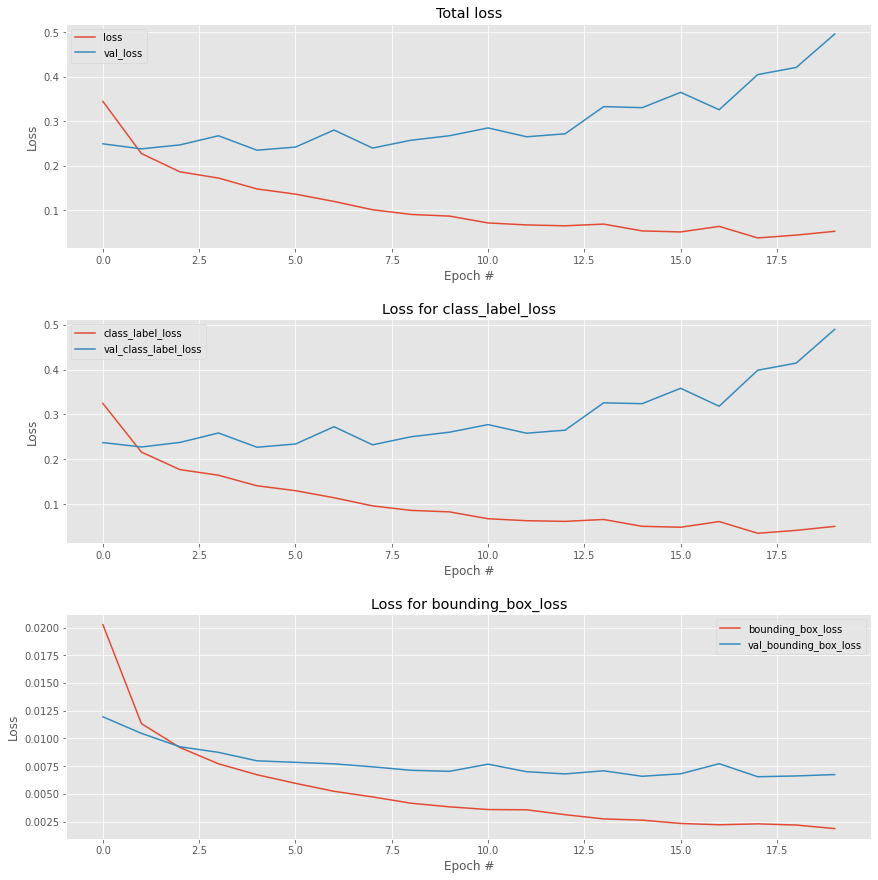

In [94]:
# plotting the total loss, class label loss, and bounding box loss during model training
loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
fig.tight_layout(pad=5.0)
plt.savefig('../Images/VGG_16_training_loss_graphs')

# loop over the loss names
for (i, l) in enumerate(loss_names):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

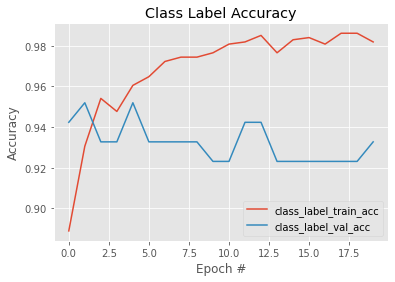

In [95]:
# plotting the class label accuracies during model training
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/VGG_16_training_label_accuracy');

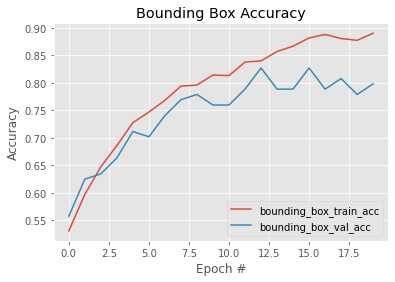

In [102]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, H.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/VGG_16_training_bounding_box_accuracy');

### Modeling - ResNet50

In [73]:
# loading ResNet50 network but leaving off output layers
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freezing all resnet layers during training so they are not updated
resnet.trainable = False

# flattening the max-pooling output of resnet
flatten = resnet.output
flatten = Flatten()(flatten)

94773248/94765736 [==============================] - 2s 0us/step


In [75]:
# constructing an output layer to predict bounding box coordinates
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

In [76]:
# constructing an output layer to predict class labels
class_head = Dense(512, activation="relu")(flatten)
class_head = Dropout(0.5)(class_head)
class_head = Dense(512, activation="relu")(class_head)
class_head = Dropout(0.5)(class_head)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head)

In [77]:
# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_resnet = Model(inputs=resnet.input, outputs=(bbox_head, class_head))

In [78]:
# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

In [79]:
# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

In [80]:
# compiling the model
model_resnet.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_resnet.summary())

Model: "functional_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# Model: "functional_6"
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
# __________________________________________________________________________________________________
# conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
# __________________________________________________________________________________________________
# conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
# __________________________________________________________________________________________________
# conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
# __________________________________________________________________________________________________
# conv1_relu (Activation)         (None, 112, 112, 64) 0           conv1_bn[0][0]                   
# __________________________________________________________________________________________________
# pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_relu[0][0]                 
# __________________________________________________________________________________________________
# pool1_pool (MaxPooling2D)       (None, 56, 56, 64)   0           pool1_pad[0][0]                  
# __________________________________________________________________________________________________
# conv2_block1_1_conv (Conv2D)    (None, 56, 56, 64)   4160        pool1_pool[0][0]                 
# __________________________________________________________________________________________________
# conv2_block1_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_1_relu (Activation (None, 56, 56, 64)   0           conv2_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block1_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_2_relu (Activation (None, 56, 56, 64)   0           conv2_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block1_0_conv (Conv2D)    (None, 56, 56, 256)  16640       pool1_pool[0][0]                 
# __________________________________________________________________________________________________
# conv2_block1_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_0_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block1_0_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_add (Add)          (None, 56, 56, 256)  0           conv2_block1_0_bn[0][0]          
#                                                                  conv2_block1_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block1_out (Activation)   (None, 56, 56, 256)  0           conv2_block1_add[0][0]           
# __________________________________________________________________________________________________
# conv2_block2_1_conv (Conv2D)    (None, 56, 56, 64)   16448       conv2_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv2_block2_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_1_relu (Activation (None, 56, 56, 64)   0           conv2_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block2_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_2_relu (Activation (None, 56, 56, 64)   0           conv2_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block2_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_add (Add)          (None, 56, 56, 256)  0           conv2_block1_out[0][0]           
#                                                                  conv2_block2_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block2_out (Activation)   (None, 56, 56, 256)  0           conv2_block2_add[0][0]           
# __________________________________________________________________________________________________
# conv2_block3_1_conv (Conv2D)    (None, 56, 56, 64)   16448       conv2_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv2_block3_1_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_1_relu (Activation (None, 56, 56, 64)   0           conv2_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block3_2_conv (Conv2D)    (None, 56, 56, 64)   36928       conv2_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_2_bn (BatchNormali (None, 56, 56, 64)   256         conv2_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_2_relu (Activation (None, 56, 56, 64)   0           conv2_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block3_3_conv (Conv2D)    (None, 56, 56, 256)  16640       conv2_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_3_bn (BatchNormali (None, 56, 56, 256)  1024        conv2_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_add (Add)          (None, 56, 56, 256)  0           conv2_block2_out[0][0]           
#                                                                  conv2_block3_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block3_out (Activation)   (None, 56, 56, 256)  0           conv2_block3_add[0][0]           
# __________________________________________________________________________________________________
# conv3_block1_1_conv (Conv2D)    (None, 28, 28, 128)  32896       conv2_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block1_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_1_relu (Activation (None, 28, 28, 128)  0           conv3_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block1_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_2_relu (Activation (None, 28, 28, 128)  0           conv3_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block1_0_conv (Conv2D)    (None, 28, 28, 512)  131584      conv2_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block1_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_0_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block1_0_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_add (Add)          (None, 28, 28, 512)  0           conv3_block1_0_bn[0][0]          
#                                                                  conv3_block1_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block1_out (Activation)   (None, 28, 28, 512)  0           conv3_block1_add[0][0]           
# __________________________________________________________________________________________________
# conv3_block2_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block2_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_1_relu (Activation (None, 28, 28, 128)  0           conv3_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block2_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_2_relu (Activation (None, 28, 28, 128)  0           conv3_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block2_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_add (Add)          (None, 28, 28, 512)  0           conv3_block1_out[0][0]           
#                                                                  conv3_block2_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block2_out (Activation)   (None, 28, 28, 512)  0           conv3_block2_add[0][0]           
# __________________________________________________________________________________________________
# conv3_block3_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block3_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_1_relu (Activation (None, 28, 28, 128)  0           conv3_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block3_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_2_relu (Activation (None, 28, 28, 128)  0           conv3_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block3_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_add (Add)          (None, 28, 28, 512)  0           conv3_block2_out[0][0]           
#                                                                  conv3_block3_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block3_out (Activation)   (None, 28, 28, 512)  0           conv3_block3_add[0][0]           
# __________________________________________________________________________________________________
# conv3_block4_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block4_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block4_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_1_relu (Activation (None, 28, 28, 128)  0           conv3_block4_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block4_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block4_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_2_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block4_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_2_relu (Activation (None, 28, 28, 128)  0           conv3_block4_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block4_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block4_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
#                                                                  conv3_block4_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block1_0_conv (Conv2D)    (None, 14, 14, 1024) 525312      conv3_block4_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_0_bn[0][0]          
#                                                                  conv4_block1_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block1_out (Activation)   (None, 14, 14, 1024) 0           conv4_block1_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block2_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block2_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_1_relu (Activation (None, 14, 14, 256)  0           conv4_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block2_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_2_relu (Activation (None, 14, 14, 256)  0           conv4_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block2_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_out[0][0]           
#                                                                  conv4_block2_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block2_out (Activation)   (None, 14, 14, 1024) 0           conv4_block2_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block3_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block3_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_1_relu (Activation (None, 14, 14, 256)  0           conv4_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block3_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_2_relu (Activation (None, 14, 14, 256)  0           conv4_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block3_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_add (Add)          (None, 14, 14, 1024) 0           conv4_block2_out[0][0]           
#                                                                  conv4_block3_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block3_out (Activation)   (None, 14, 14, 1024) 0           conv4_block3_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block4_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block4_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_1_relu (Activation (None, 14, 14, 256)  0           conv4_block4_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block4_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block4_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
#                                                                  conv4_block4_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block4_out (Activation)   (None, 14, 14, 1024) 0           conv4_block4_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block5_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block4_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block5_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_1_relu (Activation (None, 14, 14, 256)  0           conv4_block5_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block5_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block5_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_2_relu (Activation (None, 14, 14, 256)  0           conv4_block5_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block5_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block5_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block5_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_add (Add)          (None, 14, 14, 1024) 0           conv4_block4_out[0][0]           
#                                                                  conv4_block5_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block5_out (Activation)   (None, 14, 14, 1024) 0           conv4_block5_add[0][0]           
# __________________________________________________________________________________________________
# conv4_block6_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block5_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block6_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_1_relu (Activation (None, 14, 14, 256)  0           conv4_block6_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block6_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block6_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_2_relu (Activation (None, 14, 14, 256)  0           conv4_block6_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block6_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block6_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block6_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_add (Add)          (None, 14, 14, 1024) 0           conv4_block5_out[0][0]           
#                                                                  conv4_block6_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block6_out (Activation)   (None, 14, 14, 1024) 0           conv4_block6_add[0][0]           
# __________________________________________________________________________________________________
# conv5_block1_1_conv (Conv2D)    (None, 7, 7, 512)    524800      conv4_block6_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block1_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_1_relu (Activation (None, 7, 7, 512)    0           conv5_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block1_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_2_relu (Activation (None, 7, 7, 512)    0           conv5_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block1_0_conv (Conv2D)    (None, 7, 7, 2048)   2099200     conv4_block6_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block1_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_0_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_0_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_0_bn[0][0]          
#                                                                  conv5_block1_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block1_out (Activation)   (None, 7, 7, 2048)   0           conv5_block1_add[0][0]           
# __________________________________________________________________________________________________
# conv5_block2_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block2_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_add (Add)          (None, 7, 7, 2048)   0           conv5_block1_out[0][0]           
#                                                                  conv5_block2_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block2_out (Activation)   (None, 7, 7, 2048)   0           conv5_block2_add[0][0]           
# __________________________________________________________________________________________________
# conv5_block3_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block3_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_1_relu (Activation (None, 7, 7, 512)    0           conv5_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block3_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_2_relu (Activation (None, 7, 7, 512)    0           conv5_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block3_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_3_bn (BatchNormali (None, 7, 7, 2048)   8192        conv5_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_add (Add)          (None, 7, 7, 2048)   0           conv5_block2_out[0][0]           
#                                                                  conv5_block3_3_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block3_out (Activation)   (None, 7, 7, 2048)   0           conv5_block3_add[0][0]           
# __________________________________________________________________________________________________
# flatten_2 (Flatten)             (None, 100352)       0           conv5_block3_out[0][0]           
# __________________________________________________________________________________________________
# dense_13 (Dense)                (None, 512)          51380736    flatten_2[0][0]                  
# __________________________________________________________________________________________________
# dense_10 (Dense)                (None, 128)          12845184    flatten_2[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 512)          0           dense_13[0][0]                   
# __________________________________________________________________________________________________
# dense_11 (Dense)                (None, 64)           8256        dense_10[0][0]                   
# __________________________________________________________________________________________________
# dense_14 (Dense)                (None, 512)          262656      dropout_4[0][0]                  
# __________________________________________________________________________________________________
# dense_12 (Dense)                (None, 32)           2080        dense_11[0][0]                   
# __________________________________________________________________________________________________
# dropout_5 (Dropout)             (None, 512)          0           dense_14[0][0]                   
# __________________________________________________________________________________________________
# bounding_box (Dense)            (None, 4)            132         dense_12[0][0]                   
# __________________________________________________________________________________________________
# class_label (Dense)             (None, 2)            1026        dropout_5[0][0]                  
# ==================================================================================================
# Total params: 88,087,782
# Trainable params: 64,500,070
# Non-trainable params: 23,587,712
# __________________________________________________________________________________________________
# None
# ​


In [81]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

In [82]:
# training model for class and bounding box predictions
model = model_resnet.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=20, verbose=1)

Epoch 1/20
30/30 [==============================] - 60s 2s/step - loss: 0.9634 - bounding_box_loss: 0.0388 - class_label_loss: 0.9246 - bounding_box_accuracy: 0.3729 - class_label_accuracy: 0.5235 - val_loss: 0.7504 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.7228 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.3942
Epoch 2/20
30/30 [==============================] - 64s 2s/step - loss: 0.7242 - bounding_box_loss: 0.0270 - class_label_loss: 0.6972 - bounding_box_accuracy: 0.3846 - class_label_accuracy: 0.5577 - val_loss: 0.7114 - val_bounding_box_loss: 0.0264 - val_class_label_loss: 0.6849 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.4327
Epoch 3/20
30/30 [==============================] - 58s 2s/step - loss: 0.6748 - bounding_box_loss: 0.0235 - class_label_loss: 0.6513 - bounding_box_accuracy: 0.4199 - class_label_accuracy: 0.6389 - val_loss: 0.6361 - val_bounding_box_loss: 0.0162 - val_class_label_loss: 0.6199 - val_bounding_box_ac

In [97]:
# Epoch 1/20
# 30/30 [==============================] - 60s 2s/step - loss: 0.9634 - bounding_box_loss: 0.0388 - class_label_loss: 0.9246 - bounding_box_accuracy: 0.3729 - class_label_accuracy: 0.5235 - val_loss: 0.7504 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.7228 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.3942
# Epoch 2/20
# 30/30 [==============================] - 64s 2s/step - loss: 0.7242 - bounding_box_loss: 0.0270 - class_label_loss: 0.6972 - bounding_box_accuracy: 0.3846 - class_label_accuracy: 0.5577 - val_loss: 0.7114 - val_bounding_box_loss: 0.0264 - val_class_label_loss: 0.6849 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.4327
# Epoch 3/20
# 30/30 [==============================] - 58s 2s/step - loss: 0.6748 - bounding_box_loss: 0.0235 - class_label_loss: 0.6513 - bounding_box_accuracy: 0.4199 - class_label_accuracy: 0.6389 - val_loss: 0.6361 - val_bounding_box_loss: 0.0162 - val_class_label_loss: 0.6199 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9038
# Epoch 4/20
# 30/30 [==============================] - 66s 2s/step - loss: 0.6406 - bounding_box_loss: 0.0166 - class_label_loss: 0.6240 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.6645 - val_loss: 0.6234 - val_bounding_box_loss: 0.0161 - val_class_label_loss: 0.6072 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.8077
# Epoch 5/20
# 30/30 [==============================] - 67s 2s/step - loss: 0.6074 - bounding_box_loss: 0.0157 - class_label_loss: 0.5917 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.6880 - val_loss: 0.6121 - val_bounding_box_loss: 0.0146 - val_class_label_loss: 0.5975 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.6250
# Epoch 6/20
# 30/30 [==============================] - 71s 2s/step - loss: 0.5780 - bounding_box_loss: 0.0149 - class_label_loss: 0.5630 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.7212 - val_loss: 0.5432 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.5284 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.8077
# Epoch 7/20
# 30/30 [==============================] - 76s 3s/step - loss: 0.5445 - bounding_box_loss: 0.0143 - class_label_loss: 0.5302 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.7607 - val_loss: 0.4724 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.4585 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 8/20
# 30/30 [==============================] - 76s 3s/step - loss: 0.4926 - bounding_box_loss: 0.0139 - class_label_loss: 0.4787 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.7959 - val_loss: 0.4400 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.4260 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9038
# Epoch 9/20
# 30/30 [==============================] - 78s 3s/step - loss: 0.4805 - bounding_box_loss: 0.0136 - class_label_loss: 0.4670 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.8013 - val_loss: 0.4918 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.4782 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.7885
# Epoch 10/20
# 30/30 [==============================] - 75s 3s/step - loss: 0.4688 - bounding_box_loss: 0.0140 - class_label_loss: 0.4548 - bounding_box_accuracy: 0.6378 - class_label_accuracy: 0.7949 - val_loss: 0.3887 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.3754 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 11/20
# 30/30 [==============================] - 77s 3s/step - loss: 0.4545 - bounding_box_loss: 0.0130 - class_label_loss: 0.4415 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.8109 - val_loss: 0.3522 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.3387 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8558
# Epoch 12/20
# 30/30 [==============================] - 80s 3s/step - loss: 0.4134 - bounding_box_loss: 0.0126 - class_label_loss: 0.4008 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.8429 - val_loss: 0.3309 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3178 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 13/20
# 30/30 [==============================] - 77s 3s/step - loss: 0.3981 - bounding_box_loss: 0.0126 - class_label_loss: 0.3855 - bounding_box_accuracy: 0.6485 - class_label_accuracy: 0.8365 - val_loss: 0.3401 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.3258 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8942
# Epoch 14/20
# 30/30 [==============================] - 73s 2s/step - loss: 0.3731 - bounding_box_loss: 0.0129 - class_label_loss: 0.3602 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.8600 - val_loss: 0.3378 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.3242 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9038
# Epoch 15/20
# 30/30 [==============================] - 74s 2s/step - loss: 0.3846 - bounding_box_loss: 0.0125 - class_label_loss: 0.3721 - bounding_box_accuracy: 0.6186 - class_label_accuracy: 0.8408 - val_loss: 0.3095 - val_bounding_box_loss: 0.0137 - val_class_label_loss: 0.2958 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 16/20
# 30/30 [==============================] - 75s 2s/step - loss: 0.3438 - bounding_box_loss: 0.0122 - class_label_loss: 0.3316 - bounding_box_accuracy: 0.6613 - class_label_accuracy: 0.8686 - val_loss: 0.2833 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.2711 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 17/20
# 30/30 [==============================] - 75s 3s/step - loss: 0.3578 - bounding_box_loss: 0.0122 - class_label_loss: 0.3456 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.8686 - val_loss: 0.3827 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.3696 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8365
# Epoch 18/20
# 30/30 [==============================] - 74s 2s/step - loss: 0.3922 - bounding_box_loss: 0.0121 - class_label_loss: 0.3801 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.8387 - val_loss: 0.3269 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.3149 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 19/20
# 30/30 [==============================] - 76s 3s/step - loss: 0.3502 - bounding_box_loss: 0.0120 - class_label_loss: 0.3381 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.8579 - val_loss: 0.2849 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.2733 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9038
# Epoch 20/20
# 30/30 [==============================] - 74s 2s/step - loss: 0.3446 - bounding_box_loss: 0.0117 - class_label_loss: 0.3329 - bounding_box_accuracy: 0.6528 - class_label_accuracy: 0.8825 - val_loss: 0.3997 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.3878 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8462

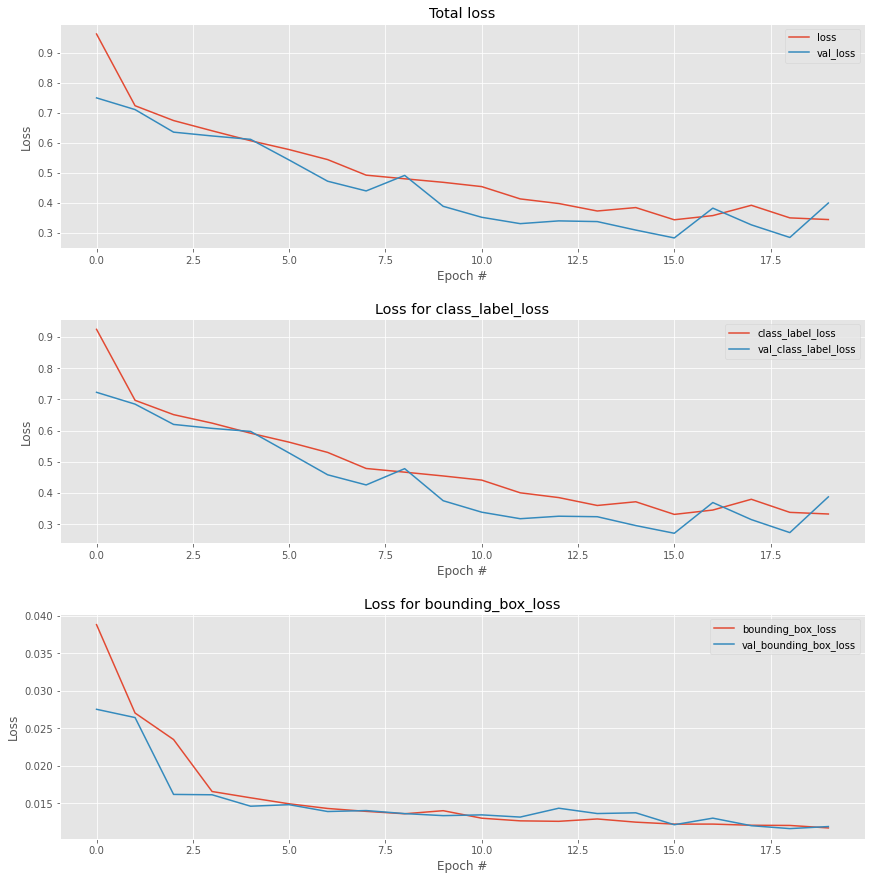

In [98]:
# plotting the total loss, class label loss, and bounding box loss during model training
loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
fig.tight_layout(pad=5.0)
plt.savefig('../Images/ResNet_50_training_loss_graphs')

# loop over the loss names
for (i, l) in enumerate(loss_names):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, model.history[l], label=l)
    ax[i].plot(N, model.history["val_" + l], label="val_" + l)
    ax[i].legend()

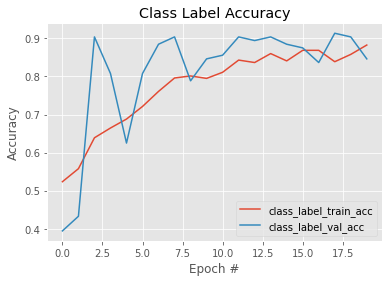

In [99]:
# plotting the class label accuracies during model training
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/ResNet_50_training_label_accuracy');

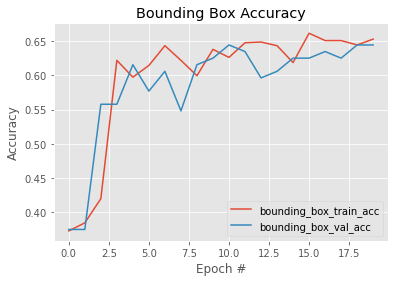

In [101]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 20) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/ResNet_50_training_bounding_box_accuracy');

### Modeling - Custom0

In [110]:
# creating custom model
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom0 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

In [111]:
# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

In [112]:
# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

In [113]:
# compiling the model
model_custom0.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom0.summary())

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 111, 111, 32) 0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 109, 109, 64) 18496       max_pooling2d_3[0][0]            
______________________________________________________________________________________

In [114]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

In [115]:
# training model for class and bounding box predictions
model = model_custom0.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=20, verbose=1)

Epoch 1/20
30/30 [==============================] - 31s 1s/step - loss: 0.7689 - bounding_box_loss: 0.0586 - class_label_loss: 0.7103 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.5182 - val_loss: 0.7099 - val_bounding_box_loss: 0.0288 - val_class_label_loss: 0.6812 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4231
Epoch 2/20
30/30 [==============================] - 33s 1s/step - loss: 0.6445 - bounding_box_loss: 0.0230 - class_label_loss: 0.6215 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.6870 - val_loss: 0.5117 - val_bounding_box_loss: 0.0182 - val_class_label_loss: 0.4935 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8365
Epoch 3/20
30/30 [==============================] - 40s 1s/step - loss: 0.4910 - bounding_box_loss: 0.0172 - class_label_loss: 0.4739 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.8291 - val_loss: 0.4925 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.4785 - val_bounding_box_ac

In [116]:
# Epoch 1/20
# 30/30 [==============================] - 31s 1s/step - loss: 0.7689 - bounding_box_loss: 0.0586 - class_label_loss: 0.7103 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.5182 - val_loss: 0.7099 - val_bounding_box_loss: 0.0288 - val_class_label_loss: 0.6812 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4231
# Epoch 2/20
# 30/30 [==============================] - 33s 1s/step - loss: 0.6445 - bounding_box_loss: 0.0230 - class_label_loss: 0.6215 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.6870 - val_loss: 0.5117 - val_bounding_box_loss: 0.0182 - val_class_label_loss: 0.4935 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8365
# Epoch 3/20
# 30/30 [==============================] - 40s 1s/step - loss: 0.4910 - bounding_box_loss: 0.0172 - class_label_loss: 0.4739 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.8291 - val_loss: 0.4925 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.4785 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.7596
# Epoch 4/20
# 30/30 [==============================] - 47s 2s/step - loss: 0.4043 - bounding_box_loss: 0.0160 - class_label_loss: 0.3883 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.8590 - val_loss: 0.3618 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.3475 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8654
# Epoch 5/20
# 30/30 [==============================] - 43s 1s/step - loss: 0.3738 - bounding_box_loss: 0.0143 - class_label_loss: 0.3596 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.8718 - val_loss: 0.3910 - val_bounding_box_loss: 0.0126 - val_class_label_loss: 0.3784 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 6/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.3770 - bounding_box_loss: 0.0137 - class_label_loss: 0.3633 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.8771 - val_loss: 0.3661 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.3543 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 7/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.3283 - bounding_box_loss: 0.0125 - class_label_loss: 0.3158 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.8964 - val_loss: 0.3895 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.3783 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8558
# Epoch 8/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.3175 - bounding_box_loss: 0.0144 - class_label_loss: 0.3031 - bounding_box_accuracy: 0.6517 - class_label_accuracy: 0.8889 - val_loss: 0.3552 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.3444 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8462
# Epoch 9/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.3026 - bounding_box_loss: 0.0115 - class_label_loss: 0.2910 - bounding_box_accuracy: 0.6581 - class_label_accuracy: 0.8932 - val_loss: 0.4014 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.3913 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8365
# Epoch 10/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.2664 - bounding_box_loss: 0.0108 - class_label_loss: 0.2556 - bounding_box_accuracy: 0.6635 - class_label_accuracy: 0.9124 - val_loss: 0.2924 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.2822 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 11/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.2318 - bounding_box_loss: 0.0106 - class_label_loss: 0.2212 - bounding_box_accuracy: 0.6763 - class_label_accuracy: 0.9209 - val_loss: 0.4399 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.4304 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8558
# Epoch 12/20
# 30/30 [==============================] - 39s 1s/step - loss: 0.2326 - bounding_box_loss: 0.0098 - class_label_loss: 0.2228 - bounding_box_accuracy: 0.6870 - class_label_accuracy: 0.9306 - val_loss: 0.2930 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.2841 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 13/20
# 30/30 [==============================] - 40s 1s/step - loss: 0.2010 - bounding_box_loss: 0.0091 - class_label_loss: 0.1919 - bounding_box_accuracy: 0.6859 - class_label_accuracy: 0.9391 - val_loss: 0.4009 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.3915 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8462
# Epoch 14/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1841 - bounding_box_loss: 0.0090 - class_label_loss: 0.1751 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9455 - val_loss: 0.2900 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.2814 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 15/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1559 - bounding_box_loss: 0.0082 - class_label_loss: 0.1477 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 0.9541 - val_loss: 0.2766 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.2682 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 16/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1694 - bounding_box_loss: 0.0079 - class_label_loss: 0.1615 - bounding_box_accuracy: 0.7158 - class_label_accuracy: 0.9391 - val_loss: 0.5298 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.5214 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8077
# Epoch 17/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1462 - bounding_box_loss: 0.0076 - class_label_loss: 0.1386 - bounding_box_accuracy: 0.7233 - class_label_accuracy: 0.9487 - val_loss: 0.3149 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.3065 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 18/20
# 30/30 [==============================] - 38s 1s/step - loss: 0.1471 - bounding_box_loss: 0.0075 - class_label_loss: 0.1396 - bounding_box_accuracy: 0.7190 - class_label_accuracy: 0.9626 - val_loss: 0.3097 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.3017 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9038
# Epoch 19/20
# 30/30 [==============================] - 37s 1s/step - loss: 0.1012 - bounding_box_loss: 0.0068 - class_label_loss: 0.0944 - bounding_box_accuracy: 0.7201 - class_label_accuracy: 0.9744 - val_loss: 0.3089 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3012 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 20/20
# 30/30 [==============================] - 37s 1s/step - loss: 0.0782 - bounding_box_loss: 0.0064 - class_label_loss: 0.0718 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9797 - val_loss: 0.4372 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.4296 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327

### Modeling - Custom1

In [117]:
# same as model_custom0 but ran for 50 epochs instead of 20

In [120]:
# creating custom model1
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom1 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
model_custom1.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom1.summary())

Model: "functional_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_12[0][0]           
______________________________________________________________________________________

In [121]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom1.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=50, verbose=1)

Epoch 1/50
30/30 [==============================] - 30s 1s/step - loss: 0.7414 - bounding_box_loss: 0.0320 - class_label_loss: 0.7094 - bounding_box_accuracy: 0.5395 - class_label_accuracy: 0.5534 - val_loss: 0.6915 - val_bounding_box_loss: 0.0202 - val_class_label_loss: 0.6713 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6923
Epoch 2/50
30/30 [==============================] - 32s 1s/step - loss: 0.6689 - bounding_box_loss: 0.0207 - class_label_loss: 0.6482 - bounding_box_accuracy: 0.5438 - class_label_accuracy: 0.6453 - val_loss: 0.6387 - val_bounding_box_loss: 0.0178 - val_class_label_loss: 0.6210 - val_bounding_box_accuracy: 0.4327 - val_class_label_accuracy: 0.6154
Epoch 3/50
30/30 [==============================] - 37s 1s/step - loss: 0.5520 - bounding_box_loss: 0.0165 - class_label_loss: 0.5355 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.8077 - val_loss: 0.4386 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.4251 - val_bounding_box_ac

30/30 [==============================] - 36s 1s/step - loss: 0.0125 - bounding_box_loss: 9.7809e-04 - class_label_loss: 0.0115 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9957 - val_loss: 0.8600 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.8530 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8654
Epoch 48/50
30/30 [==============================] - 36s 1s/step - loss: 0.0408 - bounding_box_loss: 0.0025 - class_label_loss: 0.0382 - bounding_box_accuracy: 0.8622 - class_label_accuracy: 0.9850 - val_loss: 0.5449 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.5365 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
Epoch 49/50
30/30 [==============================] - 36s 1s/step - loss: 0.0212 - bounding_box_loss: 0.0023 - class_label_loss: 0.0189 - bounding_box_accuracy: 0.8301 - class_label_accuracy: 0.9947 - val_loss: 0.5724 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.5653 - val_bounding_box_accurac

### Modeling - Custom2

In [ ]:
# same as model_custom1 but ran for 100 epochs instead of 50

In [122]:
# creating custom model2
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom2 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
model_custom2.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom2.summary())

Model: "functional_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_15[0][0]           
______________________________________________________________________________________

In [123]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom2.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 30s 1s/step - loss: 0.7274 - bounding_box_loss: 0.0318 - class_label_loss: 0.6956 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.5716 - val_loss: 0.6067 - val_bounding_box_loss: 0.0194 - val_class_label_loss: 0.5873 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
Epoch 2/100
30/30 [==============================] - 32s 1s/step - loss: 0.5536 - bounding_box_loss: 0.0175 - class_label_loss: 0.5362 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.7991 - val_loss: 0.4606 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.4474 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7981
Epoch 3/100
30/30 [==============================] - 38s 1s/step - loss: 0.4462 - bounding_box_loss: 0.0148 - class_label_loss: 0.4314 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.8408 - val_loss: 0.3969 - val_bounding_box_loss: 0.0146 - val_class_label_loss: 0.3823 - val_bounding_box

30/30 [==============================] - 36s 1s/step - loss: 0.0146 - bounding_box_loss: 0.0013 - class_label_loss: 0.0133 - bounding_box_accuracy: 0.8835 - class_label_accuracy: 0.9968 - val_loss: 0.5885 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.5815 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8942
Epoch 48/100
30/30 [==============================] - 36s 1s/step - loss: 0.0115 - bounding_box_loss: 0.0012 - class_label_loss: 0.0103 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9968 - val_loss: 0.5176 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.5106 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9135
Epoch 49/100
30/30 [==============================] - 36s 1s/step - loss: 0.0118 - bounding_box_loss: 0.0012 - class_label_loss: 0.0106 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9947 - val_loss: 0.6984 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.6916 - val_bounding_box_accuracy:

30/30 [==============================] - 55s 2s/step - loss: 0.0037 - bounding_box_loss: 3.7856e-04 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.9466 - class_label_accuracy: 0.9979 - val_loss: 0.7521 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.7452 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
Epoch 94/100
30/30 [==============================] - 55s 2s/step - loss: 0.0034 - bounding_box_loss: 3.2175e-04 - class_label_loss: 0.0031 - bounding_box_accuracy: 0.9498 - class_label_accuracy: 0.9989 - val_loss: 0.8294 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.8224 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
Epoch 95/100
30/30 [==============================] - 64s 2s/step - loss: 0.0069 - bounding_box_loss: 3.3348e-04 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.9370 - class_label_accuracy: 0.9979 - val_loss: 0.6552 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.6480 - val_bounding_b

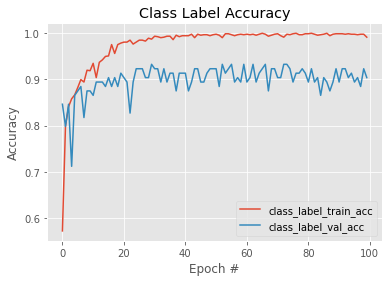

In [124]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom2_training_label_accuracy');

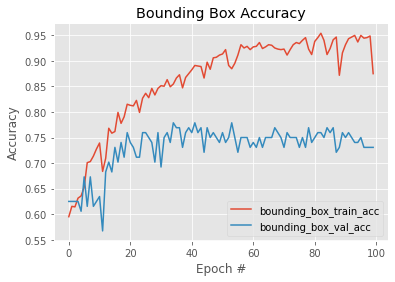

In [126]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom2_training_bounding_box_accuracy');

### Modeling - Custom3

In [28]:
# adding dropout layers to the bounding box output layer to try and increase its accuracy

In [29]:
# creating custom model3
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.2)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.2)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.2)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom3 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
model_custom3.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom3.summary())

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_12[0][0]           
_______________________________________________________________________________________

In [30]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom3.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=50, verbose=1)

Epoch 1/50
30/30 [==============================] - 28s 924ms/step - loss: 0.7608 - bounding_box_loss: 0.0614 - class_label_loss: 0.6994 - bounding_box_accuracy: 0.4605 - class_label_accuracy: 0.5737 - val_loss: 0.6613 - val_bounding_box_loss: 0.0249 - val_class_label_loss: 0.6364 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
Epoch 2/50
30/30 [==============================] - 29s 967ms/step - loss: 0.6386 - bounding_box_loss: 0.0418 - class_label_loss: 0.5968 - bounding_box_accuracy: 0.4861 - class_label_accuracy: 0.7276 - val_loss: 0.4724 - val_bounding_box_loss: 0.0183 - val_class_label_loss: 0.4541 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
Epoch 3/50
30/30 [==============================] - 30s 1s/step - loss: 0.4779 - bounding_box_loss: 0.0350 - class_label_loss: 0.4429 - bounding_box_accuracy: 0.4893 - class_label_accuracy: 0.8440 - val_loss: 0.3793 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.3646 - val_bounding_

30/30 [==============================] - 32s 1s/step - loss: 0.0244 - bounding_box_loss: 0.0095 - class_label_loss: 0.0149 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9947 - val_loss: 0.5629 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.5558 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
Epoch 48/50
30/30 [==============================] - 31s 1s/step - loss: 0.0307 - bounding_box_loss: 0.0101 - class_label_loss: 0.0206 - bounding_box_accuracy: 0.6763 - class_label_accuracy: 0.9936 - val_loss: 0.5357 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5282 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8750
Epoch 49/50
30/30 [==============================] - 32s 1s/step - loss: 0.0223 - bounding_box_loss: 0.0097 - class_label_loss: 0.0125 - bounding_box_accuracy: 0.7201 - class_label_accuracy: 0.9968 - val_loss: 0.5900 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.5833 - val_bounding_box_accuracy: 0

In [ ]:
# Epoch 1/50
# 30/30 [==============================] - 28s 924ms/step - loss: 0.7608 - bounding_box_loss: 0.0614 - class_label_loss: 0.6994 - bounding_box_accuracy: 0.4605 - class_label_accuracy: 0.5737 - val_loss: 0.6613 - val_bounding_box_loss: 0.0249 - val_class_label_loss: 0.6364 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 2/50
# 30/30 [==============================] - 29s 967ms/step - loss: 0.6386 - bounding_box_loss: 0.0418 - class_label_loss: 0.5968 - bounding_box_accuracy: 0.4861 - class_label_accuracy: 0.7276 - val_loss: 0.4724 - val_bounding_box_loss: 0.0183 - val_class_label_loss: 0.4541 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
# Epoch 3/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.4779 - bounding_box_loss: 0.0350 - class_label_loss: 0.4429 - bounding_box_accuracy: 0.4893 - class_label_accuracy: 0.8440 - val_loss: 0.3793 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.3646 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8654
# Epoch 4/50
# 30/30 [==============================] - 29s 982ms/step - loss: 0.4176 - bounding_box_loss: 0.0296 - class_label_loss: 0.3880 - bounding_box_accuracy: 0.4957 - class_label_accuracy: 0.8600 - val_loss: 0.3601 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3469 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 5/50
# 30/30 [==============================] - 30s 996ms/step - loss: 0.3850 - bounding_box_loss: 0.0276 - class_label_loss: 0.3574 - bounding_box_accuracy: 0.4968 - class_label_accuracy: 0.8814 - val_loss: 0.3706 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.3555 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8654
# Epoch 6/50
# 30/30 [==============================] - 29s 977ms/step - loss: 0.3547 - bounding_box_loss: 0.0261 - class_label_loss: 0.3285 - bounding_box_accuracy: 0.5246 - class_label_accuracy: 0.8910 - val_loss: 0.3336 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.3206 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 7/50
# 30/30 [==============================] - 29s 977ms/step - loss: 0.3361 - bounding_box_loss: 0.0246 - class_label_loss: 0.3115 - bounding_box_accuracy: 0.5267 - class_label_accuracy: 0.8964 - val_loss: 0.3346 - val_bounding_box_loss: 0.0122 - val_class_label_loss: 0.3224 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8750
# Epoch 8/50
# 30/30 [==============================] - 243s 8s/step - loss: 0.3269 - bounding_box_loss: 0.0242 - class_label_loss: 0.3027 - bounding_box_accuracy: 0.5053 - class_label_accuracy: 0.9028 - val_loss: 0.3642 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.3527 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 9/50
# 30/30 [==============================] - 29s 956ms/step - loss: 0.2852 - bounding_box_loss: 0.0221 - class_label_loss: 0.2630 - bounding_box_accuracy: 0.5171 - class_label_accuracy: 0.9113 - val_loss: 0.3119 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.3009 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 10/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.2637 - bounding_box_loss: 0.0217 - class_label_loss: 0.2420 - bounding_box_accuracy: 0.5278 - class_label_accuracy: 0.9167 - val_loss: 0.3349 - val_bounding_box_loss: 0.0176 - val_class_label_loss: 0.3173 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8750
# Epoch 11/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.2330 - bounding_box_loss: 0.0232 - class_label_loss: 0.2098 - bounding_box_accuracy: 0.5406 - class_label_accuracy: 0.9284 - val_loss: 0.3561 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.3457 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 12/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1959 - bounding_box_loss: 0.0200 - class_label_loss: 0.1759 - bounding_box_accuracy: 0.5577 - class_label_accuracy: 0.9455 - val_loss: 0.3635 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.3524 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 13/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.1628 - bounding_box_loss: 0.0188 - class_label_loss: 0.1440 - bounding_box_accuracy: 0.5299 - class_label_accuracy: 0.9541 - val_loss: 0.2932 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.2835 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 14/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.1702 - bounding_box_loss: 0.0192 - class_label_loss: 0.1510 - bounding_box_accuracy: 0.5353 - class_label_accuracy: 0.9498 - val_loss: 0.3623 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.3522 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9038
# Epoch 15/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1454 - bounding_box_loss: 0.0190 - class_label_loss: 0.1264 - bounding_box_accuracy: 0.5491 - class_label_accuracy: 0.9594 - val_loss: 0.2946 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.2836 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 16/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1289 - bounding_box_loss: 0.0180 - class_label_loss: 0.1109 - bounding_box_accuracy: 0.5705 - class_label_accuracy: 0.9679 - val_loss: 0.3556 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.3407 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 17/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.1407 - bounding_box_loss: 0.0193 - class_label_loss: 0.1214 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.9615 - val_loss: 0.3281 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.3190 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8654
# Epoch 18/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1000 - bounding_box_loss: 0.0163 - class_label_loss: 0.0837 - bounding_box_accuracy: 0.5716 - class_label_accuracy: 0.9712 - val_loss: 0.3754 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.3662 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 19/50
# 30/30 [==============================] - 112s 4s/step - loss: 0.0735 - bounding_box_loss: 0.0158 - class_label_loss: 0.0577 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.9797 - val_loss: 0.5542 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.5454 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 20/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0957 - bounding_box_loss: 0.0158 - class_label_loss: 0.0799 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9733 - val_loss: 0.4175 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.4084 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 21/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0689 - bounding_box_loss: 0.0148 - class_label_loss: 0.0540 - bounding_box_accuracy: 0.6197 - class_label_accuracy: 0.9850 - val_loss: 0.3704 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.3617 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8846
# Epoch 22/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0650 - bounding_box_loss: 0.0152 - class_label_loss: 0.0498 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.9882 - val_loss: 0.3402 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.3304 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8942
# Epoch 23/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0682 - bounding_box_loss: 0.0148 - class_label_loss: 0.0534 - bounding_box_accuracy: 0.6090 - class_label_accuracy: 0.9850 - val_loss: 0.5501 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.5411 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9038
# Epoch 24/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0758 - bounding_box_loss: 0.0143 - class_label_loss: 0.0615 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9744 - val_loss: 0.4448 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.4365 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 25/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0645 - bounding_box_loss: 0.0138 - class_label_loss: 0.0506 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 0.9882 - val_loss: 0.4102 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.4017 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 26/50
# 30/30 [==============================] - 438s 15s/step - loss: 0.0415 - bounding_box_loss: 0.0138 - class_label_loss: 0.0277 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9936 - val_loss: 0.4966 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.4878 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9038
# Epoch 27/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.0460 - bounding_box_loss: 0.0140 - class_label_loss: 0.0320 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9904 - val_loss: 0.4899 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.4821 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 28/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0553 - bounding_box_loss: 0.0131 - class_label_loss: 0.0422 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9893 - val_loss: 0.4284 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.4203 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 29/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0537 - bounding_box_loss: 0.0132 - class_label_loss: 0.0405 - bounding_box_accuracy: 0.6496 - class_label_accuracy: 0.9936 - val_loss: 0.4242 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.4159 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 30/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0399 - bounding_box_loss: 0.0130 - class_label_loss: 0.0269 - bounding_box_accuracy: 0.6314 - class_label_accuracy: 0.9904 - val_loss: 0.4588 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.4505 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 31/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.0329 - bounding_box_loss: 0.0130 - class_label_loss: 0.0199 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.9936 - val_loss: 0.5270 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.5192 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9038
# Epoch 32/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0363 - bounding_box_loss: 0.0121 - class_label_loss: 0.0242 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9915 - val_loss: 0.4795 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4720 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 33/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0355 - bounding_box_loss: 0.0121 - class_label_loss: 0.0235 - bounding_box_accuracy: 0.6571 - class_label_accuracy: 0.9947 - val_loss: 0.5148 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5075 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 34/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0286 - bounding_box_loss: 0.0117 - class_label_loss: 0.0169 - bounding_box_accuracy: 0.6400 - class_label_accuracy: 0.9957 - val_loss: 0.5065 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.4991 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8942
# Epoch 35/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0287 - bounding_box_loss: 0.0114 - class_label_loss: 0.0173 - bounding_box_accuracy: 0.6603 - class_label_accuracy: 0.9947 - val_loss: 0.5382 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5308 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 36/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0299 - bounding_box_loss: 0.0106 - class_label_loss: 0.0193 - bounding_box_accuracy: 0.6731 - class_label_accuracy: 0.9925 - val_loss: 0.4945 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4872 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 37/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0387 - bounding_box_loss: 0.0111 - class_label_loss: 0.0275 - bounding_box_accuracy: 0.6838 - class_label_accuracy: 0.9882 - val_loss: 0.5785 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.5710 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 38/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0358 - bounding_box_loss: 0.0110 - class_label_loss: 0.0248 - bounding_box_accuracy: 0.6624 - class_label_accuracy: 0.9915 - val_loss: 0.5454 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.5381 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 39/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0266 - bounding_box_loss: 0.0108 - class_label_loss: 0.0158 - bounding_box_accuracy: 0.6741 - class_label_accuracy: 0.9957 - val_loss: 0.5422 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.5347 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 40/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0235 - bounding_box_loss: 0.0105 - class_label_loss: 0.0129 - bounding_box_accuracy: 0.6688 - class_label_accuracy: 0.9968 - val_loss: 0.6578 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.6505 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135
# Epoch 41/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0279 - bounding_box_loss: 0.0109 - class_label_loss: 0.0170 - bounding_box_accuracy: 0.6784 - class_label_accuracy: 0.9957 - val_loss: 0.7439 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.7356 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 42/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0463 - bounding_box_loss: 0.0113 - class_label_loss: 0.0351 - bounding_box_accuracy: 0.6827 - class_label_accuracy: 0.9925 - val_loss: 0.4665 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.4587 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 43/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0299 - bounding_box_loss: 0.0110 - class_label_loss: 0.0189 - bounding_box_accuracy: 0.6699 - class_label_accuracy: 0.9957 - val_loss: 0.4850 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.4779 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 44/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0222 - bounding_box_loss: 0.0103 - class_label_loss: 0.0119 - bounding_box_accuracy: 0.6806 - class_label_accuracy: 0.9968 - val_loss: 0.6405 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.6333 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 45/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0250 - bounding_box_loss: 0.0099 - class_label_loss: 0.0151 - bounding_box_accuracy: 0.6998 - class_label_accuracy: 0.9947 - val_loss: 0.5738 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.5671 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 46/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0201 - bounding_box_loss: 0.0101 - class_label_loss: 0.0100 - bounding_box_accuracy: 0.6688 - class_label_accuracy: 0.9979 - val_loss: 0.6127 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.6057 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 47/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0244 - bounding_box_loss: 0.0095 - class_label_loss: 0.0149 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9947 - val_loss: 0.5629 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.5558 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 48/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0307 - bounding_box_loss: 0.0101 - class_label_loss: 0.0206 - bounding_box_accuracy: 0.6763 - class_label_accuracy: 0.9936 - val_loss: 0.5357 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5282 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8750
# Epoch 49/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0223 - bounding_box_loss: 0.0097 - class_label_loss: 0.0125 - bounding_box_accuracy: 0.7201 - class_label_accuracy: 0.9968 - val_loss: 0.5900 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.5833 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 50/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0173 - bounding_box_loss: 0.0090 - class_label_loss: 0.0083 - bounding_box_accuracy: 0.6987 - class_label_accuracy: 0.9968 - val_loss: 0.6304 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.6238 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# ​


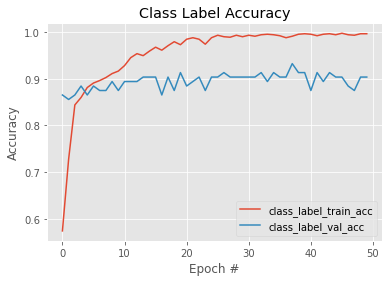

In [32]:
# plotting the class label accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom3_training_label_accuracy');

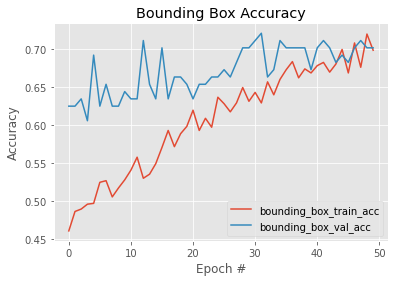

In [34]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom3_training_bounding_box_accuracy');

### Modeling - Custom4

In [35]:
# increasing learning rate from 0.0001 to 0.001 from custom3

In [36]:
# creating custom model4
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.2)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.2)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.2)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom4 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom4.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom4.summary())

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_15[0][0]           
______________________________________________________________________________________

In [37]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom4.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=50, verbose=1)

Epoch 1/50
30/30 [==============================] - 28s 921ms/step - loss: 0.9019 - bounding_box_loss: 0.0705 - class_label_loss: 0.8314 - bounding_box_accuracy: 0.4712 - class_label_accuracy: 0.5128 - val_loss: 0.7334 - val_bounding_box_loss: 0.0289 - val_class_label_loss: 0.7045 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.3942
Epoch 2/50
30/30 [==============================] - 30s 1s/step - loss: 0.6871 - bounding_box_loss: 0.0301 - class_label_loss: 0.6570 - bounding_box_accuracy: 0.4915 - class_label_accuracy: 0.6261 - val_loss: 0.5916 - val_bounding_box_loss: 0.0340 - val_class_label_loss: 0.5576 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7500
Epoch 3/50
30/30 [==============================] - 30s 1s/step - loss: 0.4897 - bounding_box_loss: 0.0310 - class_label_loss: 0.4587 - bounding_box_accuracy: 0.5128 - class_label_accuracy: 0.8312 - val_loss: 0.5039 - val_bounding_box_loss: 0.0155 - val_class_label_loss: 0.4883 - val_bounding_box

30/30 [==============================] - 31s 1s/step - loss: 0.0270 - bounding_box_loss: 0.0052 - class_label_loss: 0.0218 - bounding_box_accuracy: 0.8024 - class_label_accuracy: 0.9893 - val_loss: 1.0127 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.0047 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
Epoch 48/50
30/30 [==============================] - 31s 1s/step - loss: 0.0307 - bounding_box_loss: 0.0050 - class_label_loss: 0.0257 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 0.9915 - val_loss: 1.1841 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.1756 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
Epoch 49/50
30/30 [==============================] - 31s 1s/step - loss: 0.0218 - bounding_box_loss: 0.0045 - class_label_loss: 0.0172 - bounding_box_accuracy: 0.8056 - class_label_accuracy: 0.9925 - val_loss: 1.2972 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.2889 - val_bounding_box_accuracy: 0

In [ ]:
# Epoch 1/50
# 30/30 [==============================] - 28s 921ms/step - loss: 0.9019 - bounding_box_loss: 0.0705 - class_label_loss: 0.8314 - bounding_box_accuracy: 0.4712 - class_label_accuracy: 0.5128 - val_loss: 0.7334 - val_bounding_box_loss: 0.0289 - val_class_label_loss: 0.7045 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.3942
# Epoch 2/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.6871 - bounding_box_loss: 0.0301 - class_label_loss: 0.6570 - bounding_box_accuracy: 0.4915 - class_label_accuracy: 0.6261 - val_loss: 0.5916 - val_bounding_box_loss: 0.0340 - val_class_label_loss: 0.5576 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7500
# Epoch 3/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.4897 - bounding_box_loss: 0.0310 - class_label_loss: 0.4587 - bounding_box_accuracy: 0.5128 - class_label_accuracy: 0.8312 - val_loss: 0.5039 - val_bounding_box_loss: 0.0155 - val_class_label_loss: 0.4883 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.8077
# Epoch 4/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.4558 - bounding_box_loss: 0.0221 - class_label_loss: 0.4337 - bounding_box_accuracy: 0.5321 - class_label_accuracy: 0.8259 - val_loss: 0.3789 - val_bounding_box_loss: 0.0174 - val_class_label_loss: 0.3615 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 5/50
# 30/30 [==============================] - 30s 994ms/step - loss: 0.3577 - bounding_box_loss: 0.0215 - class_label_loss: 0.3363 - bounding_box_accuracy: 0.5513 - class_label_accuracy: 0.8964 - val_loss: 0.3508 - val_bounding_box_loss: 0.0149 - val_class_label_loss: 0.3359 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 6/50
# 30/30 [==============================] - 30s 984ms/step - loss: 0.3129 - bounding_box_loss: 0.0189 - class_label_loss: 0.2939 - bounding_box_accuracy: 0.5513 - class_label_accuracy: 0.9038 - val_loss: 0.3672 - val_bounding_box_loss: 0.0127 - val_class_label_loss: 0.3546 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.8942
# Epoch 7/50
# 30/30 [==============================] - 29s 980ms/step - loss: 0.3155 - bounding_box_loss: 0.0198 - class_label_loss: 0.2957 - bounding_box_accuracy: 0.5331 - class_label_accuracy: 0.9145 - val_loss: 0.4291 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.4149 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 8/50
# 30/30 [==============================] - 30s 988ms/step - loss: 0.2741 - bounding_box_loss: 0.0176 - class_label_loss: 0.2564 - bounding_box_accuracy: 0.5609 - class_label_accuracy: 0.9177 - val_loss: 0.3249 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.3132 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 9/50
# 30/30 [==============================] - 30s 997ms/step - loss: 0.2728 - bounding_box_loss: 0.0182 - class_label_loss: 0.2546 - bounding_box_accuracy: 0.5759 - class_label_accuracy: 0.9241 - val_loss: 0.3869 - val_bounding_box_loss: 0.0123 - val_class_label_loss: 0.3746 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 10/50
# 30/30 [==============================] - 30s 994ms/step - loss: 0.2757 - bounding_box_loss: 0.0184 - class_label_loss: 0.2573 - bounding_box_accuracy: 0.5684 - class_label_accuracy: 0.8996 - val_loss: 0.5522 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.5399 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8365
# Epoch 11/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.2100 - bounding_box_loss: 0.0159 - class_label_loss: 0.1941 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9241 - val_loss: 0.3551 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.3440 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 12/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1615 - bounding_box_loss: 0.0140 - class_label_loss: 0.1475 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9423 - val_loss: 0.3590 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.3475 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 13/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1879 - bounding_box_loss: 0.0148 - class_label_loss: 0.1732 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9338 - val_loss: 0.4164 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.4069 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 14/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1204 - bounding_box_loss: 0.0124 - class_label_loss: 0.1080 - bounding_box_accuracy: 0.6165 - class_label_accuracy: 0.9594 - val_loss: 0.6208 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.6113 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8462
# Epoch 15/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1114 - bounding_box_loss: 0.0119 - class_label_loss: 0.0995 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9701 - val_loss: 0.4204 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.4109 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 16/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1022 - bounding_box_loss: 0.0115 - class_label_loss: 0.0907 - bounding_box_accuracy: 0.6421 - class_label_accuracy: 0.9701 - val_loss: 0.4893 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.4780 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 17/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0945 - bounding_box_loss: 0.0111 - class_label_loss: 0.0834 - bounding_box_accuracy: 0.6517 - class_label_accuracy: 0.9754 - val_loss: 0.4486 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.4402 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 18/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.2164 - bounding_box_loss: 0.0121 - class_label_loss: 0.2043 - bounding_box_accuracy: 0.6677 - class_label_accuracy: 0.9199 - val_loss: 0.5978 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.5861 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8462
# Epoch 19/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1981 - bounding_box_loss: 0.0118 - class_label_loss: 0.1862 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.9402 - val_loss: 0.4470 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.4379 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 20/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0915 - bounding_box_loss: 0.0105 - class_label_loss: 0.0810 - bounding_box_accuracy: 0.6656 - class_label_accuracy: 0.9744 - val_loss: 0.7387 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.7298 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 21/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0653 - bounding_box_loss: 0.0103 - class_label_loss: 0.0550 - bounding_box_accuracy: 0.7062 - class_label_accuracy: 0.9818 - val_loss: 0.6489 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.6408 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9135
# Epoch 22/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0583 - bounding_box_loss: 0.0088 - class_label_loss: 0.0495 - bounding_box_accuracy: 0.6848 - class_label_accuracy: 0.9776 - val_loss: 0.7669 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.7590 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8942
# Epoch 23/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0569 - bounding_box_loss: 0.0085 - class_label_loss: 0.0484 - bounding_box_accuracy: 0.7340 - class_label_accuracy: 0.9818 - val_loss: 0.9547 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.9461 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 24/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0805 - bounding_box_loss: 0.0083 - class_label_loss: 0.0722 - bounding_box_accuracy: 0.6827 - class_label_accuracy: 0.9765 - val_loss: 0.6939 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.6863 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9038
# Epoch 25/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0541 - bounding_box_loss: 0.0077 - class_label_loss: 0.0465 - bounding_box_accuracy: 0.7212 - class_label_accuracy: 0.9840 - val_loss: 0.6160 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.6080 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 26/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0462 - bounding_box_loss: 0.0073 - class_label_loss: 0.0389 - bounding_box_accuracy: 0.7489 - class_label_accuracy: 0.9850 - val_loss: 0.9855 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.9776 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 27/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0352 - bounding_box_loss: 0.0071 - class_label_loss: 0.0281 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9904 - val_loss: 0.9587 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.9498 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8846
# Epoch 28/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0346 - bounding_box_loss: 0.0075 - class_label_loss: 0.0271 - bounding_box_accuracy: 0.7660 - class_label_accuracy: 0.9893 - val_loss: 0.9623 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.9539 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 29/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0315 - bounding_box_loss: 0.0070 - class_label_loss: 0.0245 - bounding_box_accuracy: 0.7596 - class_label_accuracy: 0.9925 - val_loss: 1.1275 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 1.1190 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 30/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0376 - bounding_box_loss: 0.0068 - class_label_loss: 0.0308 - bounding_box_accuracy: 0.7564 - class_label_accuracy: 0.9882 - val_loss: 0.9615 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.9540 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9038
# Epoch 31/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0304 - bounding_box_loss: 0.0062 - class_label_loss: 0.0242 - bounding_box_accuracy: 0.7714 - class_label_accuracy: 0.9915 - val_loss: 1.1374 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 1.1286 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 32/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0262 - bounding_box_loss: 0.0066 - class_label_loss: 0.0196 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9936 - val_loss: 1.2040 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.1960 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8942
# Epoch 33/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0319 - bounding_box_loss: 0.0064 - class_label_loss: 0.0255 - bounding_box_accuracy: 0.7564 - class_label_accuracy: 0.9882 - val_loss: 0.8426 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.8339 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 34/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0357 - bounding_box_loss: 0.0066 - class_label_loss: 0.0291 - bounding_box_accuracy: 0.7714 - class_label_accuracy: 0.9861 - val_loss: 1.0253 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 1.0179 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 35/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1551 - bounding_box_loss: 0.0107 - class_label_loss: 0.1444 - bounding_box_accuracy: 0.6934 - class_label_accuracy: 0.9541 - val_loss: 0.5178 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.5087 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 36/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0798 - bounding_box_loss: 0.0072 - class_label_loss: 0.0726 - bounding_box_accuracy: 0.7404 - class_label_accuracy: 0.9733 - val_loss: 0.5493 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.5417 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 37/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0564 - bounding_box_loss: 0.0068 - class_label_loss: 0.0496 - bounding_box_accuracy: 0.7660 - class_label_accuracy: 0.9850 - val_loss: 0.7988 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.7904 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8942
# Epoch 38/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0474 - bounding_box_loss: 0.0058 - class_label_loss: 0.0416 - bounding_box_accuracy: 0.7628 - class_label_accuracy: 0.9850 - val_loss: 0.9248 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.9161 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 39/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0479 - bounding_box_loss: 0.0063 - class_label_loss: 0.0416 - bounding_box_accuracy: 0.7842 - class_label_accuracy: 0.9861 - val_loss: 1.2636 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 1.2548 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8462
# Epoch 40/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1059 - bounding_box_loss: 0.0066 - class_label_loss: 0.0993 - bounding_box_accuracy: 0.7842 - class_label_accuracy: 0.9626 - val_loss: 0.7464 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.7378 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 41/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0442 - bounding_box_loss: 0.0067 - class_label_loss: 0.0375 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9872 - val_loss: 1.5138 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 1.5038 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8750
# Epoch 42/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0276 - bounding_box_loss: 0.0058 - class_label_loss: 0.0218 - bounding_box_accuracy: 0.7596 - class_label_accuracy: 0.9936 - val_loss: 1.4444 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.4361 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 43/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0298 - bounding_box_loss: 0.0054 - class_label_loss: 0.0243 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 0.9904 - val_loss: 0.9812 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.9733 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 44/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0378 - bounding_box_loss: 0.0052 - class_label_loss: 0.0326 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9872 - val_loss: 1.1579 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.1495 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8558
# Epoch 45/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0392 - bounding_box_loss: 0.0056 - class_label_loss: 0.0336 - bounding_box_accuracy: 0.7874 - class_label_accuracy: 0.9840 - val_loss: 1.2177 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 1.2089 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 46/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0289 - bounding_box_loss: 0.0049 - class_label_loss: 0.0240 - bounding_box_accuracy: 0.7970 - class_label_accuracy: 0.9925 - val_loss: 1.2260 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.2171 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 47/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0270 - bounding_box_loss: 0.0052 - class_label_loss: 0.0218 - bounding_box_accuracy: 0.8024 - class_label_accuracy: 0.9893 - val_loss: 1.0127 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.0047 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 48/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0307 - bounding_box_loss: 0.0050 - class_label_loss: 0.0257 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 0.9915 - val_loss: 1.1841 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.1756 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 49/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0218 - bounding_box_loss: 0.0045 - class_label_loss: 0.0172 - bounding_box_accuracy: 0.8056 - class_label_accuracy: 0.9925 - val_loss: 1.2972 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.2889 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 50/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.0221 - bounding_box_loss: 0.0047 - class_label_loss: 0.0174 - bounding_box_accuracy: 0.7906 - class_label_accuracy: 0.9925 - val_loss: 1.2850 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.2766 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942

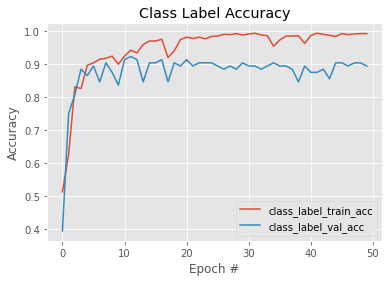

In [38]:
# plotting the class label accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom4_training_label_accuracy');

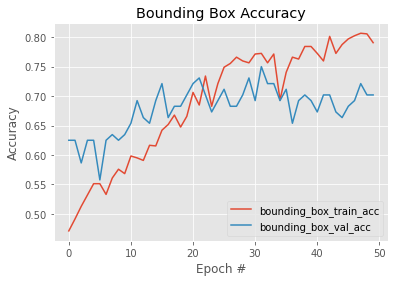

In [39]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom4_training_bounding_box_accuracy');

### Modeling - Custom5

In [ ]:
# same model as custom 4 just dropping running more epochs

In [40]:
# creating custom model5
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.2)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.2)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.2)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom5 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom5.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom5.summary())

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_18[0][0]           
______________________________________________________________________________________

In [41]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom5.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 29s 964ms/step - loss: 0.9637 - bounding_box_loss: 0.0460 - class_label_loss: 0.9177 - bounding_box_accuracy: 0.4402 - class_label_accuracy: 0.5043 - val_loss: 0.6832 - val_bounding_box_loss: 0.0271 - val_class_label_loss: 0.6562 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6058
Epoch 2/100
30/30 [==============================] - 31s 1s/step - loss: 0.6982 - bounding_box_loss: 0.0289 - class_label_loss: 0.6692 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.6090 - val_loss: 0.5476 - val_bounding_box_loss: 0.0205 - val_class_label_loss: 0.5271 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
Epoch 3/100
30/30 [==============================] - 30s 1000ms/step - loss: 0.4925 - bounding_box_loss: 0.0223 - class_label_loss: 0.4702 - bounding_box_accuracy: 0.5214 - class_label_accuracy: 0.8088 - val_loss: 0.4093 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.3946 - val_bound

30/30 [==============================] - 32s 1s/step - loss: 0.0108 - bounding_box_loss: 0.0040 - class_label_loss: 0.0068 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 0.9979 - val_loss: 0.9267 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.9189 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
Epoch 48/100
30/30 [==============================] - 32s 1s/step - loss: 0.0137 - bounding_box_loss: 0.0042 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.7788 - class_label_accuracy: 0.9968 - val_loss: 0.8783 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.8698 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
Epoch 49/100
30/30 [==============================] - 31s 1s/step - loss: 0.0135 - bounding_box_loss: 0.0042 - class_label_loss: 0.0092 - bounding_box_accuracy: 0.7949 - class_label_accuracy: 0.9957 - val_loss: 0.8273 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.8192 - val_bounding_box_accuracy:

30/30 [==============================] - 31s 1s/step - loss: 0.0058 - bounding_box_loss: 0.0026 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 0.9989 - val_loss: 0.9929 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.9848 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135
Epoch 94/100
30/30 [==============================] - 31s 1s/step - loss: 0.0046 - bounding_box_loss: 0.0027 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.8333 - class_label_accuracy: 1.0000 - val_loss: 1.0759 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.0677 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
Epoch 95/100
30/30 [==============================] - 31s 1s/step - loss: 0.0037 - bounding_box_loss: 0.0026 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.8558 - class_label_accuracy: 0.9989 - val_loss: 1.0946 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 1.0862 - val_bounding_box_accuracy:

In [ ]:

# Epoch 1/100
# 30/30 [==============================] - 29s 964ms/step - loss: 0.9637 - bounding_box_loss: 0.0460 - class_label_loss: 0.9177 - bounding_box_accuracy: 0.4402 - class_label_accuracy: 0.5043 - val_loss: 0.6832 - val_bounding_box_loss: 0.0271 - val_class_label_loss: 0.6562 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6058
# Epoch 2/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.6982 - bounding_box_loss: 0.0289 - class_label_loss: 0.6692 - bounding_box_accuracy: 0.4818 - class_label_accuracy: 0.6090 - val_loss: 0.5476 - val_bounding_box_loss: 0.0205 - val_class_label_loss: 0.5271 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 3/100
# 30/30 [==============================] - 30s 1000ms/step - loss: 0.4925 - bounding_box_loss: 0.0223 - class_label_loss: 0.4702 - bounding_box_accuracy: 0.5214 - class_label_accuracy: 0.8088 - val_loss: 0.4093 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.3946 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 4/100
# 30/30 [==============================] - 30s 991ms/step - loss: 0.3696 - bounding_box_loss: 0.0196 - class_label_loss: 0.3500 - bounding_box_accuracy: 0.5118 - class_label_accuracy: 0.8558 - val_loss: 0.3541 - val_bounding_box_loss: 0.0144 - val_class_label_loss: 0.3396 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 5/100
# 30/30 [==============================] - 29s 976ms/step - loss: 0.3384 - bounding_box_loss: 0.0180 - class_label_loss: 0.3204 - bounding_box_accuracy: 0.5331 - class_label_accuracy: 0.8771 - val_loss: 0.4554 - val_bounding_box_loss: 0.0184 - val_class_label_loss: 0.4370 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 6/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.3063 - bounding_box_loss: 0.0179 - class_label_loss: 0.2884 - bounding_box_accuracy: 0.5374 - class_label_accuracy: 0.9071 - val_loss: 0.2851 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.2741 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 7/100
# 30/30 [==============================] - 30s 998ms/step - loss: 0.2614 - bounding_box_loss: 0.0166 - class_label_loss: 0.2448 - bounding_box_accuracy: 0.5801 - class_label_accuracy: 0.9135 - val_loss: 0.2772 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.2653 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 8/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.2401 - bounding_box_loss: 0.0152 - class_label_loss: 0.2250 - bounding_box_accuracy: 0.6058 - class_label_accuracy: 0.9306 - val_loss: 0.2767 - val_bounding_box_loss: 0.0114 - val_class_label_loss: 0.2653 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 9/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.1867 - bounding_box_loss: 0.0135 - class_label_loss: 0.1732 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9509 - val_loss: 0.4698 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.4569 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8558
# Epoch 10/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.2669 - bounding_box_loss: 0.0159 - class_label_loss: 0.2510 - bounding_box_accuracy: 0.5919 - class_label_accuracy: 0.9113 - val_loss: 0.3110 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.3001 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9231
# Epoch 11/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.3117 - bounding_box_loss: 0.0161 - class_label_loss: 0.2956 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.8974 - val_loss: 0.3674 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.3551 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 12/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.1711 - bounding_box_loss: 0.0129 - class_label_loss: 0.1582 - bounding_box_accuracy: 0.6058 - class_label_accuracy: 0.9455 - val_loss: 0.3161 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.3052 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 13/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.1339 - bounding_box_loss: 0.0123 - class_label_loss: 0.1216 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.9679 - val_loss: 0.5018 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.4922 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 14/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.1100 - bounding_box_loss: 0.0120 - class_label_loss: 0.0980 - bounding_box_accuracy: 0.6186 - class_label_accuracy: 0.9776 - val_loss: 0.4230 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.4139 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 15/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0879 - bounding_box_loss: 0.0106 - class_label_loss: 0.0774 - bounding_box_accuracy: 0.6325 - class_label_accuracy: 0.9733 - val_loss: 0.4214 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.4119 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 16/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0929 - bounding_box_loss: 0.0112 - class_label_loss: 0.0818 - bounding_box_accuracy: 0.6389 - class_label_accuracy: 0.9776 - val_loss: 0.7248 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.7156 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 17/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0752 - bounding_box_loss: 0.0100 - class_label_loss: 0.0651 - bounding_box_accuracy: 0.6538 - class_label_accuracy: 0.9797 - val_loss: 0.5768 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.5674 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 18/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0566 - bounding_box_loss: 0.0092 - class_label_loss: 0.0474 - bounding_box_accuracy: 0.6400 - class_label_accuracy: 0.9818 - val_loss: 0.5491 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.5404 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 19/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0530 - bounding_box_loss: 0.0080 - class_label_loss: 0.0449 - bounding_box_accuracy: 0.6709 - class_label_accuracy: 0.9829 - val_loss: 0.5170 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.5091 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 20/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0538 - bounding_box_loss: 0.0080 - class_label_loss: 0.0458 - bounding_box_accuracy: 0.6720 - class_label_accuracy: 0.9818 - val_loss: 0.6332 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.6249 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 21/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0479 - bounding_box_loss: 0.0082 - class_label_loss: 0.0396 - bounding_box_accuracy: 0.6955 - class_label_accuracy: 0.9861 - val_loss: 0.7237 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.7155 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 22/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0405 - bounding_box_loss: 0.0075 - class_label_loss: 0.0330 - bounding_box_accuracy: 0.7051 - class_label_accuracy: 0.9915 - val_loss: 0.8740 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.8654 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 23/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0374 - bounding_box_loss: 0.0070 - class_label_loss: 0.0305 - bounding_box_accuracy: 0.7308 - class_label_accuracy: 0.9893 - val_loss: 0.6154 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.6083 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9135
# Epoch 24/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0411 - bounding_box_loss: 0.0068 - class_label_loss: 0.0343 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9882 - val_loss: 0.5456 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.5377 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 25/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0326 - bounding_box_loss: 0.0067 - class_label_loss: 0.0259 - bounding_box_accuracy: 0.7340 - class_label_accuracy: 0.9893 - val_loss: 0.6334 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.6263 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 26/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0270 - bounding_box_loss: 0.0062 - class_label_loss: 0.0207 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9936 - val_loss: 0.8419 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.8348 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9135
# Epoch 27/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0352 - bounding_box_loss: 0.0063 - class_label_loss: 0.0289 - bounding_box_accuracy: 0.7479 - class_label_accuracy: 0.9882 - val_loss: 1.0382 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 1.0308 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9038
# Epoch 28/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0298 - bounding_box_loss: 0.0059 - class_label_loss: 0.0239 - bounding_box_accuracy: 0.7415 - class_label_accuracy: 0.9893 - val_loss: 0.6458 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.6386 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 29/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0335 - bounding_box_loss: 0.0061 - class_label_loss: 0.0274 - bounding_box_accuracy: 0.7511 - class_label_accuracy: 0.9893 - val_loss: 0.6724 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.6656 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 30/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0170 - bounding_box_loss: 0.0056 - class_label_loss: 0.0114 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9968 - val_loss: 0.9644 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.9573 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9327
# Epoch 31/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0321 - bounding_box_loss: 0.0053 - class_label_loss: 0.0267 - bounding_box_accuracy: 0.7682 - class_label_accuracy: 0.9925 - val_loss: 0.7048 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.6982 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 32/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0278 - bounding_box_loss: 0.0052 - class_label_loss: 0.0227 - bounding_box_accuracy: 0.7425 - class_label_accuracy: 0.9893 - val_loss: 0.6842 - val_bounding_box_loss: 0.0065 - val_class_label_loss: 0.6777 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 33/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0280 - bounding_box_loss: 0.0050 - class_label_loss: 0.0230 - bounding_box_accuracy: 0.7692 - class_label_accuracy: 0.9947 - val_loss: 0.8358 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.8280 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327
# Epoch 34/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0225 - bounding_box_loss: 0.0052 - class_label_loss: 0.0172 - bounding_box_accuracy: 0.7917 - class_label_accuracy: 0.9957 - val_loss: 0.7377 - val_bounding_box_loss: 0.0064 - val_class_label_loss: 0.7314 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 35/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0329 - bounding_box_loss: 0.0050 - class_label_loss: 0.0279 - bounding_box_accuracy: 0.7842 - class_label_accuracy: 0.9936 - val_loss: 1.5556 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 1.5482 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8462
# Epoch 36/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.1350 - bounding_box_loss: 0.0076 - class_label_loss: 0.1274 - bounding_box_accuracy: 0.7447 - class_label_accuracy: 0.9594 - val_loss: 0.8727 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.8631 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 37/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0771 - bounding_box_loss: 0.0068 - class_label_loss: 0.0702 - bounding_box_accuracy: 0.7660 - class_label_accuracy: 0.9765 - val_loss: 0.5829 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5728 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8750
# Epoch 38/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0476 - bounding_box_loss: 0.0059 - class_label_loss: 0.0417 - bounding_box_accuracy: 0.7415 - class_label_accuracy: 0.9882 - val_loss: 0.5927 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.5847 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 39/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0459 - bounding_box_loss: 0.0055 - class_label_loss: 0.0404 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 0.9840 - val_loss: 0.4813 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.4708 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 40/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0315 - bounding_box_loss: 0.0050 - class_label_loss: 0.0265 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9893 - val_loss: 0.6688 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.6606 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327
# Epoch 41/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0159 - bounding_box_loss: 0.0047 - class_label_loss: 0.0112 - bounding_box_accuracy: 0.7564 - class_label_accuracy: 0.9979 - val_loss: 0.6052 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.5971 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 42/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0138 - bounding_box_loss: 0.0045 - class_label_loss: 0.0093 - bounding_box_accuracy: 0.7746 - class_label_accuracy: 0.9968 - val_loss: 0.7684 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.7603 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 43/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0163 - bounding_box_loss: 0.0047 - class_label_loss: 0.0116 - bounding_box_accuracy: 0.7831 - class_label_accuracy: 0.9947 - val_loss: 0.7648 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.7567 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 44/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0210 - bounding_box_loss: 0.0044 - class_label_loss: 0.0166 - bounding_box_accuracy: 0.8024 - class_label_accuracy: 0.9957 - val_loss: 0.7547 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.7459 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 45/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0043 - class_label_loss: 0.0099 - bounding_box_accuracy: 0.7831 - class_label_accuracy: 0.9957 - val_loss: 0.7672 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.7589 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327
# Epoch 46/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0165 - bounding_box_loss: 0.0042 - class_label_loss: 0.0123 - bounding_box_accuracy: 0.8088 - class_label_accuracy: 0.9957 - val_loss: 0.7256 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.7176 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 47/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0108 - bounding_box_loss: 0.0040 - class_label_loss: 0.0068 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 0.9979 - val_loss: 0.9267 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.9189 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 48/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0137 - bounding_box_loss: 0.0042 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.7788 - class_label_accuracy: 0.9968 - val_loss: 0.8783 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.8698 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 49/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0135 - bounding_box_loss: 0.0042 - class_label_loss: 0.0092 - bounding_box_accuracy: 0.7949 - class_label_accuracy: 0.9957 - val_loss: 0.8273 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.8192 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 50/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0125 - bounding_box_loss: 0.0040 - class_label_loss: 0.0085 - bounding_box_accuracy: 0.8077 - class_label_accuracy: 0.9957 - val_loss: 0.8206 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.8112 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 51/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0180 - bounding_box_loss: 0.0042 - class_label_loss: 0.0138 - bounding_box_accuracy: 0.8098 - class_label_accuracy: 0.9957 - val_loss: 0.6793 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.6711 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 52/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0094 - bounding_box_loss: 0.0042 - class_label_loss: 0.0051 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 0.9979 - val_loss: 0.8557 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.8482 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 53/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0111 - bounding_box_loss: 0.0039 - class_label_loss: 0.0072 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 0.9968 - val_loss: 0.9632 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.9544 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 54/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0199 - bounding_box_loss: 0.0044 - class_label_loss: 0.0155 - bounding_box_accuracy: 0.7863 - class_label_accuracy: 0.9947 - val_loss: 0.7724 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.7651 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9038
# Epoch 55/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0121 - bounding_box_loss: 0.0041 - class_label_loss: 0.0080 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 0.9957 - val_loss: 1.0668 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 1.0590 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 56/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0097 - bounding_box_loss: 0.0036 - class_label_loss: 0.0061 - bounding_box_accuracy: 0.8184 - class_label_accuracy: 0.9979 - val_loss: 1.1308 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 1.1232 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 57/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0085 - bounding_box_loss: 0.0039 - class_label_loss: 0.0045 - bounding_box_accuracy: 0.8184 - class_label_accuracy: 0.9979 - val_loss: 0.9840 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.9758 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 58/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0080 - bounding_box_loss: 0.0037 - class_label_loss: 0.0043 - bounding_box_accuracy: 0.8056 - class_label_accuracy: 0.9979 - val_loss: 1.4380 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 1.4301 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8942
# Epoch 59/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0154 - bounding_box_loss: 0.0035 - class_label_loss: 0.0120 - bounding_box_accuracy: 0.8237 - class_label_accuracy: 0.9968 - val_loss: 0.9134 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.9059 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 60/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0082 - bounding_box_loss: 0.0037 - class_label_loss: 0.0045 - bounding_box_accuracy: 0.8184 - class_label_accuracy: 0.9979 - val_loss: 1.1545 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.1461 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 61/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0084 - bounding_box_loss: 0.0034 - class_label_loss: 0.0049 - bounding_box_accuracy: 0.8312 - class_label_accuracy: 0.9979 - val_loss: 1.0577 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.0493 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 62/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0082 - bounding_box_loss: 0.0035 - class_label_loss: 0.0047 - bounding_box_accuracy: 0.8120 - class_label_accuracy: 0.9979 - val_loss: 1.1087 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 1.1005 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 63/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0062 - bounding_box_loss: 0.0036 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.8194 - class_label_accuracy: 0.9989 - val_loss: 1.1428 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.1347 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 64/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0044 - bounding_box_loss: 0.0034 - class_label_loss: 0.0010 - bounding_box_accuracy: 0.8280 - class_label_accuracy: 1.0000 - val_loss: 1.2223 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.2139 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 65/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0042 - bounding_box_loss: 0.0033 - class_label_loss: 9.4063e-04 - bounding_box_accuracy: 0.8248 - class_label_accuracy: 1.0000 - val_loss: 1.3047 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.2966 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 66/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0065 - bounding_box_loss: 0.0034 - class_label_loss: 0.0031 - bounding_box_accuracy: 0.8194 - class_label_accuracy: 0.9989 - val_loss: 1.1834 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 1.1753 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9135
# Epoch 67/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0051 - bounding_box_loss: 0.0032 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.8344 - class_label_accuracy: 0.9989 - val_loss: 1.1718 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.1635 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 68/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0139 - bounding_box_loss: 0.0031 - class_label_loss: 0.0108 - bounding_box_accuracy: 0.8269 - class_label_accuracy: 0.9957 - val_loss: 0.9731 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.9651 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 69/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0063 - bounding_box_loss: 0.0033 - class_label_loss: 0.0030 - bounding_box_accuracy: 0.8408 - class_label_accuracy: 0.9989 - val_loss: 1.0237 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 1.0158 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 70/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0044 - bounding_box_loss: 0.0034 - class_label_loss: 9.9178e-04 - bounding_box_accuracy: 0.8408 - class_label_accuracy: 1.0000 - val_loss: 1.0272 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 1.0193 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 71/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0064 - bounding_box_loss: 0.0030 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.8429 - class_label_accuracy: 0.9989 - val_loss: 1.7919 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.7837 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 72/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0299 - bounding_box_loss: 0.0048 - class_label_loss: 0.0251 - bounding_box_accuracy: 0.7810 - class_label_accuracy: 0.9893 - val_loss: 0.8789 - val_bounding_box_loss: 0.0152 - val_class_label_loss: 0.8637 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8462
# Epoch 73/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0313 - bounding_box_loss: 0.0052 - class_label_loss: 0.0261 - bounding_box_accuracy: 0.8312 - class_label_accuracy: 0.9925 - val_loss: 0.7779 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.7688 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 74/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0050 - bounding_box_loss: 0.0036 - class_label_loss: 0.0015 - bounding_box_accuracy: 0.8248 - class_label_accuracy: 0.9989 - val_loss: 1.0249 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 1.0167 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 75/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0070 - bounding_box_loss: 0.0035 - class_label_loss: 0.0036 - bounding_box_accuracy: 0.8600 - class_label_accuracy: 0.9979 - val_loss: 1.2088 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.2005 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9327
# Epoch 76/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0277 - bounding_box_loss: 0.0038 - class_label_loss: 0.0239 - bounding_box_accuracy: 0.8194 - class_label_accuracy: 0.9882 - val_loss: 1.0965 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 1.0886 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 77/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0604 - bounding_box_loss: 0.0046 - class_label_loss: 0.0558 - bounding_box_accuracy: 0.8419 - class_label_accuracy: 0.9829 - val_loss: 1.6494 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.6413 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.7981
# Epoch 78/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0597 - bounding_box_loss: 0.0043 - class_label_loss: 0.0554 - bounding_box_accuracy: 0.7895 - class_label_accuracy: 0.9829 - val_loss: 0.7756 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.7677 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 79/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0193 - bounding_box_loss: 0.0038 - class_label_loss: 0.0155 - bounding_box_accuracy: 0.8173 - class_label_accuracy: 0.9957 - val_loss: 1.2134 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 1.2048 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8558
# Epoch 80/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0127 - bounding_box_loss: 0.0034 - class_label_loss: 0.0093 - bounding_box_accuracy: 0.8301 - class_label_accuracy: 0.9957 - val_loss: 1.0355 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 1.0274 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8942
# Epoch 81/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0097 - bounding_box_loss: 0.0031 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.8291 - class_label_accuracy: 0.9968 - val_loss: 1.0566 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.0483 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8942
# Epoch 82/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0055 - bounding_box_loss: 0.0030 - class_label_loss: 0.0025 - bounding_box_accuracy: 0.8365 - class_label_accuracy: 0.9989 - val_loss: 1.0772 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 1.0689 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 83/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0123 - bounding_box_loss: 0.0028 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.8269 - class_label_accuracy: 0.9968 - val_loss: 1.0779 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.0698 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8462
# Epoch 84/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0073 - bounding_box_loss: 0.0031 - class_label_loss: 0.0042 - bounding_box_accuracy: 0.8558 - class_label_accuracy: 0.9989 - val_loss: 1.1115 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 1.1037 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8942
# Epoch 85/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0030 - class_label_loss: 0.0030 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.9989 - val_loss: 1.4568 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 1.4476 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8654
# Epoch 86/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0116 - bounding_box_loss: 0.0032 - class_label_loss: 0.0084 - bounding_box_accuracy: 0.8419 - class_label_accuracy: 0.9947 - val_loss: 1.4272 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 1.4165 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8558
# Epoch 87/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0090 - bounding_box_loss: 0.0030 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.8440 - class_label_accuracy: 0.9979 - val_loss: 1.2308 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 1.2231 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 88/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0083 - bounding_box_loss: 0.0030 - class_label_loss: 0.0054 - bounding_box_accuracy: 0.8333 - class_label_accuracy: 0.9968 - val_loss: 0.9115 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.9036 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8846
# Epoch 89/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0069 - bounding_box_loss: 0.0029 - class_label_loss: 0.0040 - bounding_box_accuracy: 0.8376 - class_label_accuracy: 0.9989 - val_loss: 0.9213 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.9134 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 90/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0050 - bounding_box_loss: 0.0028 - class_label_loss: 0.0022 - bounding_box_accuracy: 0.8526 - class_label_accuracy: 0.9989 - val_loss: 1.0406 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.0325 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 91/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0103 - bounding_box_loss: 0.0027 - class_label_loss: 0.0076 - bounding_box_accuracy: 0.8323 - class_label_accuracy: 0.9979 - val_loss: 0.9218 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.9136 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8942
# Epoch 92/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0028 - class_label_loss: 0.0020 - bounding_box_accuracy: 0.8718 - class_label_accuracy: 0.9989 - val_loss: 0.9800 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.9718 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 93/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0058 - bounding_box_loss: 0.0026 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 0.9989 - val_loss: 0.9929 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.9848 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135
# Epoch 94/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0046 - bounding_box_loss: 0.0027 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.8333 - class_label_accuracy: 1.0000 - val_loss: 1.0759 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.0677 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 95/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0037 - bounding_box_loss: 0.0026 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.8558 - class_label_accuracy: 0.9989 - val_loss: 1.0946 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 1.0862 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9038
# Epoch 96/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0038 - bounding_box_loss: 0.0027 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.8440 - class_label_accuracy: 1.0000 - val_loss: 1.1093 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.1013 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8942
# Epoch 97/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0046 - bounding_box_loss: 0.0026 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.8344 - class_label_accuracy: 0.9989 - val_loss: 1.1160 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.1079 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 98/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0029 - bounding_box_loss: 0.0025 - class_label_loss: 4.3772e-04 - bounding_box_accuracy: 0.8515 - class_label_accuracy: 1.0000 - val_loss: 1.1473 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 1.1394 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9135
# Epoch 99/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0067 - bounding_box_loss: 0.0025 - class_label_loss: 0.0043 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9979 - val_loss: 1.0966 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 1.0887 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 100/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0041 - bounding_box_loss: 0.0026 - class_label_loss: 0.0014 - bounding_box_accuracy: 0.8344 - class_label_accuracy: 0.9989 - val_loss: 1.0890 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.0810 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135

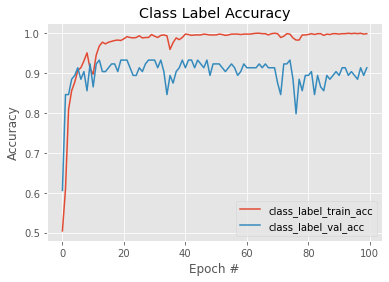

In [42]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom5_training_label_accuracy');

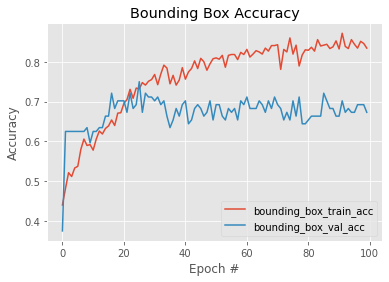

In [43]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom5_training_bounding_box_accuracy');

### Modeling - Custom6

In [44]:
# changing the proportion of dropout nodes from 0.2 to 0.5 for bounding box head

In [53]:
# creating custom model6
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom6 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom6.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom6.summary())

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_27[0][0]           
______________________________________________________________________________________

In [58]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom6.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 27s 913ms/step - loss: 0.0290 - bounding_box_loss: 0.0125 - class_label_loss: 0.0165 - bounding_box_accuracy: 0.5865 - class_label_accuracy: 0.9968 - val_loss: 0.5864 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5762 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
Epoch 2/100
30/30 [==============================] - 29s 976ms/step - loss: 0.0183 - bounding_box_loss: 0.0127 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9979 - val_loss: 0.5325 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.5222 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
Epoch 3/100
30/30 [==============================] - 30s 989ms/step - loss: 0.0165 - bounding_box_loss: 0.0124 - class_label_loss: 0.0041 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9989 - val_loss: 0.5451 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5350 - val_bou

30/30 [==============================] - 31s 1s/step - loss: 0.0179 - bounding_box_loss: 0.0104 - class_label_loss: 0.0075 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9979 - val_loss: 1.2890 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 1.2784 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8846
Epoch 48/100
30/30 [==============================] - 31s 1s/step - loss: 0.0116 - bounding_box_loss: 0.0100 - class_label_loss: 0.0016 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 1.0000 - val_loss: 1.1480 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 1.1385 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
Epoch 49/100
30/30 [==============================] - 31s 1s/step - loss: 0.0138 - bounding_box_loss: 0.0099 - class_label_loss: 0.0040 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9989 - val_loss: 0.9751 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.9653 - val_bounding_box_accuracy:

30/30 [==============================] - 32s 1s/step - loss: 0.0096 - bounding_box_loss: 0.0090 - class_label_loss: 5.6411e-04 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 1.0000 - val_loss: 0.9490 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.9394 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
Epoch 94/100
30/30 [==============================] - 32s 1s/step - loss: 0.0090 - bounding_box_loss: 0.0088 - class_label_loss: 2.8823e-04 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 1.0000 - val_loss: 0.9854 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.9755 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
Epoch 95/100
30/30 [==============================] - 31s 1s/step - loss: 0.0094 - bounding_box_loss: 0.0087 - class_label_loss: 6.6800e-04 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 1.0000 - val_loss: 0.9985 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.9886 - val_bounding_b

In [ ]:
# Epoch 1/100
# 30/30 [==============================] - 27s 913ms/step - loss: 0.0290 - bounding_box_loss: 0.0125 - class_label_loss: 0.0165 - bounding_box_accuracy: 0.5865 - class_label_accuracy: 0.9968 - val_loss: 0.5864 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5762 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 2/100
# 30/30 [==============================] - 29s 976ms/step - loss: 0.0183 - bounding_box_loss: 0.0127 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9979 - val_loss: 0.5325 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.5222 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 3/100
# 30/30 [==============================] - 30s 989ms/step - loss: 0.0165 - bounding_box_loss: 0.0124 - class_label_loss: 0.0041 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9989 - val_loss: 0.5451 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5350 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 4/100
# 30/30 [==============================] - 30s 996ms/step - loss: 0.0302 - bounding_box_loss: 0.0125 - class_label_loss: 0.0178 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9957 - val_loss: 0.5523 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.5415 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 5/100
# 30/30 [==============================] - 30s 991ms/step - loss: 0.0250 - bounding_box_loss: 0.0124 - class_label_loss: 0.0126 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9947 - val_loss: 0.5441 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.5344 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 6/100
# 30/30 [==============================] - 29s 979ms/step - loss: 0.0241 - bounding_box_loss: 0.0123 - class_label_loss: 0.0118 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.9968 - val_loss: 0.5590 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5489 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 7/100
# 30/30 [==============================] - 29s 983ms/step - loss: 0.0191 - bounding_box_loss: 0.0116 - class_label_loss: 0.0075 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9968 - val_loss: 0.6632 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.6526 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 8/100
# 30/30 [==============================] - 29s 976ms/step - loss: 0.0211 - bounding_box_loss: 0.0120 - class_label_loss: 0.0091 - bounding_box_accuracy: 0.5855 - class_label_accuracy: 0.9947 - val_loss: 0.6962 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.6863 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 9/100
# 30/30 [==============================] - 29s 980ms/step - loss: 0.0161 - bounding_box_loss: 0.0119 - class_label_loss: 0.0042 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.9989 - val_loss: 0.5937 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5836 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 10/100
# 30/30 [==============================] - 30s 988ms/step - loss: 0.0142 - bounding_box_loss: 0.0121 - class_label_loss: 0.0021 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 1.0000 - val_loss: 0.6202 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.6102 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 11/100
# 30/30 [==============================] - 30s 986ms/step - loss: 0.0175 - bounding_box_loss: 0.0115 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9979 - val_loss: 0.6073 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5973 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 12/100
# 30/30 [==============================] - 30s 983ms/step - loss: 0.0153 - bounding_box_loss: 0.0116 - class_label_loss: 0.0037 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9968 - val_loss: 0.7153 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.7046 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 13/100
# 30/30 [==============================] - 30s 1s/step - loss: 0.0128 - bounding_box_loss: 0.0114 - class_label_loss: 0.0015 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 1.0000 - val_loss: 0.6326 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.6228 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 14/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0202 - bounding_box_loss: 0.0118 - class_label_loss: 0.0084 - bounding_box_accuracy: 0.5833 - class_label_accuracy: 0.9979 - val_loss: 0.5719 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.5617 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 15/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0334 - bounding_box_loss: 0.0120 - class_label_loss: 0.0213 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9925 - val_loss: 0.6952 - val_bounding_box_loss: 0.0165 - val_class_label_loss: 0.6788 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 16/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0837 - bounding_box_loss: 0.0141 - class_label_loss: 0.0696 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9712 - val_loss: 0.6056 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.5943 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8846
# Epoch 17/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0380 - bounding_box_loss: 0.0119 - class_label_loss: 0.0261 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9925 - val_loss: 0.4879 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.4773 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 18/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0308 - bounding_box_loss: 0.0118 - class_label_loss: 0.0190 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9947 - val_loss: 0.7018 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.6897 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 19/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0232 - bounding_box_loss: 0.0124 - class_label_loss: 0.0108 - bounding_box_accuracy: 0.5812 - class_label_accuracy: 0.9957 - val_loss: 0.7559 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.7443 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 20/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0291 - bounding_box_loss: 0.0118 - class_label_loss: 0.0174 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9947 - val_loss: 0.5248 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.5138 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 21/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0333 - bounding_box_loss: 0.0122 - class_label_loss: 0.0211 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9936 - val_loss: 0.9577 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.9469 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 22/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0176 - bounding_box_loss: 0.0117 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9979 - val_loss: 0.8614 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.8510 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 23/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0207 - bounding_box_loss: 0.0115 - class_label_loss: 0.0092 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9968 - val_loss: 0.8353 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.8254 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 24/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0224 - bounding_box_loss: 0.0111 - class_label_loss: 0.0112 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9968 - val_loss: 0.7929 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.7832 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 25/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0321 - bounding_box_loss: 0.0115 - class_label_loss: 0.0206 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9925 - val_loss: 0.8190 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.8092 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 26/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0269 - bounding_box_loss: 0.0113 - class_label_loss: 0.0156 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9968 - val_loss: 0.7339 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.7234 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 27/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0180 - bounding_box_loss: 0.0111 - class_label_loss: 0.0070 - bounding_box_accuracy: 0.5833 - class_label_accuracy: 0.9968 - val_loss: 0.7542 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.7438 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 28/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0126 - bounding_box_loss: 0.0109 - class_label_loss: 0.0016 - bounding_box_accuracy: 0.5940 - class_label_accuracy: 1.0000 - val_loss: 0.8686 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.8584 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9327
# Epoch 29/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0331 - bounding_box_loss: 0.0107 - class_label_loss: 0.0223 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9915 - val_loss: 0.7917 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.7817 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 30/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0169 - bounding_box_loss: 0.0107 - class_label_loss: 0.0061 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9989 - val_loss: 0.7402 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.7294 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 31/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0129 - bounding_box_loss: 0.0110 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 1.0000 - val_loss: 0.8097 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.7996 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 32/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0163 - bounding_box_loss: 0.0106 - class_label_loss: 0.0056 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9979 - val_loss: 0.8385 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.8282 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 33/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0147 - bounding_box_loss: 0.0105 - class_label_loss: 0.0041 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9989 - val_loss: 0.6548 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.6442 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 34/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0192 - bounding_box_loss: 0.0108 - class_label_loss: 0.0084 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9968 - val_loss: 0.7040 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.6941 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 35/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0133 - bounding_box_loss: 0.0103 - class_label_loss: 0.0030 - bounding_box_accuracy: 0.5919 - class_label_accuracy: 0.9989 - val_loss: 0.7078 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.6979 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 36/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0154 - bounding_box_loss: 0.0107 - class_label_loss: 0.0047 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9979 - val_loss: 0.7116 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.7009 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9423
# Epoch 37/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0304 - bounding_box_loss: 0.0111 - class_label_loss: 0.0193 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.9957 - val_loss: 0.8840 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.8743 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 38/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0221 - bounding_box_loss: 0.0108 - class_label_loss: 0.0114 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9968 - val_loss: 1.3862 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 1.3763 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8750
# Epoch 39/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0194 - bounding_box_loss: 0.0105 - class_label_loss: 0.0089 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9979 - val_loss: 1.1101 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 1.0989 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 40/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0259 - bounding_box_loss: 0.0109 - class_label_loss: 0.0150 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9957 - val_loss: 0.9877 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.9780 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8846
# Epoch 41/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0128 - bounding_box_loss: 0.0102 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9989 - val_loss: 1.0267 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 1.0173 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 42/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0155 - bounding_box_loss: 0.0105 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.5919 - class_label_accuracy: 0.9989 - val_loss: 1.2146 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 1.2050 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 43/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0108 - bounding_box_loss: 0.0099 - class_label_loss: 9.3567e-04 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 1.0000 - val_loss: 1.2932 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 1.2825 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 44/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0114 - bounding_box_loss: 0.0103 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9989 - val_loss: 1.2075 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 1.1976 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 45/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0125 - bounding_box_loss: 0.0100 - class_label_loss: 0.0025 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9979 - val_loss: 1.2845 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 1.2744 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 46/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0329 - bounding_box_loss: 0.0106 - class_label_loss: 0.0223 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9989 - val_loss: 0.6013 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.5909 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 47/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0179 - bounding_box_loss: 0.0104 - class_label_loss: 0.0075 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9979 - val_loss: 1.2890 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 1.2784 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8846
# Epoch 48/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0116 - bounding_box_loss: 0.0100 - class_label_loss: 0.0016 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 1.0000 - val_loss: 1.1480 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 1.1385 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 49/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0138 - bounding_box_loss: 0.0099 - class_label_loss: 0.0040 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9989 - val_loss: 0.9751 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.9653 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 50/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0171 - bounding_box_loss: 0.0102 - class_label_loss: 0.0069 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9968 - val_loss: 0.9998 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.9904 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 51/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0116 - bounding_box_loss: 0.0098 - class_label_loss: 0.0017 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 1.0000 - val_loss: 1.0012 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.9916 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 52/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0099 - class_label_loss: 0.0042 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9989 - val_loss: 1.0523 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 1.0429 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 53/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0173 - bounding_box_loss: 0.0100 - class_label_loss: 0.0073 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9968 - val_loss: 0.8515 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.8411 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9038
# Epoch 54/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0098 - class_label_loss: 0.0043 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 1.0000 - val_loss: 1.1570 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 1.1478 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 55/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0101 - bounding_box_loss: 0.0097 - class_label_loss: 3.8641e-04 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 1.0000 - val_loss: 1.2173 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 1.2076 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 56/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0096 - class_label_loss: 4.0319e-04 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 1.0000 - val_loss: 1.2160 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 1.2064 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 57/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0097 - class_label_loss: 3.3061e-04 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 1.0000 - val_loss: 1.2424 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 1.2325 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 58/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0121 - bounding_box_loss: 0.0097 - class_label_loss: 0.0023 - bounding_box_accuracy: 0.6197 - class_label_accuracy: 0.9989 - val_loss: 1.1859 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 1.1760 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.8942
# Epoch 59/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0193 - bounding_box_loss: 0.0094 - class_label_loss: 0.0099 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9979 - val_loss: 0.8181 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.8083 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 60/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0107 - bounding_box_loss: 0.0094 - class_label_loss: 0.0013 - bounding_box_accuracy: 0.5812 - class_label_accuracy: 1.0000 - val_loss: 1.0407 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 1.0312 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8942
# Epoch 61/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0097 - bounding_box_loss: 0.0095 - class_label_loss: 2.0022e-04 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 1.0000 - val_loss: 1.0581 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 1.0485 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 62/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0106 - bounding_box_loss: 0.0096 - class_label_loss: 0.0010 - bounding_box_accuracy: 0.5962 - class_label_accuracy: 1.0000 - val_loss: 1.0855 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 1.0761 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 63/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0105 - bounding_box_loss: 0.0096 - class_label_loss: 8.1162e-04 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 1.0000 - val_loss: 0.9926 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.9831 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 64/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0098 - bounding_box_loss: 0.0095 - class_label_loss: 2.9357e-04 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 1.0000 - val_loss: 1.0044 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.9949 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 65/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0097 - bounding_box_loss: 0.0094 - class_label_loss: 2.8806e-04 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 1.0000 - val_loss: 1.1229 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 1.1131 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9038
# Epoch 66/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0094 - class_label_loss: 6.3590e-04 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 1.0000 - val_loss: 1.1779 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 1.1679 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 67/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0095 - class_label_loss: 0.0046 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9979 - val_loss: 1.4298 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 1.4193 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8750
# Epoch 68/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0230 - bounding_box_loss: 0.0098 - class_label_loss: 0.0132 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9968 - val_loss: 1.0186 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 1.0093 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 69/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0952 - bounding_box_loss: 0.0118 - class_label_loss: 0.0833 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9776 - val_loss: 0.7496 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.7375 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 70/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0229 - bounding_box_loss: 0.0104 - class_label_loss: 0.0125 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9968 - val_loss: 0.9394 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.9287 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 71/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0542 - bounding_box_loss: 0.0102 - class_label_loss: 0.0440 - bounding_box_accuracy: 0.5962 - class_label_accuracy: 0.9925 - val_loss: 0.7280 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.7144 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8365
# Epoch 72/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0939 - bounding_box_loss: 0.0111 - class_label_loss: 0.0828 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9754 - val_loss: 1.2098 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 1.1987 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8654
# Epoch 73/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0239 - bounding_box_loss: 0.0100 - class_label_loss: 0.0140 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9947 - val_loss: 0.8769 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.8657 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9038
# Epoch 74/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0190 - bounding_box_loss: 0.0100 - class_label_loss: 0.0091 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 0.9989 - val_loss: 1.0207 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 1.0105 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 75/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0115 - bounding_box_loss: 0.0095 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.5919 - class_label_accuracy: 0.9989 - val_loss: 1.0394 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 1.0286 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 76/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0175 - bounding_box_loss: 0.0099 - class_label_loss: 0.0076 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9968 - val_loss: 1.4210 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 1.4102 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8750
# Epoch 77/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0236 - bounding_box_loss: 0.0098 - class_label_loss: 0.0138 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9968 - val_loss: 1.0228 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 1.0128 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 78/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0142 - bounding_box_loss: 0.0093 - class_label_loss: 0.0049 - bounding_box_accuracy: 0.5940 - class_label_accuracy: 0.9979 - val_loss: 0.7517 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.7414 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 79/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0169 - bounding_box_loss: 0.0091 - class_label_loss: 0.0077 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9968 - val_loss: 1.0234 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 1.0139 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8846
# Epoch 80/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0171 - bounding_box_loss: 0.0093 - class_label_loss: 0.0077 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9979 - val_loss: 0.9219 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.9122 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 81/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0109 - bounding_box_loss: 0.0090 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9989 - val_loss: 1.0115 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 1.0017 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 82/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0099 - bounding_box_loss: 0.0091 - class_label_loss: 7.8124e-04 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 1.0000 - val_loss: 1.0699 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 1.0601 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9038
# Epoch 83/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0138 - bounding_box_loss: 0.0093 - class_label_loss: 0.0045 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 0.9979 - val_loss: 1.0661 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 1.0550 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9135
# Epoch 84/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0106 - bounding_box_loss: 0.0096 - class_label_loss: 0.0010 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 1.0000 - val_loss: 1.0782 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 1.0681 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 85/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0113 - bounding_box_loss: 0.0090 - class_label_loss: 0.0023 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9989 - val_loss: 0.9805 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.9702 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 86/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0099 - bounding_box_loss: 0.0091 - class_label_loss: 8.1585e-04 - bounding_box_accuracy: 0.6197 - class_label_accuracy: 1.0000 - val_loss: 1.2522 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 1.2424 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 87/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0092 - bounding_box_loss: 0.0088 - class_label_loss: 4.0020e-04 - bounding_box_accuracy: 0.6165 - class_label_accuracy: 1.0000 - val_loss: 1.3902 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 1.3801 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 88/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0097 - bounding_box_loss: 0.0089 - class_label_loss: 8.4423e-04 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 1.0000 - val_loss: 1.3302 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 1.3203 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 89/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0225 - bounding_box_loss: 0.0089 - class_label_loss: 0.0136 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9989 - val_loss: 1.0455 - val_bounding_box_loss: 0.0123 - val_class_label_loss: 1.0332 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8750
# Epoch 90/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0195 - bounding_box_loss: 0.0092 - class_label_loss: 0.0103 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9957 - val_loss: 0.9024 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.8927 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 91/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0089 - class_label_loss: 0.0012 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 1.0000 - val_loss: 1.0883 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 1.0787 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 92/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0174 - bounding_box_loss: 0.0092 - class_label_loss: 0.0082 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9968 - val_loss: 0.9233 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.9136 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 93/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0096 - bounding_box_loss: 0.0090 - class_label_loss: 5.6411e-04 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 1.0000 - val_loss: 0.9490 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.9394 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 94/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0090 - bounding_box_loss: 0.0088 - class_label_loss: 2.8823e-04 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 1.0000 - val_loss: 0.9854 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.9755 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 95/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0094 - bounding_box_loss: 0.0087 - class_label_loss: 6.6800e-04 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 1.0000 - val_loss: 0.9985 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.9886 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9038
# Epoch 96/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0101 - bounding_box_loss: 0.0090 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.6165 - class_label_accuracy: 1.0000 - val_loss: 1.0098 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.9999 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 97/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0098 - bounding_box_loss: 0.0089 - class_label_loss: 8.5235e-04 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 1.0000 - val_loss: 0.9377 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.9278 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 98/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0111 - bounding_box_loss: 0.0091 - class_label_loss: 0.0021 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9989 - val_loss: 0.9604 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.9506 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 99/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.0124 - bounding_box_loss: 0.0092 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9979 - val_loss: 0.9902 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.9800 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 100/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0097 - bounding_box_loss: 0.0091 - class_label_loss: 6.6475e-04 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 1.0000 - val_loss: 1.0537 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 1.0439 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# ​

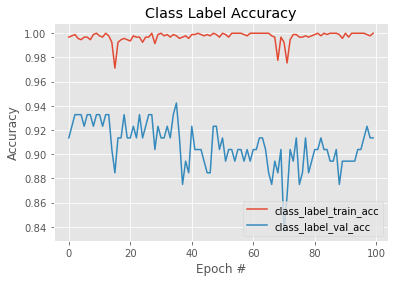

In [59]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom6_training_label_accuracy');

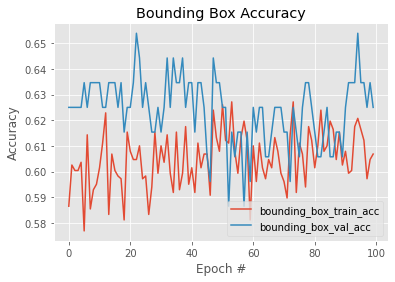

In [60]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom6_training_bounding_box_accuracy');

### Modeling - Custom7

In [ ]:
# increasing the number of nodes in dense layers in bounding box head (matching class patter)

In [61]:
# creating custom model7
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(224, activation="relu")(flat)
bbox_head2 = Dropout(0.2)(bbox_head1)
bbox_head3 = Dense(224, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.2)(bbox_head3)
bbox_head5 = Dense(224, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.2)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom7 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom7.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom7.summary())

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_30[0][0]           
______________________________________________________________________________________

In [62]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom7.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=50, verbose=1)

Epoch 1/50
30/30 [==============================] - 29s 955ms/step - loss: 1.0373 - bounding_box_loss: 0.0314 - class_label_loss: 1.0059 - bounding_box_accuracy: 0.5491 - class_label_accuracy: 0.5438 - val_loss: 0.7143 - val_bounding_box_loss: 0.0259 - val_class_label_loss: 0.6884 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4519
Epoch 2/50
30/30 [==============================] - 30s 1s/step - loss: 0.5205 - bounding_box_loss: 0.0216 - class_label_loss: 0.4989 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.7991 - val_loss: 0.4471 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.4320 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8269
Epoch 3/50
30/30 [==============================] - 31s 1s/step - loss: 0.3902 - bounding_box_loss: 0.0206 - class_label_loss: 0.3696 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.8707 - val_loss: 0.7097 - val_bounding_box_loss: 0.0205 - val_class_label_loss: 0.6892 - val_bounding_box

30/30 [==============================] - 32s 1s/step - loss: 0.0304 - bounding_box_loss: 0.0026 - class_label_loss: 0.0278 - bounding_box_accuracy: 0.8622 - class_label_accuracy: 0.9872 - val_loss: 0.8320 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.8236 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8654
Epoch 48/50
30/30 [==============================] - 32s 1s/step - loss: 0.0246 - bounding_box_loss: 0.0024 - class_label_loss: 0.0222 - bounding_box_accuracy: 0.8611 - class_label_accuracy: 0.9893 - val_loss: 0.9532 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.9456 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8654
Epoch 49/50
30/30 [==============================] - 32s 1s/step - loss: 0.0969 - bounding_box_loss: 0.0044 - class_label_loss: 0.0925 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9615 - val_loss: 0.6787 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.6682 - val_bounding_box_accuracy: 0

In [63]:
# Epoch 1/50
# 30/30 [==============================] - 29s 955ms/step - loss: 1.0373 - bounding_box_loss: 0.0314 - class_label_loss: 1.0059 - bounding_box_accuracy: 0.5491 - class_label_accuracy: 0.5438 - val_loss: 0.7143 - val_bounding_box_loss: 0.0259 - val_class_label_loss: 0.6884 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4519
# Epoch 2/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.5205 - bounding_box_loss: 0.0216 - class_label_loss: 0.4989 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.7991 - val_loss: 0.4471 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.4320 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8269
# Epoch 3/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.3902 - bounding_box_loss: 0.0206 - class_label_loss: 0.3696 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.8707 - val_loss: 0.7097 - val_bounding_box_loss: 0.0205 - val_class_label_loss: 0.6892 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7115
# Epoch 4/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.3835 - bounding_box_loss: 0.0173 - class_label_loss: 0.3661 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.8579 - val_loss: 0.4304 - val_bounding_box_loss: 0.0176 - val_class_label_loss: 0.4128 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7885
# Epoch 5/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.3213 - bounding_box_loss: 0.0185 - class_label_loss: 0.3028 - bounding_box_accuracy: 0.6357 - class_label_accuracy: 0.8953 - val_loss: 0.3229 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.3093 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 6/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.2870 - bounding_box_loss: 0.0171 - class_label_loss: 0.2699 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9081 - val_loss: 0.3128 - val_bounding_box_loss: 0.0181 - val_class_label_loss: 0.2946 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8654
# Epoch 7/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.2650 - bounding_box_loss: 0.0146 - class_label_loss: 0.2504 - bounding_box_accuracy: 0.5876 - class_label_accuracy: 0.9199 - val_loss: 0.3351 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3219 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 8/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.2346 - bounding_box_loss: 0.0122 - class_label_loss: 0.2224 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.9209 - val_loss: 0.2919 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.2821 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 9/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.2808 - bounding_box_loss: 0.0130 - class_label_loss: 0.2679 - bounding_box_accuracy: 0.6571 - class_label_accuracy: 0.8985 - val_loss: 0.3265 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.3166 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 10/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.2187 - bounding_box_loss: 0.0111 - class_label_loss: 0.2076 - bounding_box_accuracy: 0.6763 - class_label_accuracy: 0.9241 - val_loss: 0.3286 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.3185 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8942
# Epoch 11/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.1896 - bounding_box_loss: 0.0111 - class_label_loss: 0.1784 - bounding_box_accuracy: 0.7115 - class_label_accuracy: 0.9359 - val_loss: 0.7036 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.6945 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.7692
# Epoch 12/50
# 30/30 [==============================] - 30s 1s/step - loss: 0.3021 - bounding_box_loss: 0.0108 - class_label_loss: 0.2913 - bounding_box_accuracy: 0.7115 - class_label_accuracy: 0.8932 - val_loss: 0.3523 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.3437 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8942
# Epoch 13/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.2075 - bounding_box_loss: 0.0096 - class_label_loss: 0.1979 - bounding_box_accuracy: 0.7222 - class_label_accuracy: 0.9295 - val_loss: 0.3451 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.3349 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 14/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.1665 - bounding_box_loss: 0.0090 - class_label_loss: 0.1575 - bounding_box_accuracy: 0.7479 - class_label_accuracy: 0.9338 - val_loss: 0.4197 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.4102 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8365
# Epoch 15/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1714 - bounding_box_loss: 0.0085 - class_label_loss: 0.1629 - bounding_box_accuracy: 0.7425 - class_label_accuracy: 0.9370 - val_loss: 0.3069 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.2989 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 16/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1202 - bounding_box_loss: 0.0076 - class_label_loss: 0.1125 - bounding_box_accuracy: 0.7489 - class_label_accuracy: 0.9466 - val_loss: 0.3780 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.3697 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8846
# Epoch 17/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1585 - bounding_box_loss: 0.0082 - class_label_loss: 0.1503 - bounding_box_accuracy: 0.7489 - class_label_accuracy: 0.9370 - val_loss: 0.3871 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.3776 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8846
# Epoch 18/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1343 - bounding_box_loss: 0.0077 - class_label_loss: 0.1266 - bounding_box_accuracy: 0.7756 - class_label_accuracy: 0.9509 - val_loss: 0.2964 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.2876 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 19/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1060 - bounding_box_loss: 0.0069 - class_label_loss: 0.0991 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9647 - val_loss: 0.4526 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.4438 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 20/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0828 - bounding_box_loss: 0.0063 - class_label_loss: 0.0765 - bounding_box_accuracy: 0.7788 - class_label_accuracy: 0.9765 - val_loss: 0.4135 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.4051 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8558
# Epoch 21/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1007 - bounding_box_loss: 0.0064 - class_label_loss: 0.0943 - bounding_box_accuracy: 0.7906 - class_label_accuracy: 0.9669 - val_loss: 0.4234 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.4146 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8654
# Epoch 22/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0811 - bounding_box_loss: 0.0059 - class_label_loss: 0.0753 - bounding_box_accuracy: 0.8034 - class_label_accuracy: 0.9754 - val_loss: 0.4660 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.4574 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 23/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0970 - bounding_box_loss: 0.0069 - class_label_loss: 0.0901 - bounding_box_accuracy: 0.7874 - class_label_accuracy: 0.9733 - val_loss: 0.4416 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.4340 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8654
# Epoch 24/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0749 - bounding_box_loss: 0.0050 - class_label_loss: 0.0699 - bounding_box_accuracy: 0.7959 - class_label_accuracy: 0.9754 - val_loss: 0.4176 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.4104 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 25/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0760 - bounding_box_loss: 0.0049 - class_label_loss: 0.0710 - bounding_box_accuracy: 0.8045 - class_label_accuracy: 0.9786 - val_loss: 0.3604 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.3534 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 26/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0651 - bounding_box_loss: 0.0053 - class_label_loss: 0.0598 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 0.9818 - val_loss: 0.8240 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.8154 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 27/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1823 - bounding_box_loss: 0.0057 - class_label_loss: 0.1766 - bounding_box_accuracy: 0.7799 - class_label_accuracy: 0.9412 - val_loss: 0.4708 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.4603 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8365
# Epoch 28/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.1031 - bounding_box_loss: 0.0071 - class_label_loss: 0.0960 - bounding_box_accuracy: 0.7767 - class_label_accuracy: 0.9647 - val_loss: 0.5178 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.5049 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8654
# Epoch 29/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0760 - bounding_box_loss: 0.0050 - class_label_loss: 0.0711 - bounding_box_accuracy: 0.7927 - class_label_accuracy: 0.9754 - val_loss: 0.5447 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.5364 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8750
# Epoch 30/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0555 - bounding_box_loss: 0.0043 - class_label_loss: 0.0512 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 0.9797 - val_loss: 0.4925 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4852 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 31/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0505 - bounding_box_loss: 0.0040 - class_label_loss: 0.0465 - bounding_box_accuracy: 0.8216 - class_label_accuracy: 0.9850 - val_loss: 0.5614 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.5515 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8846
# Epoch 32/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0413 - bounding_box_loss: 0.0041 - class_label_loss: 0.0372 - bounding_box_accuracy: 0.8301 - class_label_accuracy: 0.9882 - val_loss: 0.6144 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.6068 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 33/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0427 - bounding_box_loss: 0.0038 - class_label_loss: 0.0388 - bounding_box_accuracy: 0.8429 - class_label_accuracy: 0.9840 - val_loss: 0.5981 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.5905 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 34/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0614 - bounding_box_loss: 0.0034 - class_label_loss: 0.0580 - bounding_box_accuracy: 0.8291 - class_label_accuracy: 0.9829 - val_loss: 0.6192 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.6107 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8654
# Epoch 35/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0877 - bounding_box_loss: 0.0049 - class_label_loss: 0.0828 - bounding_box_accuracy: 0.8205 - class_label_accuracy: 0.9690 - val_loss: 0.4439 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.4337 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8558
# Epoch 36/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0603 - bounding_box_loss: 0.0048 - class_label_loss: 0.0555 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 0.9808 - val_loss: 0.5937 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.5861 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
# Epoch 37/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0378 - bounding_box_loss: 0.0035 - class_label_loss: 0.0343 - bounding_box_accuracy: 0.8194 - class_label_accuracy: 0.9882 - val_loss: 0.5990 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.5915 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8942
# Epoch 38/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0416 - bounding_box_loss: 0.0031 - class_label_loss: 0.0385 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9818 - val_loss: 0.5618 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.5545 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8750
# Epoch 39/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0408 - bounding_box_loss: 0.0031 - class_label_loss: 0.0377 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.9893 - val_loss: 0.5244 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.5164 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 40/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0369 - bounding_box_loss: 0.0027 - class_label_loss: 0.0342 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9872 - val_loss: 0.6872 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6793 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8654
# Epoch 41/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0325 - bounding_box_loss: 0.0029 - class_label_loss: 0.0296 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9925 - val_loss: 0.5699 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.5622 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 42/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0327 - bounding_box_loss: 0.0031 - class_label_loss: 0.0296 - bounding_box_accuracy: 0.8429 - class_label_accuracy: 0.9882 - val_loss: 0.7211 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.7128 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8558
# Epoch 43/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0171 - bounding_box_loss: 0.0028 - class_label_loss: 0.0144 - bounding_box_accuracy: 0.8440 - class_label_accuracy: 0.9947 - val_loss: 0.8245 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.8171 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8846
# Epoch 44/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0354 - bounding_box_loss: 0.0028 - class_label_loss: 0.0326 - bounding_box_accuracy: 0.8632 - class_label_accuracy: 0.9861 - val_loss: 0.6162 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.6090 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8654
# Epoch 45/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0323 - bounding_box_loss: 0.0027 - class_label_loss: 0.0297 - bounding_box_accuracy: 0.8558 - class_label_accuracy: 0.9915 - val_loss: 0.6708 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6629 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8846
# Epoch 46/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0329 - bounding_box_loss: 0.0028 - class_label_loss: 0.0302 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9872 - val_loss: 0.6614 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.6527 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8846
# Epoch 47/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0304 - bounding_box_loss: 0.0026 - class_label_loss: 0.0278 - bounding_box_accuracy: 0.8622 - class_label_accuracy: 0.9872 - val_loss: 0.8320 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.8236 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8654
# Epoch 48/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0246 - bounding_box_loss: 0.0024 - class_label_loss: 0.0222 - bounding_box_accuracy: 0.8611 - class_label_accuracy: 0.9893 - val_loss: 0.9532 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.9456 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8654
# Epoch 49/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0969 - bounding_box_loss: 0.0044 - class_label_loss: 0.0925 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9615 - val_loss: 0.6787 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.6682 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8173
# Epoch 50/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.0441 - bounding_box_loss: 0.0035 - class_label_loss: 0.0406 - bounding_box_accuracy: 0.8590 - class_label_accuracy: 0.9850 - val_loss: 0.8040 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.7939 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8750


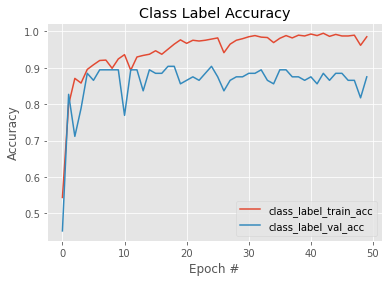

In [64]:
# plotting the class label accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom7_training_label_accuracy');

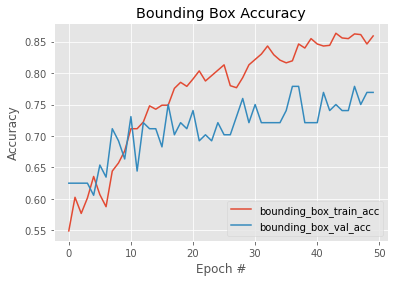

In [65]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom7_training_bounding_box_accuracy');

### Modeling - Custom8

In [66]:
# increasing the proportion of dropout layers in boundary box head

In [67]:
# creating custom model8
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(224, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(224, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(224, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom8 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom8.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom8.summary())

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_33[0][0]           
______________________________________________________________________________________

In [68]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom8.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=50, verbose=1)

Epoch 1/50
30/30 [==============================] - 29s 957ms/step - loss: 0.8482 - bounding_box_loss: 0.0388 - class_label_loss: 0.8094 - bounding_box_accuracy: 0.5171 - class_label_accuracy: 0.5342 - val_loss: 0.6529 - val_bounding_box_loss: 0.0152 - val_class_label_loss: 0.6376 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7404
Epoch 2/50
30/30 [==============================] - 31s 1s/step - loss: 0.6185 - bounding_box_loss: 0.0276 - class_label_loss: 0.5909 - bounding_box_accuracy: 0.5417 - class_label_accuracy: 0.7147 - val_loss: 0.6074 - val_bounding_box_loss: 0.0154 - val_class_label_loss: 0.5920 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6923
Epoch 3/50
30/30 [==============================] - 31s 1s/step - loss: 0.4412 - bounding_box_loss: 0.0206 - class_label_loss: 0.4206 - bounding_box_accuracy: 0.5566 - class_label_accuracy: 0.8387 - val_loss: 0.4710 - val_bounding_box_loss: 0.0185 - val_class_label_loss: 0.4526 - val_bounding_box

30/30 [==============================] - 33s 1s/step - loss: 0.0202 - bounding_box_loss: 0.0082 - class_label_loss: 0.0120 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9947 - val_loss: 1.3889 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 1.3802 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8654
Epoch 48/50
30/30 [==============================] - 33s 1s/step - loss: 0.0205 - bounding_box_loss: 0.0082 - class_label_loss: 0.0123 - bounding_box_accuracy: 0.7179 - class_label_accuracy: 0.9968 - val_loss: 1.2691 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.2608 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
Epoch 49/50
30/30 [==============================] - 33s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0077 - class_label_loss: 0.0064 - bounding_box_accuracy: 0.6816 - class_label_accuracy: 0.9979 - val_loss: 1.4194 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.4110 - val_bounding_box_accuracy: 0

In [69]:
# Epoch 1/50
# 30/30 [==============================] - 29s 957ms/step - loss: 0.8482 - bounding_box_loss: 0.0388 - class_label_loss: 0.8094 - bounding_box_accuracy: 0.5171 - class_label_accuracy: 0.5342 - val_loss: 0.6529 - val_bounding_box_loss: 0.0152 - val_class_label_loss: 0.6376 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7404
# Epoch 2/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.6185 - bounding_box_loss: 0.0276 - class_label_loss: 0.5909 - bounding_box_accuracy: 0.5417 - class_label_accuracy: 0.7147 - val_loss: 0.6074 - val_bounding_box_loss: 0.0154 - val_class_label_loss: 0.5920 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6923
# Epoch 3/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.4412 - bounding_box_loss: 0.0206 - class_label_loss: 0.4206 - bounding_box_accuracy: 0.5566 - class_label_accuracy: 0.8387 - val_loss: 0.4710 - val_bounding_box_loss: 0.0185 - val_class_label_loss: 0.4526 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7981
# Epoch 4/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.4387 - bounding_box_loss: 0.0186 - class_label_loss: 0.4201 - bounding_box_accuracy: 0.5534 - class_label_accuracy: 0.8323 - val_loss: 0.4404 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.4256 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8269
# Epoch 5/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.3702 - bounding_box_loss: 0.0183 - class_label_loss: 0.3518 - bounding_box_accuracy: 0.5577 - class_label_accuracy: 0.8782 - val_loss: 0.4005 - val_bounding_box_loss: 0.0153 - val_class_label_loss: 0.3853 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 6/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.3386 - bounding_box_loss: 0.0178 - class_label_loss: 0.3209 - bounding_box_accuracy: 0.5513 - class_label_accuracy: 0.8878 - val_loss: 0.3468 - val_bounding_box_loss: 0.0158 - val_class_label_loss: 0.3310 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 7/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.3610 - bounding_box_loss: 0.0174 - class_label_loss: 0.3436 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.8761 - val_loss: 0.3392 - val_bounding_box_loss: 0.0130 - val_class_label_loss: 0.3262 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 8/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.3672 - bounding_box_loss: 0.0167 - class_label_loss: 0.3505 - bounding_box_accuracy: 0.5609 - class_label_accuracy: 0.8846 - val_loss: 0.3522 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.3365 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 9/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.3569 - bounding_box_loss: 0.0160 - class_label_loss: 0.3408 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.8857 - val_loss: 0.3307 - val_bounding_box_loss: 0.0161 - val_class_label_loss: 0.3146 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 10/50
# 30/30 [==============================] - 31s 1s/step - loss: 0.2959 - bounding_box_loss: 0.0157 - class_label_loss: 0.2802 - bounding_box_accuracy: 0.5609 - class_label_accuracy: 0.9081 - val_loss: 0.3860 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.3724 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8269
# Epoch 11/50
# 30/30 [==============================] - 32s 1s/step - loss: 0.2870 - bounding_box_loss: 0.0161 - class_label_loss: 0.2710 - bounding_box_accuracy: 0.5716 - class_label_accuracy: 0.9199 - val_loss: 0.3624 - val_bounding_box_loss: 0.0128 - val_class_label_loss: 0.3496 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 12/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.2774 - bounding_box_loss: 0.0159 - class_label_loss: 0.2615 - bounding_box_accuracy: 0.5940 - class_label_accuracy: 0.9167 - val_loss: 0.3448 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.3315 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 13/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.2139 - bounding_box_loss: 0.0151 - class_label_loss: 0.1988 - bounding_box_accuracy: 0.5481 - class_label_accuracy: 0.9348 - val_loss: 0.4345 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.4228 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 14/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.1995 - bounding_box_loss: 0.0147 - class_label_loss: 0.1848 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9466 - val_loss: 0.3619 - val_bounding_box_loss: 0.0118 - val_class_label_loss: 0.3501 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 15/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.1520 - bounding_box_loss: 0.0139 - class_label_loss: 0.1381 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.9669 - val_loss: 0.5462 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.5353 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 16/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.1167 - bounding_box_loss: 0.0142 - class_label_loss: 0.1025 - bounding_box_accuracy: 0.5833 - class_label_accuracy: 0.9701 - val_loss: 0.4031 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.3916 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 17/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.1187 - bounding_box_loss: 0.0135 - class_label_loss: 0.1052 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9701 - val_loss: 0.3942 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.3837 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 18/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.1133 - bounding_box_loss: 0.0130 - class_label_loss: 0.1003 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9754 - val_loss: 0.5865 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.5718 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9038
# Epoch 19/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.1289 - bounding_box_loss: 0.0133 - class_label_loss: 0.1157 - bounding_box_accuracy: 0.5705 - class_label_accuracy: 0.9615 - val_loss: 0.3695 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.3585 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 20/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0904 - bounding_box_loss: 0.0126 - class_label_loss: 0.0778 - bounding_box_accuracy: 0.5865 - class_label_accuracy: 0.9754 - val_loss: 0.5825 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.5720 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 21/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0776 - bounding_box_loss: 0.0116 - class_label_loss: 0.0660 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9808 - val_loss: 0.5694 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.5559 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9135
# Epoch 22/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0645 - bounding_box_loss: 0.0117 - class_label_loss: 0.0529 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.9829 - val_loss: 0.7307 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.7196 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 23/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0664 - bounding_box_loss: 0.0117 - class_label_loss: 0.0546 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9786 - val_loss: 0.6808 - val_bounding_box_loss: 0.0118 - val_class_label_loss: 0.6690 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9135
# Epoch 24/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0556 - bounding_box_loss: 0.0115 - class_label_loss: 0.0441 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9850 - val_loss: 0.6393 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.6297 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 25/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0560 - bounding_box_loss: 0.0109 - class_label_loss: 0.0451 - bounding_box_accuracy: 0.5962 - class_label_accuracy: 0.9850 - val_loss: 0.8420 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.8305 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 26/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0404 - bounding_box_loss: 0.0106 - class_label_loss: 0.0298 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 0.9850 - val_loss: 0.8485 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.8392 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 27/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0451 - bounding_box_loss: 0.0102 - class_label_loss: 0.0350 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9861 - val_loss: 0.8327 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.8228 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 28/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0453 - bounding_box_loss: 0.0099 - class_label_loss: 0.0354 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.9882 - val_loss: 0.7631 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.7526 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 29/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0420 - bounding_box_loss: 0.0097 - class_label_loss: 0.0323 - bounding_box_accuracy: 0.6325 - class_label_accuracy: 0.9872 - val_loss: 0.9225 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.9124 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 30/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0316 - bounding_box_loss: 0.0098 - class_label_loss: 0.0218 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9872 - val_loss: 1.0110 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 1.0023 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 31/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0287 - bounding_box_loss: 0.0096 - class_label_loss: 0.0191 - bounding_box_accuracy: 0.6421 - class_label_accuracy: 0.9915 - val_loss: 1.3354 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 1.3242 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 32/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0595 - bounding_box_loss: 0.0101 - class_label_loss: 0.0494 - bounding_box_accuracy: 0.6549 - class_label_accuracy: 0.9818 - val_loss: 1.2248 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 1.2159 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8654
# Epoch 33/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0541 - bounding_box_loss: 0.0098 - class_label_loss: 0.0443 - bounding_box_accuracy: 0.6624 - class_label_accuracy: 0.9797 - val_loss: 1.0422 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 1.0329 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 34/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0414 - bounding_box_loss: 0.0094 - class_label_loss: 0.0320 - bounding_box_accuracy: 0.6667 - class_label_accuracy: 0.9872 - val_loss: 1.1994 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 1.1895 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8846
# Epoch 35/50
# 30/30 [==============================] - 34s 1s/step - loss: 0.0502 - bounding_box_loss: 0.0089 - class_label_loss: 0.0413 - bounding_box_accuracy: 0.6635 - class_label_accuracy: 0.9850 - val_loss: 0.7375 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.7280 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135
# Epoch 36/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0511 - bounding_box_loss: 0.0091 - class_label_loss: 0.0420 - bounding_box_accuracy: 0.6677 - class_label_accuracy: 0.9840 - val_loss: 1.0490 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 1.0369 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8846
# Epoch 37/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0467 - bounding_box_loss: 0.0104 - class_label_loss: 0.0363 - bounding_box_accuracy: 0.6699 - class_label_accuracy: 0.9861 - val_loss: 0.9538 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.9443 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8942
# Epoch 38/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0238 - bounding_box_loss: 0.0088 - class_label_loss: 0.0150 - bounding_box_accuracy: 0.6806 - class_label_accuracy: 0.9936 - val_loss: 1.1099 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.1009 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8846
# Epoch 39/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0328 - bounding_box_loss: 0.0086 - class_label_loss: 0.0242 - bounding_box_accuracy: 0.6880 - class_label_accuracy: 0.9915 - val_loss: 0.8896 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.8792 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9038
# Epoch 40/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0277 - bounding_box_loss: 0.0085 - class_label_loss: 0.0192 - bounding_box_accuracy: 0.6453 - class_label_accuracy: 0.9915 - val_loss: 1.1741 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 1.1647 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 41/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0344 - bounding_box_loss: 0.0085 - class_label_loss: 0.0259 - bounding_box_accuracy: 0.6635 - class_label_accuracy: 0.9915 - val_loss: 1.3870 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 1.3765 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8846
# Epoch 42/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0301 - bounding_box_loss: 0.0085 - class_label_loss: 0.0216 - bounding_box_accuracy: 0.6635 - class_label_accuracy: 0.9904 - val_loss: 0.8888 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.8801 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 43/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0317 - bounding_box_loss: 0.0091 - class_label_loss: 0.0226 - bounding_box_accuracy: 0.6795 - class_label_accuracy: 0.9925 - val_loss: 1.6061 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 1.5968 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 44/50
# 30/30 [==============================] - 34s 1s/step - loss: 0.0286 - bounding_box_loss: 0.0084 - class_label_loss: 0.0202 - bounding_box_accuracy: 0.6774 - class_label_accuracy: 0.9925 - val_loss: 0.9475 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.9382 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8654
# Epoch 45/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0352 - bounding_box_loss: 0.0092 - class_label_loss: 0.0259 - bounding_box_accuracy: 0.6667 - class_label_accuracy: 0.9893 - val_loss: 1.4603 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.4520 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 46/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0242 - bounding_box_loss: 0.0086 - class_label_loss: 0.0156 - bounding_box_accuracy: 0.6870 - class_label_accuracy: 0.9947 - val_loss: 1.2143 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 1.2058 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 47/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0202 - bounding_box_loss: 0.0082 - class_label_loss: 0.0120 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9947 - val_loss: 1.3889 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 1.3802 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8654
# Epoch 48/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0205 - bounding_box_loss: 0.0082 - class_label_loss: 0.0123 - bounding_box_accuracy: 0.7179 - class_label_accuracy: 0.9968 - val_loss: 1.2691 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.2608 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 49/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0077 - class_label_loss: 0.0064 - bounding_box_accuracy: 0.6816 - class_label_accuracy: 0.9979 - val_loss: 1.4194 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.4110 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8654
# Epoch 50/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.0225 - bounding_box_loss: 0.0077 - class_label_loss: 0.0148 - bounding_box_accuracy: 0.7265 - class_label_accuracy: 0.9968 - val_loss: 1.3292 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.3209 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8654
# ​


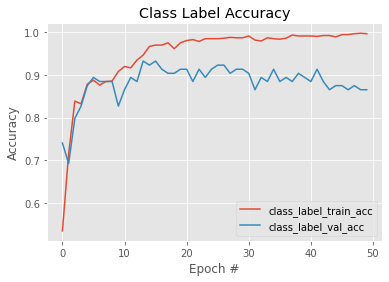

In [70]:
# plotting the class label accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom8_training_label_accuracy');

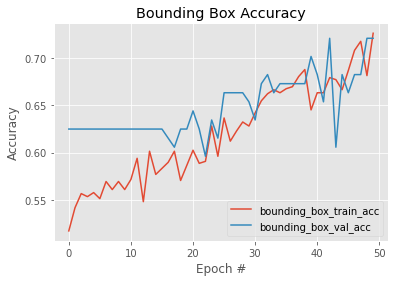

In [71]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom8_training_bounding_box_accuracy');

### Modeling - Custom9

In [72]:
# increasing the epochs to 100

In [73]:
# creating custom model9
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(224, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(224, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(224, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom9 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom9.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom9.summary())

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_36[0][0]           
______________________________________________________________________________________

In [74]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom9.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 29s 964ms/step - loss: 0.7622 - bounding_box_loss: 0.0503 - class_label_loss: 0.7120 - bounding_box_accuracy: 0.4915 - class_label_accuracy: 0.5534 - val_loss: 0.7743 - val_bounding_box_loss: 0.0175 - val_class_label_loss: 0.7568 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4423
Epoch 2/100
30/30 [==============================] - 31s 1s/step - loss: 0.5681 - bounding_box_loss: 0.0253 - class_label_loss: 0.5429 - bounding_box_accuracy: 0.5481 - class_label_accuracy: 0.7628 - val_loss: 0.4172 - val_bounding_box_loss: 0.0227 - val_class_label_loss: 0.3945 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
Epoch 3/100
30/30 [==============================] - 31s 1s/step - loss: 0.4277 - bounding_box_loss: 0.0209 - class_label_loss: 0.4068 - bounding_box_accuracy: 0.5395 - class_label_accuracy: 0.8558 - val_loss: 0.4344 - val_bounding_box_loss: 0.0199 - val_class_label_loss: 0.4145 - val_bounding_

30/30 [==============================] - 34s 1s/step - loss: 0.0287 - bounding_box_loss: 0.0083 - class_label_loss: 0.0204 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 0.9925 - val_loss: 0.9281 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.9141 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8750
Epoch 48/100
30/30 [==============================] - 34s 1s/step - loss: 0.0211 - bounding_box_loss: 0.0082 - class_label_loss: 0.0129 - bounding_box_accuracy: 0.7137 - class_label_accuracy: 0.9968 - val_loss: 1.0944 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 1.0832 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8750
Epoch 49/100
30/30 [==============================] - 34s 1s/step - loss: 0.0214 - bounding_box_loss: 0.0084 - class_label_loss: 0.0130 - bounding_box_accuracy: 0.7179 - class_label_accuracy: 0.9957 - val_loss: 1.4356 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 1.4252 - val_bounding_box_accuracy:

30/30 [==============================] - 32s 1s/step - loss: 0.0145 - bounding_box_loss: 0.0057 - class_label_loss: 0.0088 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9947 - val_loss: 1.4195 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 1.4099 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8558
Epoch 94/100
30/30 [==============================] - 32s 1s/step - loss: 0.0134 - bounding_box_loss: 0.0055 - class_label_loss: 0.0079 - bounding_box_accuracy: 0.7799 - class_label_accuracy: 0.9979 - val_loss: 1.6158 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 1.6060 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8558
Epoch 95/100
30/30 [==============================] - 32s 1s/step - loss: 0.0070 - bounding_box_loss: 0.0053 - class_label_loss: 0.0017 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 1.0000 - val_loss: 1.5381 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 1.5286 - val_bounding_box_accuracy:

In [75]:
# Epoch 1/100
# 30/30 [==============================] - 29s 964ms/step - loss: 0.7622 - bounding_box_loss: 0.0503 - class_label_loss: 0.7120 - bounding_box_accuracy: 0.4915 - class_label_accuracy: 0.5534 - val_loss: 0.7743 - val_bounding_box_loss: 0.0175 - val_class_label_loss: 0.7568 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.4423
# Epoch 2/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.5681 - bounding_box_loss: 0.0253 - class_label_loss: 0.5429 - bounding_box_accuracy: 0.5481 - class_label_accuracy: 0.7628 - val_loss: 0.4172 - val_bounding_box_loss: 0.0227 - val_class_label_loss: 0.3945 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 3/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.4277 - bounding_box_loss: 0.0209 - class_label_loss: 0.4068 - bounding_box_accuracy: 0.5395 - class_label_accuracy: 0.8558 - val_loss: 0.4344 - val_bounding_box_loss: 0.0199 - val_class_label_loss: 0.4145 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 4/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.4410 - bounding_box_loss: 0.0196 - class_label_loss: 0.4213 - bounding_box_accuracy: 0.5288 - class_label_accuracy: 0.8376 - val_loss: 0.3976 - val_bounding_box_loss: 0.0164 - val_class_label_loss: 0.3813 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 5/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.3470 - bounding_box_loss: 0.0177 - class_label_loss: 0.3293 - bounding_box_accuracy: 0.5534 - class_label_accuracy: 0.8803 - val_loss: 0.3685 - val_bounding_box_loss: 0.0153 - val_class_label_loss: 0.3532 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 6/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.2884 - bounding_box_loss: 0.0168 - class_label_loss: 0.2716 - bounding_box_accuracy: 0.5566 - class_label_accuracy: 0.9038 - val_loss: 0.3011 - val_bounding_box_loss: 0.0173 - val_class_label_loss: 0.2838 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 7/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.2487 - bounding_box_loss: 0.0163 - class_label_loss: 0.2324 - bounding_box_accuracy: 0.5823 - class_label_accuracy: 0.9156 - val_loss: 0.2709 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.2597 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 8/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.2701 - bounding_box_loss: 0.0159 - class_label_loss: 0.2542 - bounding_box_accuracy: 0.5449 - class_label_accuracy: 0.9145 - val_loss: 0.4250 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.4130 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
# Epoch 9/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.2587 - bounding_box_loss: 0.0159 - class_label_loss: 0.2428 - bounding_box_accuracy: 0.5673 - class_label_accuracy: 0.9135 - val_loss: 0.2937 - val_bounding_box_loss: 0.0148 - val_class_label_loss: 0.2789 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 10/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.1842 - bounding_box_loss: 0.0147 - class_label_loss: 0.1694 - bounding_box_accuracy: 0.5919 - class_label_accuracy: 0.9509 - val_loss: 0.3165 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.3030 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 11/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.1710 - bounding_box_loss: 0.0140 - class_label_loss: 0.1570 - bounding_box_accuracy: 0.5566 - class_label_accuracy: 0.9562 - val_loss: 0.5666 - val_bounding_box_loss: 0.0164 - val_class_label_loss: 0.5503 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 12/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1416 - bounding_box_loss: 0.0141 - class_label_loss: 0.1274 - bounding_box_accuracy: 0.5577 - class_label_accuracy: 0.9594 - val_loss: 0.3651 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.3545 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 13/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.1133 - bounding_box_loss: 0.0135 - class_label_loss: 0.0998 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9722 - val_loss: 0.5016 - val_bounding_box_loss: 0.0118 - val_class_label_loss: 0.4898 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9423
# Epoch 14/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0854 - bounding_box_loss: 0.0128 - class_label_loss: 0.0726 - bounding_box_accuracy: 0.5684 - class_label_accuracy: 0.9776 - val_loss: 0.8775 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.8655 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8558
# Epoch 15/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0954 - bounding_box_loss: 0.0131 - class_label_loss: 0.0823 - bounding_box_accuracy: 0.6090 - class_label_accuracy: 0.9712 - val_loss: 0.5667 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.5571 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9135
# Epoch 16/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0715 - bounding_box_loss: 0.0121 - class_label_loss: 0.0594 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9776 - val_loss: 0.5875 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.5741 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 17/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0685 - bounding_box_loss: 0.0118 - class_label_loss: 0.0568 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9818 - val_loss: 0.6226 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.6118 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8750
# Epoch 18/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0500 - bounding_box_loss: 0.0117 - class_label_loss: 0.0383 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9893 - val_loss: 0.6141 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.6045 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 19/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0671 - bounding_box_loss: 0.0122 - class_label_loss: 0.0548 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.9829 - val_loss: 0.7183 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 0.7063 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.8942
# Epoch 20/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0460 - bounding_box_loss: 0.0117 - class_label_loss: 0.0343 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9840 - val_loss: 0.7804 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.7708 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 21/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0592 - bounding_box_loss: 0.0110 - class_label_loss: 0.0482 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9840 - val_loss: 0.8208 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.8098 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8654
# Epoch 22/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0702 - bounding_box_loss: 0.0115 - class_label_loss: 0.0587 - bounding_box_accuracy: 0.6197 - class_label_accuracy: 0.9808 - val_loss: 0.7463 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.7377 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8846
# Epoch 23/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0440 - bounding_box_loss: 0.0112 - class_label_loss: 0.0328 - bounding_box_accuracy: 0.6165 - class_label_accuracy: 0.9882 - val_loss: 0.7932 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.7831 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 24/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0782 - bounding_box_loss: 0.0108 - class_label_loss: 0.0674 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.9829 - val_loss: 0.7369 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.7264 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8846
# Epoch 25/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0630 - bounding_box_loss: 0.0104 - class_label_loss: 0.0526 - bounding_box_accuracy: 0.5844 - class_label_accuracy: 0.9882 - val_loss: 0.5314 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.5214 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 26/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0423 - bounding_box_loss: 0.0099 - class_label_loss: 0.0324 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9882 - val_loss: 0.6858 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.6769 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 27/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0378 - bounding_box_loss: 0.0101 - class_label_loss: 0.0276 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.9872 - val_loss: 0.7641 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.7551 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 28/100
# 30/30 [==============================] - 44s 1s/step - loss: 0.0283 - bounding_box_loss: 0.0100 - class_label_loss: 0.0183 - bounding_box_accuracy: 0.6538 - class_label_accuracy: 0.9936 - val_loss: 0.7050 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.6941 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 29/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0311 - bounding_box_loss: 0.0096 - class_label_loss: 0.0215 - bounding_box_accuracy: 0.6517 - class_label_accuracy: 0.9957 - val_loss: 0.5859 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5758 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 30/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0228 - bounding_box_loss: 0.0092 - class_label_loss: 0.0136 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.9936 - val_loss: 0.9679 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.9589 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9038
# Epoch 31/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0351 - bounding_box_loss: 0.0096 - class_label_loss: 0.0255 - bounding_box_accuracy: 0.6571 - class_label_accuracy: 0.9904 - val_loss: 0.5441 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.5340 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 32/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0289 - bounding_box_loss: 0.0088 - class_label_loss: 0.0201 - bounding_box_accuracy: 0.6528 - class_label_accuracy: 0.9925 - val_loss: 0.5552 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.5446 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 33/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0291 - bounding_box_loss: 0.0088 - class_label_loss: 0.0204 - bounding_box_accuracy: 0.6741 - class_label_accuracy: 0.9915 - val_loss: 0.6881 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.6786 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 34/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0173 - bounding_box_loss: 0.0085 - class_label_loss: 0.0087 - bounding_box_accuracy: 0.6731 - class_label_accuracy: 0.9979 - val_loss: 0.7604 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.7498 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
# Epoch 35/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0170 - bounding_box_loss: 0.0083 - class_label_loss: 0.0087 - bounding_box_accuracy: 0.6784 - class_label_accuracy: 0.9957 - val_loss: 0.6862 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.6759 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135
# Epoch 36/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0185 - bounding_box_loss: 0.0086 - class_label_loss: 0.0099 - bounding_box_accuracy: 0.6752 - class_label_accuracy: 0.9968 - val_loss: 1.0759 - val_bounding_box_loss: 0.0121 - val_class_label_loss: 1.0638 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135
# Epoch 37/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0594 - bounding_box_loss: 0.0102 - class_label_loss: 0.0492 - bounding_box_accuracy: 0.6667 - class_label_accuracy: 0.9840 - val_loss: 0.7394 - val_bounding_box_loss: 0.0139 - val_class_label_loss: 0.7255 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8750
# Epoch 38/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0361 - bounding_box_loss: 0.0095 - class_label_loss: 0.0265 - bounding_box_accuracy: 0.6816 - class_label_accuracy: 0.9893 - val_loss: 0.9219 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.9095 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.8558
# Epoch 39/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0190 - bounding_box_loss: 0.0089 - class_label_loss: 0.0101 - bounding_box_accuracy: 0.6870 - class_label_accuracy: 0.9968 - val_loss: 0.7997 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.7887 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8654
# Epoch 40/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0251 - bounding_box_loss: 0.0086 - class_label_loss: 0.0165 - bounding_box_accuracy: 0.6763 - class_label_accuracy: 0.9925 - val_loss: 0.9932 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.9836 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8750
# Epoch 41/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0249 - bounding_box_loss: 0.0084 - class_label_loss: 0.0166 - bounding_box_accuracy: 0.7340 - class_label_accuracy: 0.9957 - val_loss: 1.0690 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.0606 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8654
# Epoch 42/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0260 - bounding_box_loss: 0.0085 - class_label_loss: 0.0175 - bounding_box_accuracy: 0.7212 - class_label_accuracy: 0.9936 - val_loss: 1.0797 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 1.0696 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8750
# Epoch 43/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0379 - bounding_box_loss: 0.0085 - class_label_loss: 0.0294 - bounding_box_accuracy: 0.7009 - class_label_accuracy: 0.9893 - val_loss: 2.1966 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 2.1864 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.7596
# Epoch 44/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1852 - bounding_box_loss: 0.0118 - class_label_loss: 0.1735 - bounding_box_accuracy: 0.6667 - class_label_accuracy: 0.9476 - val_loss: 0.8921 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.8778 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8558
# Epoch 45/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0417 - bounding_box_loss: 0.0088 - class_label_loss: 0.0329 - bounding_box_accuracy: 0.7094 - class_label_accuracy: 0.9904 - val_loss: 0.7857 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.7750 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8750
# Epoch 46/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0331 - bounding_box_loss: 0.0081 - class_label_loss: 0.0250 - bounding_box_accuracy: 0.7233 - class_label_accuracy: 0.9925 - val_loss: 0.6943 - val_bounding_box_loss: 0.0147 - val_class_label_loss: 0.6795 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 47/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0287 - bounding_box_loss: 0.0083 - class_label_loss: 0.0204 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 0.9925 - val_loss: 0.9281 - val_bounding_box_loss: 0.0140 - val_class_label_loss: 0.9141 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8750
# Epoch 48/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0211 - bounding_box_loss: 0.0082 - class_label_loss: 0.0129 - bounding_box_accuracy: 0.7137 - class_label_accuracy: 0.9968 - val_loss: 1.0944 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 1.0832 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8750
# Epoch 49/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0214 - bounding_box_loss: 0.0084 - class_label_loss: 0.0130 - bounding_box_accuracy: 0.7179 - class_label_accuracy: 0.9957 - val_loss: 1.4356 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 1.4252 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8846
# Epoch 50/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0149 - bounding_box_loss: 0.0080 - class_label_loss: 0.0069 - bounding_box_accuracy: 0.7361 - class_label_accuracy: 0.9989 - val_loss: 1.0915 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 1.0803 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8846
# Epoch 51/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0163 - bounding_box_loss: 0.0077 - class_label_loss: 0.0086 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9968 - val_loss: 1.1260 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 1.1153 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8942
# Epoch 52/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0134 - bounding_box_loss: 0.0074 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.7596 - class_label_accuracy: 0.9957 - val_loss: 1.1673 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 1.1571 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8846
# Epoch 53/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0207 - bounding_box_loss: 0.0071 - class_label_loss: 0.0135 - bounding_box_accuracy: 0.7329 - class_label_accuracy: 0.9989 - val_loss: 1.0108 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 1.0016 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8654
# Epoch 54/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0149 - bounding_box_loss: 0.0073 - class_label_loss: 0.0077 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 0.9979 - val_loss: 1.2154 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 1.2053 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8846
# Epoch 55/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0147 - bounding_box_loss: 0.0071 - class_label_loss: 0.0075 - bounding_box_accuracy: 0.7308 - class_label_accuracy: 0.9957 - val_loss: 1.1952 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 1.1842 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 56/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0156 - bounding_box_loss: 0.0075 - class_label_loss: 0.0081 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9979 - val_loss: 1.1148 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 1.1043 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8654
# Epoch 57/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0129 - bounding_box_loss: 0.0073 - class_label_loss: 0.0056 - bounding_box_accuracy: 0.7404 - class_label_accuracy: 0.9968 - val_loss: 1.2381 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 1.2275 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8750
# Epoch 58/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0108 - bounding_box_loss: 0.0067 - class_label_loss: 0.0041 - bounding_box_accuracy: 0.7650 - class_label_accuracy: 0.9989 - val_loss: 1.5275 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 1.5175 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8654
# Epoch 59/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0145 - bounding_box_loss: 0.0078 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 0.9968 - val_loss: 1.3373 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 1.3273 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8654
# Epoch 60/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0117 - bounding_box_loss: 0.0067 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.7532 - class_label_accuracy: 0.9979 - val_loss: 1.4350 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 1.4254 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8846
# Epoch 61/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0127 - bounding_box_loss: 0.0066 - class_label_loss: 0.0061 - bounding_box_accuracy: 0.7265 - class_label_accuracy: 0.9989 - val_loss: 1.1706 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 1.1606 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8750
# Epoch 62/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0153 - bounding_box_loss: 0.0068 - class_label_loss: 0.0085 - bounding_box_accuracy: 0.7447 - class_label_accuracy: 0.9979 - val_loss: 1.2665 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 1.2560 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8654
# Epoch 63/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0146 - bounding_box_loss: 0.0068 - class_label_loss: 0.0078 - bounding_box_accuracy: 0.7415 - class_label_accuracy: 0.9968 - val_loss: 1.5432 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 1.5328 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8654
# Epoch 64/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0202 - bounding_box_loss: 0.0068 - class_label_loss: 0.0134 - bounding_box_accuracy: 0.7575 - class_label_accuracy: 0.9979 - val_loss: 1.0253 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 1.0154 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 65/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0109 - bounding_box_loss: 0.0070 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 0.9989 - val_loss: 1.1933 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 1.1840 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8654
# Epoch 66/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0158 - bounding_box_loss: 0.0065 - class_label_loss: 0.0093 - bounding_box_accuracy: 0.7735 - class_label_accuracy: 0.9968 - val_loss: 1.2896 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 1.2802 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8654
# Epoch 67/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0123 - bounding_box_loss: 0.0063 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.7532 - class_label_accuracy: 0.9957 - val_loss: 1.0915 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 1.0822 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 68/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0089 - bounding_box_loss: 0.0064 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.7746 - class_label_accuracy: 0.9989 - val_loss: 1.2355 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 1.2263 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 69/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0117 - bounding_box_loss: 0.0068 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.7521 - class_label_accuracy: 0.9968 - val_loss: 1.1755 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 1.1653 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 70/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0090 - bounding_box_loss: 0.0064 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.7692 - class_label_accuracy: 0.9979 - val_loss: 1.4312 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 1.4209 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 71/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0097 - bounding_box_loss: 0.0065 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9989 - val_loss: 1.3897 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 1.3799 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 72/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.2342 - bounding_box_loss: 0.0118 - class_label_loss: 0.2224 - bounding_box_accuracy: 0.6688 - class_label_accuracy: 0.9338 - val_loss: 1.0016 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.9878 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8077
# Epoch 73/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.1179 - bounding_box_loss: 0.0112 - class_label_loss: 0.1067 - bounding_box_accuracy: 0.6976 - class_label_accuracy: 0.9679 - val_loss: 1.6114 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 1.6016 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8462
# Epoch 74/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0486 - bounding_box_loss: 0.0089 - class_label_loss: 0.0397 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9861 - val_loss: 1.7544 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 1.7450 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8462
# Epoch 75/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0509 - bounding_box_loss: 0.0081 - class_label_loss: 0.0428 - bounding_box_accuracy: 0.7468 - class_label_accuracy: 0.9882 - val_loss: 0.9865 - val_bounding_box_loss: 0.0122 - val_class_label_loss: 0.9743 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8365
# Epoch 76/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0396 - bounding_box_loss: 0.0079 - class_label_loss: 0.0317 - bounding_box_accuracy: 0.7682 - class_label_accuracy: 0.9915 - val_loss: 1.7888 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.7798 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8269
# Epoch 77/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0493 - bounding_box_loss: 0.0073 - class_label_loss: 0.0421 - bounding_box_accuracy: 0.7575 - class_label_accuracy: 0.9882 - val_loss: 0.7855 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.7761 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8654
# Epoch 78/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0428 - bounding_box_loss: 0.0065 - class_label_loss: 0.0363 - bounding_box_accuracy: 0.7671 - class_label_accuracy: 0.9882 - val_loss: 0.7795 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.7702 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8558
# Epoch 79/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0379 - bounding_box_loss: 0.0074 - class_label_loss: 0.0305 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 0.9872 - val_loss: 0.7959 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.7865 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8462
# Epoch 80/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0263 - bounding_box_loss: 0.0071 - class_label_loss: 0.0191 - bounding_box_accuracy: 0.7671 - class_label_accuracy: 0.9915 - val_loss: 1.2575 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.2495 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 81/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0311 - bounding_box_loss: 0.0066 - class_label_loss: 0.0245 - bounding_box_accuracy: 0.7607 - class_label_accuracy: 0.9936 - val_loss: 1.2126 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 1.2034 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8462
# Epoch 82/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0232 - bounding_box_loss: 0.0068 - class_label_loss: 0.0164 - bounding_box_accuracy: 0.7660 - class_label_accuracy: 0.9947 - val_loss: 1.1249 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 1.1155 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8558
# Epoch 83/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0457 - bounding_box_loss: 0.0070 - class_label_loss: 0.0387 - bounding_box_accuracy: 0.7810 - class_label_accuracy: 0.9861 - val_loss: 1.3256 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 1.3152 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8365
# Epoch 84/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0418 - bounding_box_loss: 0.0069 - class_label_loss: 0.0348 - bounding_box_accuracy: 0.7756 - class_label_accuracy: 0.9925 - val_loss: 0.9544 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.9429 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8558
# Epoch 85/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0344 - bounding_box_loss: 0.0070 - class_label_loss: 0.0274 - bounding_box_accuracy: 0.7607 - class_label_accuracy: 0.9893 - val_loss: 1.2113 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 1.1993 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8462
# Epoch 86/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0246 - bounding_box_loss: 0.0065 - class_label_loss: 0.0180 - bounding_box_accuracy: 0.7756 - class_label_accuracy: 0.9957 - val_loss: 1.5822 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 1.5715 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8558
# Epoch 87/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0179 - bounding_box_loss: 0.0062 - class_label_loss: 0.0117 - bounding_box_accuracy: 0.7821 - class_label_accuracy: 0.9936 - val_loss: 1.7834 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 1.7739 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8462
# Epoch 88/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0406 - bounding_box_loss: 0.0066 - class_label_loss: 0.0340 - bounding_box_accuracy: 0.7842 - class_label_accuracy: 0.9936 - val_loss: 1.9273 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 1.9167 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8269
# Epoch 89/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0339 - bounding_box_loss: 0.0063 - class_label_loss: 0.0275 - bounding_box_accuracy: 0.7660 - class_label_accuracy: 0.9904 - val_loss: 1.6267 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 1.6170 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8558
# Epoch 90/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0167 - bounding_box_loss: 0.0058 - class_label_loss: 0.0109 - bounding_box_accuracy: 0.7885 - class_label_accuracy: 0.9957 - val_loss: 1.4109 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 1.4017 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8558
# Epoch 91/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0125 - bounding_box_loss: 0.0055 - class_label_loss: 0.0070 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9989 - val_loss: 1.4087 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.3996 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8558
# Epoch 92/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0183 - bounding_box_loss: 0.0053 - class_label_loss: 0.0130 - bounding_box_accuracy: 0.7842 - class_label_accuracy: 0.9957 - val_loss: 1.3778 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.3688 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8558
# Epoch 93/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0145 - bounding_box_loss: 0.0057 - class_label_loss: 0.0088 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9947 - val_loss: 1.4195 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 1.4099 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8558
# Epoch 94/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0134 - bounding_box_loss: 0.0055 - class_label_loss: 0.0079 - bounding_box_accuracy: 0.7799 - class_label_accuracy: 0.9979 - val_loss: 1.6158 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 1.6060 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8558
# Epoch 95/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0070 - bounding_box_loss: 0.0053 - class_label_loss: 0.0017 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 1.0000 - val_loss: 1.5381 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 1.5286 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 96/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0071 - bounding_box_loss: 0.0055 - class_label_loss: 0.0016 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 1.0000 - val_loss: 1.6775 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.6685 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8846
# Epoch 97/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.0087 - bounding_box_loss: 0.0052 - class_label_loss: 0.0035 - bounding_box_accuracy: 0.7778 - class_label_accuracy: 0.9989 - val_loss: 1.7587 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.7497 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8558
# Epoch 98/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0149 - bounding_box_loss: 0.0053 - class_label_loss: 0.0096 - bounding_box_accuracy: 0.7714 - class_label_accuracy: 0.9968 - val_loss: 1.6020 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 1.5929 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8558
# Epoch 99/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0143 - bounding_box_loss: 0.0050 - class_label_loss: 0.0092 - bounding_box_accuracy: 0.7959 - class_label_accuracy: 0.9968 - val_loss: 1.4803 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 1.4718 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8558
# Epoch 100/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.0109 - bounding_box_loss: 0.0052 - class_label_loss: 0.0057 - bounding_box_accuracy: 0.7714 - class_label_accuracy: 0.9979 - val_loss: 1.4751 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 1.4663 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8558

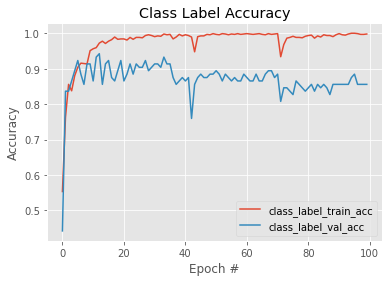

In [76]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom9_training_label_accuracy');

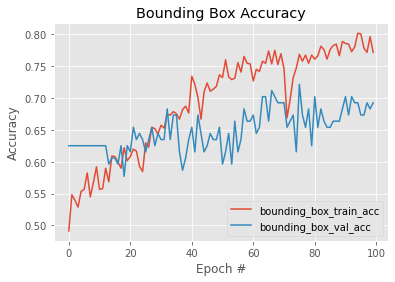

In [77]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom9_training_bounding_box_accuracy');

In [37]:
def model_training(model_name, learning_rate, batch_size, epochs):
    input_layer = Input(shape=(224,224,3), name='input_layer')
    conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
    flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
    bbox_head1 = Dense(448, activation="relu")(flat)
    bbox_head2 = Dropout(0.5)(bbox_head1)
    bbox_head3 = Dense(448, activation="relu")(bbox_head2)
    bbox_head4 = Dropout(0.5)(bbox_head3)
    bbox_head5 = Dense(448, activation="relu")(bbox_head4)
    bbox_head6 = Dropout(0.5)(bbox_head5)
    bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
    class_head1 = Dense(512, activation="relu")(flat)
    class_head2 = Dropout(0.5)(class_head1)
    class_head3 = Dense(512, activation="relu")(class_head2)
    class_head4 = Dropout(0.5)(class_head3)
    class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
    model_name = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
    losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
    loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
    opt = Adam(learning_rate = learning_rate)

# compiling the model
    model_name.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
    print(model_name.summary())
    
# constructing a dictionary for our training outputs
    train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}
    
# constructing a dictionary for our test outputs
    val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
    model = model_name.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)
    
    N = np.arange(0, epochs) #number of epochs
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))
    fig.tight_layout(pad=5.0)
    plt.savefig(f'../Images/{model_name}_training_accuracy_graphs')

    ax[1].set_title("Class Label Accuracy")
    ax[1].set_xlabel("Epoch #")
    ax[1].set_ylabel("Accuracy")
    ax[1].plot(N, model.history["class_label_accuracy"], label="class_label_train_acc")
    ax[1].plot(N, model.history["val_class_label_accuracy"], label="class_label_val_acc")
    ax[1].legend(loc="lower right")
    
    ax[2].set_title("Bounding Box Accuracy")
    ax[2].set_xlabel("Epoch #")
    ax[2].set_ylabel("Accuracy")
    ax[2].plot(N, model.history["bounding_box_accuracy"], label="bounding_box_train_acc")
    ax[2].plot(N, model.history["val_bounding_box_accuracy"], label="bounding_box_val_acc")
    ax[2].legend(loc="lower right")
    
    return model

In [25]:
def plotting_accuracy(model_name, epochs, model):
    N = np.arange(0, epochs) #number of epochs
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))
    fig.tight_layout(pad=5.0)
    plt.savefig(f'../Images/{model_name}_training_accuracy_graphs')

    ax[1].set_title("Class Label Accuracy")
    ax[1].set_xlabel("Epoch #")
    ax[1].set_ylabel("Accuracy")
    ax[1].plot(N, model.history["class_label_accuracy"], label="class_label_train_acc")
    ax[1].plot(N, model.history["val_class_label_accuracy"], label="class_label_val_acc")
    ax[1].legend(loc="lower right")
    
    ax[2].set_title("Bounding Box Accuracy")
    ax[2].set_xlabel("Epoch #")
    ax[2].set_ylabel("Accuracy")
    ax[2].plot(N, model.history["bounding_box_accuracy"], label="bounding_box_train_acc")
    ax[2].plot(N, model.history["val_bounding_box_accuracy"], label="bounding_box_val_acc")
    ax[2].legend(loc="lower right")

### Modeling - Custom10

In [26]:
# adding more nodes to dense layers in bounding box head

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 111, 111, 32) 0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 109, 109, 64) 18496       max_pooling2d_3[0][0]            
_______________________________________________________________________________________

Epoch 12/50
30/30 [==============================] - 35s 1s/step - loss: 0.1580 - bounding_box_loss: 0.0139 - class_label_loss: 0.1441 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.9541 - val_loss: 0.3371 - val_bounding_box_loss: 0.0113 - val_class_label_loss: 0.3258 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
Epoch 13/50
30/30 [==============================] - 36s 1s/step - loss: 0.1092 - bounding_box_loss: 0.0116 - class_label_loss: 0.0976 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9679 - val_loss: 0.2619 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.2511 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9327
Epoch 14/50
30/30 [==============================] - 36s 1s/step - loss: 0.0651 - bounding_box_loss: 0.0099 - class_label_loss: 0.0552 - bounding_box_accuracy: 0.6410 - class_label_accuracy: 0.9829 - val_loss: 0.3629 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.3538 - val_bounding_box

ValueError: Format 'functional object at 0x7fbaa9b53eb0>_training_accuracy_graphs' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

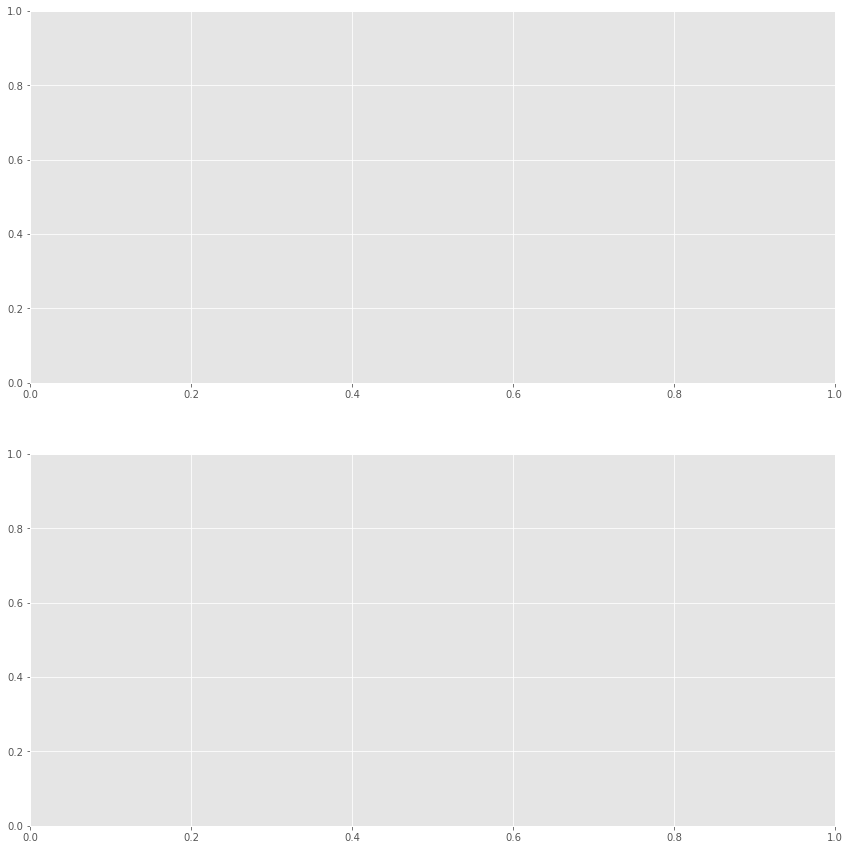

In [38]:
# model_training(model_name='model10', learning_rate=0.001, batch_size=32, epochs=50)

In [39]:
# creating custom model9
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(448, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(448, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(448, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom10 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom10.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom10.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 111, 111, 32) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 109, 109, 64) 18496       max_pooling2d_6[0][0]            
_______________________________________________________________________________________

In [40]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom10.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 31s 1s/step - loss: 0.8424 - bounding_box_loss: 0.0345 - class_label_loss: 0.8079 - bounding_box_accuracy: 0.4989 - class_label_accuracy: 0.5940 - val_loss: 0.5580 - val_bounding_box_loss: 0.0361 - val_class_label_loss: 0.5219 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.7788
Epoch 2/100
30/30 [==============================] - 33s 1s/step - loss: 0.4750 - bounding_box_loss: 0.0223 - class_label_loss: 0.4526 - bounding_box_accuracy: 0.5310 - class_label_accuracy: 0.8216 - val_loss: 0.5696 - val_bounding_box_loss: 0.0159 - val_class_label_loss: 0.5537 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7596
Epoch 3/100
30/30 [==============================] - 33s 1s/step - loss: 0.4022 - bounding_box_loss: 0.0192 - class_label_loss: 0.3831 - bounding_box_accuracy: 0.5096 - class_label_accuracy: 0.8504 - val_loss: 0.3777 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.3625 - val_bounding_box

30/30 [==============================] - 34s 1s/step - loss: 0.0255 - bounding_box_loss: 0.0044 - class_label_loss: 0.0211 - bounding_box_accuracy: 0.7831 - class_label_accuracy: 0.9947 - val_loss: 0.6001 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.5889 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8750
Epoch 48/100
30/30 [==============================] - 34s 1s/step - loss: 0.0358 - bounding_box_loss: 0.0061 - class_label_loss: 0.0298 - bounding_box_accuracy: 0.7618 - class_label_accuracy: 0.9925 - val_loss: 0.7162 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.7091 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8654
Epoch 49/100
30/30 [==============================] - 34s 1s/step - loss: 0.0442 - bounding_box_loss: 0.0050 - class_label_loss: 0.0392 - bounding_box_accuracy: 0.7949 - class_label_accuracy: 0.9861 - val_loss: 0.7878 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.7799 - val_bounding_box_accuracy:

30/30 [==============================] - 34s 1s/step - loss: 0.0081 - bounding_box_loss: 0.0030 - class_label_loss: 0.0052 - bounding_box_accuracy: 0.8226 - class_label_accuracy: 0.9989 - val_loss: 0.7887 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.7810 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
Epoch 94/100
30/30 [==============================] - 35s 1s/step - loss: 0.1218 - bounding_box_loss: 0.0053 - class_label_loss: 0.1165 - bounding_box_accuracy: 0.7970 - class_label_accuracy: 0.9669 - val_loss: 0.5529 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.5378 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.7885
Epoch 95/100
30/30 [==============================] - 34s 1s/step - loss: 0.0855 - bounding_box_loss: 0.0073 - class_label_loss: 0.0782 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9722 - val_loss: 0.6562 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.6475 - val_bounding_box_accuracy:

In [42]:
# Epoch 1/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.8424 - bounding_box_loss: 0.0345 - class_label_loss: 0.8079 - bounding_box_accuracy: 0.4989 - class_label_accuracy: 0.5940 - val_loss: 0.5580 - val_bounding_box_loss: 0.0361 - val_class_label_loss: 0.5219 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.7788
# Epoch 2/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.4750 - bounding_box_loss: 0.0223 - class_label_loss: 0.4526 - bounding_box_accuracy: 0.5310 - class_label_accuracy: 0.8216 - val_loss: 0.5696 - val_bounding_box_loss: 0.0159 - val_class_label_loss: 0.5537 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7596
# Epoch 3/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.4022 - bounding_box_loss: 0.0192 - class_label_loss: 0.3831 - bounding_box_accuracy: 0.5096 - class_label_accuracy: 0.8504 - val_loss: 0.3777 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.3625 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 4/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.3635 - bounding_box_loss: 0.0211 - class_label_loss: 0.3424 - bounding_box_accuracy: 0.5705 - class_label_accuracy: 0.8761 - val_loss: 0.4251 - val_bounding_box_loss: 0.0141 - val_class_label_loss: 0.4110 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 5/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.3375 - bounding_box_loss: 0.0173 - class_label_loss: 0.3202 - bounding_box_accuracy: 0.5620 - class_label_accuracy: 0.8932 - val_loss: 0.4910 - val_bounding_box_loss: 0.0172 - val_class_label_loss: 0.4738 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7981
# Epoch 6/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.3227 - bounding_box_loss: 0.0186 - class_label_loss: 0.3041 - bounding_box_accuracy: 0.5962 - class_label_accuracy: 0.8974 - val_loss: 0.4078 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.3803 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 7/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.2825 - bounding_box_loss: 0.0165 - class_label_loss: 0.2660 - bounding_box_accuracy: 0.5737 - class_label_accuracy: 0.9135 - val_loss: 0.6051 - val_bounding_box_loss: 0.0199 - val_class_label_loss: 0.5851 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7115
# Epoch 8/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.2467 - bounding_box_loss: 0.0152 - class_label_loss: 0.2315 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9156 - val_loss: 0.3070 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.2954 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8654
# Epoch 9/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.2257 - bounding_box_loss: 0.0147 - class_label_loss: 0.2110 - bounding_box_accuracy: 0.5823 - class_label_accuracy: 0.9284 - val_loss: 0.3729 - val_bounding_box_loss: 0.0116 - val_class_label_loss: 0.3613 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8846
# Epoch 10/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.3201 - bounding_box_loss: 0.0159 - class_label_loss: 0.3042 - bounding_box_accuracy: 0.5705 - class_label_accuracy: 0.8900 - val_loss: 0.5768 - val_bounding_box_loss: 0.0131 - val_class_label_loss: 0.5637 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.7212
# Epoch 11/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.2364 - bounding_box_loss: 0.0132 - class_label_loss: 0.2232 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9220 - val_loss: 0.4056 - val_bounding_box_loss: 0.0177 - val_class_label_loss: 0.3879 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8750
# Epoch 12/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.2101 - bounding_box_loss: 0.0129 - class_label_loss: 0.1972 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.9199 - val_loss: 0.6459 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.6349 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.7596
# Epoch 13/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.1964 - bounding_box_loss: 0.0123 - class_label_loss: 0.1841 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.9263 - val_loss: 0.3723 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.3617 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8846
# Epoch 14/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.1370 - bounding_box_loss: 0.0115 - class_label_loss: 0.1255 - bounding_box_accuracy: 0.6314 - class_label_accuracy: 0.9455 - val_loss: 0.3786 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.3689 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 15/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1400 - bounding_box_loss: 0.0109 - class_label_loss: 0.1291 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.9509 - val_loss: 0.3974 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.3877 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8942
# Epoch 16/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1143 - bounding_box_loss: 0.0107 - class_label_loss: 0.1036 - bounding_box_accuracy: 0.6656 - class_label_accuracy: 0.9583 - val_loss: 0.3746 - val_bounding_box_loss: 0.0198 - val_class_label_loss: 0.3548 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 17/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1448 - bounding_box_loss: 0.0128 - class_label_loss: 0.1320 - bounding_box_accuracy: 0.6645 - class_label_accuracy: 0.9573 - val_loss: 0.3870 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.3766 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 18/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1059 - bounding_box_loss: 0.0111 - class_label_loss: 0.0948 - bounding_box_accuracy: 0.6656 - class_label_accuracy: 0.9594 - val_loss: 0.4897 - val_bounding_box_loss: 0.0154 - val_class_label_loss: 0.4743 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8750
# Epoch 19/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1207 - bounding_box_loss: 0.0096 - class_label_loss: 0.1111 - bounding_box_accuracy: 0.6720 - class_label_accuracy: 0.9637 - val_loss: 0.4735 - val_bounding_box_loss: 0.0123 - val_class_label_loss: 0.4611 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 20/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0913 - bounding_box_loss: 0.0094 - class_label_loss: 0.0818 - bounding_box_accuracy: 0.7073 - class_label_accuracy: 0.9765 - val_loss: 0.5342 - val_bounding_box_loss: 0.0142 - val_class_label_loss: 0.5200 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 21/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0630 - bounding_box_loss: 0.0087 - class_label_loss: 0.0543 - bounding_box_accuracy: 0.6827 - class_label_accuracy: 0.9808 - val_loss: 0.4400 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.4309 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8942
# Epoch 22/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0766 - bounding_box_loss: 0.0084 - class_label_loss: 0.0682 - bounding_box_accuracy: 0.7126 - class_label_accuracy: 0.9808 - val_loss: 0.6557 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.6457 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 23/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0876 - bounding_box_loss: 0.0081 - class_label_loss: 0.0795 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9786 - val_loss: 0.5070 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.4982 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 24/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0757 - bounding_box_loss: 0.0073 - class_label_loss: 0.0684 - bounding_box_accuracy: 0.7404 - class_label_accuracy: 0.9786 - val_loss: 0.4752 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.4648 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 25/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0510 - bounding_box_loss: 0.0073 - class_label_loss: 0.0437 - bounding_box_accuracy: 0.7436 - class_label_accuracy: 0.9840 - val_loss: 0.5024 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.4916 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8558
# Epoch 26/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0546 - bounding_box_loss: 0.0071 - class_label_loss: 0.0474 - bounding_box_accuracy: 0.7436 - class_label_accuracy: 0.9861 - val_loss: 0.5505 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.5420 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 27/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0701 - bounding_box_loss: 0.0072 - class_label_loss: 0.0629 - bounding_box_accuracy: 0.7361 - class_label_accuracy: 0.9786 - val_loss: 0.5760 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.5651 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 28/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0488 - bounding_box_loss: 0.0071 - class_label_loss: 0.0417 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 0.9861 - val_loss: 0.5016 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.4934 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8846
# Epoch 29/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0436 - bounding_box_loss: 0.0063 - class_label_loss: 0.0373 - bounding_box_accuracy: 0.7447 - class_label_accuracy: 0.9893 - val_loss: 0.6296 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.6199 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 30/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0534 - bounding_box_loss: 0.0063 - class_label_loss: 0.0471 - bounding_box_accuracy: 0.7650 - class_label_accuracy: 0.9872 - val_loss: 0.5158 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.5061 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 31/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0318 - bounding_box_loss: 0.0053 - class_label_loss: 0.0265 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9872 - val_loss: 0.5260 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.5175 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8846
# Epoch 32/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0524 - bounding_box_loss: 0.0056 - class_label_loss: 0.0468 - bounding_box_accuracy: 0.7671 - class_label_accuracy: 0.9829 - val_loss: 0.5549 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.5478 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8846
# Epoch 33/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0304 - bounding_box_loss: 0.0063 - class_label_loss: 0.0241 - bounding_box_accuracy: 0.7618 - class_label_accuracy: 0.9882 - val_loss: 0.6953 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.6851 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8750
# Epoch 34/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0549 - bounding_box_loss: 0.0065 - class_label_loss: 0.0484 - bounding_box_accuracy: 0.7596 - class_label_accuracy: 0.9850 - val_loss: 0.4555 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.4471 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 35/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0755 - bounding_box_loss: 0.0069 - class_label_loss: 0.0686 - bounding_box_accuracy: 0.7618 - class_label_accuracy: 0.9786 - val_loss: 0.6940 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.6839 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8365
# Epoch 36/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0553 - bounding_box_loss: 0.0067 - class_label_loss: 0.0487 - bounding_box_accuracy: 0.7436 - class_label_accuracy: 0.9818 - val_loss: 0.5681 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.5590 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 37/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0465 - bounding_box_loss: 0.0061 - class_label_loss: 0.0404 - bounding_box_accuracy: 0.7778 - class_label_accuracy: 0.9893 - val_loss: 0.5421 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.5345 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8846
# Epoch 38/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0469 - bounding_box_loss: 0.0060 - class_label_loss: 0.0409 - bounding_box_accuracy: 0.7938 - class_label_accuracy: 0.9872 - val_loss: 0.5418 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.5346 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8750
# Epoch 39/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0222 - bounding_box_loss: 0.0059 - class_label_loss: 0.0163 - bounding_box_accuracy: 0.7799 - class_label_accuracy: 0.9925 - val_loss: 0.5983 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.5886 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 40/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0276 - bounding_box_loss: 0.0049 - class_label_loss: 0.0227 - bounding_box_accuracy: 0.7682 - class_label_accuracy: 0.9872 - val_loss: 0.6914 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.6824 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 41/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0236 - bounding_box_loss: 0.0051 - class_label_loss: 0.0185 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9957 - val_loss: 0.5910 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.5828 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8750
# Epoch 42/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0366 - bounding_box_loss: 0.0051 - class_label_loss: 0.0315 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 0.9936 - val_loss: 0.6406 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.6298 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 43/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0221 - bounding_box_loss: 0.0047 - class_label_loss: 0.0174 - bounding_box_accuracy: 0.7746 - class_label_accuracy: 0.9968 - val_loss: 0.6408 - val_bounding_box_loss: 0.0101 - val_class_label_loss: 0.6307 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8750
# Epoch 44/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0250 - bounding_box_loss: 0.0044 - class_label_loss: 0.0205 - bounding_box_accuracy: 0.7821 - class_label_accuracy: 0.9925 - val_loss: 0.6780 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.6692 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8846
# Epoch 45/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0149 - bounding_box_loss: 0.0044 - class_label_loss: 0.0105 - bounding_box_accuracy: 0.7959 - class_label_accuracy: 0.9947 - val_loss: 0.8182 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.8098 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8846
# Epoch 46/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0132 - bounding_box_loss: 0.0044 - class_label_loss: 0.0087 - bounding_box_accuracy: 0.7949 - class_label_accuracy: 0.9957 - val_loss: 0.8217 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.8125 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8846
# Epoch 47/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0255 - bounding_box_loss: 0.0044 - class_label_loss: 0.0211 - bounding_box_accuracy: 0.7831 - class_label_accuracy: 0.9947 - val_loss: 0.6001 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.5889 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8750
# Epoch 48/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0358 - bounding_box_loss: 0.0061 - class_label_loss: 0.0298 - bounding_box_accuracy: 0.7618 - class_label_accuracy: 0.9925 - val_loss: 0.7162 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.7091 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8654
# Epoch 49/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0442 - bounding_box_loss: 0.0050 - class_label_loss: 0.0392 - bounding_box_accuracy: 0.7949 - class_label_accuracy: 0.9861 - val_loss: 0.7878 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.7799 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 50/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0316 - bounding_box_loss: 0.0046 - class_label_loss: 0.0270 - bounding_box_accuracy: 0.8034 - class_label_accuracy: 0.9904 - val_loss: 0.7314 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.7234 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 51/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0143 - bounding_box_loss: 0.0044 - class_label_loss: 0.0100 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 0.9979 - val_loss: 0.7260 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.7168 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8654
# Epoch 52/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0188 - bounding_box_loss: 0.0045 - class_label_loss: 0.0143 - bounding_box_accuracy: 0.8237 - class_label_accuracy: 0.9947 - val_loss: 0.6961 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.6875 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8750
# Epoch 53/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0186 - bounding_box_loss: 0.0045 - class_label_loss: 0.0141 - bounding_box_accuracy: 0.7895 - class_label_accuracy: 0.9925 - val_loss: 0.8557 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.8471 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8654
# Epoch 54/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0240 - bounding_box_loss: 0.0041 - class_label_loss: 0.0200 - bounding_box_accuracy: 0.8109 - class_label_accuracy: 0.9882 - val_loss: 0.7276 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.7196 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8846
# Epoch 55/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0153 - bounding_box_loss: 0.0039 - class_label_loss: 0.0113 - bounding_box_accuracy: 0.8141 - class_label_accuracy: 0.9957 - val_loss: 0.7815 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.7731 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 56/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0116 - bounding_box_loss: 0.0041 - class_label_loss: 0.0076 - bounding_box_accuracy: 0.8088 - class_label_accuracy: 0.9968 - val_loss: 0.8034 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.7936 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8654
# Epoch 57/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0129 - bounding_box_loss: 0.0040 - class_label_loss: 0.0090 - bounding_box_accuracy: 0.7991 - class_label_accuracy: 0.9957 - val_loss: 1.0303 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 1.0213 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 58/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0170 - bounding_box_loss: 0.0036 - class_label_loss: 0.0134 - bounding_box_accuracy: 0.8291 - class_label_accuracy: 0.9936 - val_loss: 0.6477 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.6393 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8846
# Epoch 59/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0158 - bounding_box_loss: 0.0037 - class_label_loss: 0.0121 - bounding_box_accuracy: 0.8141 - class_label_accuracy: 0.9957 - val_loss: 0.6958 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.6876 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8846
# Epoch 60/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0126 - bounding_box_loss: 0.0036 - class_label_loss: 0.0090 - bounding_box_accuracy: 0.8269 - class_label_accuracy: 0.9957 - val_loss: 0.7963 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.7877 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 61/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0117 - bounding_box_loss: 0.0034 - class_label_loss: 0.0084 - bounding_box_accuracy: 0.8280 - class_label_accuracy: 0.9957 - val_loss: 0.7688 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.7592 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 62/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0130 - bounding_box_loss: 0.0034 - class_label_loss: 0.0096 - bounding_box_accuracy: 0.8419 - class_label_accuracy: 0.9968 - val_loss: 0.8662 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.8573 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8558
# Epoch 63/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0035 - class_label_loss: 0.0065 - bounding_box_accuracy: 0.8109 - class_label_accuracy: 0.9968 - val_loss: 0.9391 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.9301 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 64/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0087 - bounding_box_loss: 0.0033 - class_label_loss: 0.0054 - bounding_box_accuracy: 0.8312 - class_label_accuracy: 0.9979 - val_loss: 0.9517 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.9432 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8654
# Epoch 65/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0150 - bounding_box_loss: 0.0037 - class_label_loss: 0.0113 - bounding_box_accuracy: 0.8301 - class_label_accuracy: 0.9957 - val_loss: 0.6980 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.6906 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 66/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0083 - bounding_box_loss: 0.0033 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.8173 - class_label_accuracy: 0.9989 - val_loss: 0.8752 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.8659 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 67/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0081 - bounding_box_loss: 0.0031 - class_label_loss: 0.0049 - bounding_box_accuracy: 0.8237 - class_label_accuracy: 0.9968 - val_loss: 0.8922 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.8831 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 68/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0073 - bounding_box_loss: 0.0030 - class_label_loss: 0.0043 - bounding_box_accuracy: 0.8205 - class_label_accuracy: 0.9989 - val_loss: 0.9580 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.9493 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8750
# Epoch 69/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0091 - bounding_box_loss: 0.0032 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.8526 - class_label_accuracy: 0.9968 - val_loss: 0.9745 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.9659 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 70/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0084 - bounding_box_loss: 0.0031 - class_label_loss: 0.0053 - bounding_box_accuracy: 0.8355 - class_label_accuracy: 0.9989 - val_loss: 0.8691 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.8606 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 71/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0069 - bounding_box_loss: 0.0033 - class_label_loss: 0.0036 - bounding_box_accuracy: 0.8226 - class_label_accuracy: 0.9979 - val_loss: 1.1332 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 1.1246 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 72/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0095 - bounding_box_loss: 0.0031 - class_label_loss: 0.0064 - bounding_box_accuracy: 0.8301 - class_label_accuracy: 0.9957 - val_loss: 1.0865 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 1.0771 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 73/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0136 - bounding_box_loss: 0.0032 - class_label_loss: 0.0104 - bounding_box_accuracy: 0.8323 - class_label_accuracy: 0.9957 - val_loss: 0.8870 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.8785 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 74/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0092 - bounding_box_loss: 0.0034 - class_label_loss: 0.0058 - bounding_box_accuracy: 0.8077 - class_label_accuracy: 0.9989 - val_loss: 0.9939 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.9846 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8750
# Epoch 75/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0090 - bounding_box_loss: 0.0032 - class_label_loss: 0.0058 - bounding_box_accuracy: 0.8494 - class_label_accuracy: 0.9979 - val_loss: 0.9511 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.9423 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8558
# Epoch 76/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0096 - bounding_box_loss: 0.0030 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.8280 - class_label_accuracy: 0.9968 - val_loss: 0.7668 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.7583 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8942
# Epoch 77/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0076 - bounding_box_loss: 0.0030 - class_label_loss: 0.0046 - bounding_box_accuracy: 0.8344 - class_label_accuracy: 0.9968 - val_loss: 0.9226 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.9141 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8750
# Epoch 78/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0030 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 1.0000 - val_loss: 1.0698 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 1.0614 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 79/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0088 - bounding_box_loss: 0.0028 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.8408 - class_label_accuracy: 0.9968 - val_loss: 0.9447 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.9361 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 80/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0045 - bounding_box_loss: 0.0028 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.8248 - class_label_accuracy: 1.0000 - val_loss: 1.0695 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.0605 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 81/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0089 - bounding_box_loss: 0.0030 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9979 - val_loss: 0.9254 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.9166 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 82/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0068 - bounding_box_loss: 0.0029 - class_label_loss: 0.0040 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.9989 - val_loss: 0.8219 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.8138 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 83/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0055 - bounding_box_loss: 0.0028 - class_label_loss: 0.0027 - bounding_box_accuracy: 0.8419 - class_label_accuracy: 0.9989 - val_loss: 0.9715 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.9635 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 84/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0027 - class_label_loss: 0.0034 - bounding_box_accuracy: 0.8365 - class_label_accuracy: 0.9979 - val_loss: 1.0097 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.0007 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 85/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0053 - bounding_box_loss: 0.0027 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.8494 - class_label_accuracy: 0.9989 - val_loss: 0.9159 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.9078 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 86/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0062 - bounding_box_loss: 0.0026 - class_label_loss: 0.0035 - bounding_box_accuracy: 0.8291 - class_label_accuracy: 0.9979 - val_loss: 1.0422 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 1.0339 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8654
# Epoch 87/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0072 - bounding_box_loss: 0.0029 - class_label_loss: 0.0043 - bounding_box_accuracy: 0.8365 - class_label_accuracy: 0.9979 - val_loss: 0.8860 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.8780 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8846
# Epoch 88/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0059 - bounding_box_loss: 0.0028 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 0.9989 - val_loss: 1.1828 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.1738 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8750
# Epoch 89/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0056 - bounding_box_loss: 0.0027 - class_label_loss: 0.0029 - bounding_box_accuracy: 0.8558 - class_label_accuracy: 0.9989 - val_loss: 0.8969 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.8889 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8654
# Epoch 90/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0054 - bounding_box_loss: 0.0028 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.8440 - class_label_accuracy: 0.9989 - val_loss: 1.1088 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 1.1012 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8846
# Epoch 91/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0075 - bounding_box_loss: 0.0031 - class_label_loss: 0.0044 - bounding_box_accuracy: 0.8376 - class_label_accuracy: 0.9979 - val_loss: 1.2083 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 1.1998 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8654
# Epoch 92/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0028 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.8526 - class_label_accuracy: 0.9989 - val_loss: 0.9867 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.9780 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8750
# Epoch 93/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0081 - bounding_box_loss: 0.0030 - class_label_loss: 0.0052 - bounding_box_accuracy: 0.8226 - class_label_accuracy: 0.9989 - val_loss: 0.7887 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.7810 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 94/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1218 - bounding_box_loss: 0.0053 - class_label_loss: 0.1165 - bounding_box_accuracy: 0.7970 - class_label_accuracy: 0.9669 - val_loss: 0.5529 - val_bounding_box_loss: 0.0151 - val_class_label_loss: 0.5378 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.7885
# Epoch 95/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0855 - bounding_box_loss: 0.0073 - class_label_loss: 0.0782 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9722 - val_loss: 0.6562 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.6475 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8558
# Epoch 96/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1154 - bounding_box_loss: 0.0055 - class_label_loss: 0.1099 - bounding_box_accuracy: 0.7863 - class_label_accuracy: 0.9818 - val_loss: 0.4675 - val_bounding_box_loss: 0.0246 - val_class_label_loss: 0.4430 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8365
# Epoch 97/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1117 - bounding_box_loss: 0.0087 - class_label_loss: 0.1031 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9733 - val_loss: 0.4524 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.4395 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 98/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0848 - bounding_box_loss: 0.0063 - class_label_loss: 0.0785 - bounding_box_accuracy: 0.7863 - class_label_accuracy: 0.9733 - val_loss: 0.5053 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.4919 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8654
# Epoch 99/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0471 - bounding_box_loss: 0.0047 - class_label_loss: 0.0424 - bounding_box_accuracy: 0.8120 - class_label_accuracy: 0.9861 - val_loss: 0.6020 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.5923 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 100/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0351 - bounding_box_loss: 0.0042 - class_label_loss: 0.0309 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 0.9882 - val_loss: 0.5132 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.5051 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8558

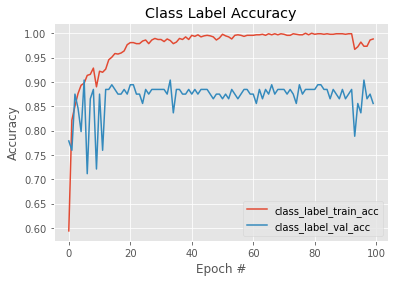

In [41]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom10_training_label_accuracy');

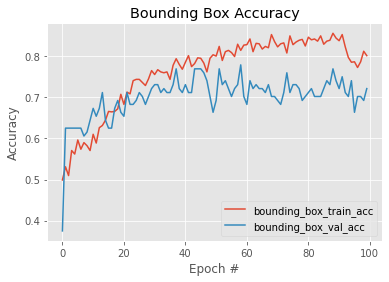

In [43]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom10_training_bounding_box_accuracy');

### Modeling - Custom11

In [44]:
# decreasing the proportion of dropout from 0.5 to 0.2 in bounding box nodes

In [45]:
# creating custom model11
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(448, activation="relu")(flat)
bbox_head2 = Dropout(0.2)(bbox_head1)
bbox_head3 = Dense(448, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.2)(bbox_head3)
bbox_head5 = Dense(448, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.2)(bbox_head5)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom11 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom11.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom11.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 111, 111, 32) 0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_9[0][0]            
_______________________________________________________________________________________

In [46]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom11.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 31s 1s/step - loss: 0.7578 - bounding_box_loss: 0.0371 - class_label_loss: 0.7207 - bounding_box_accuracy: 0.5566 - class_label_accuracy: 0.5983 - val_loss: 0.6324 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.6168 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6827
Epoch 2/100
30/30 [==============================] - 33s 1s/step - loss: 0.4299 - bounding_box_loss: 0.0179 - class_label_loss: 0.4120 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.8494 - val_loss: 0.4495 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.4357 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
Epoch 3/100
30/30 [==============================] - 34s 1s/step - loss: 0.3527 - bounding_box_loss: 0.0182 - class_label_loss: 0.3344 - bounding_box_accuracy: 0.6090 - class_label_accuracy: 0.8846 - val_loss: 0.3153 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.3033 - val_bounding_box

30/30 [==============================] - 35s 1s/step - loss: 0.0334 - bounding_box_loss: 0.0024 - class_label_loss: 0.0310 - bounding_box_accuracy: 0.8675 - class_label_accuracy: 0.9850 - val_loss: 0.8865 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.8791 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8462
Epoch 48/100
30/30 [==============================] - 35s 1s/step - loss: 0.0331 - bounding_box_loss: 0.0021 - class_label_loss: 0.0311 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9904 - val_loss: 0.6871 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.6784 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8750
Epoch 49/100
30/30 [==============================] - 35s 1s/step - loss: 0.0270 - bounding_box_loss: 0.0019 - class_label_loss: 0.0251 - bounding_box_accuracy: 0.8985 - class_label_accuracy: 0.9882 - val_loss: 0.6189 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.6110 - val_bounding_box_accuracy:

30/30 [==============================] - 35s 1s/step - loss: 0.0068 - bounding_box_loss: 7.9817e-04 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.9231 - class_label_accuracy: 0.9979 - val_loss: 1.2226 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.2142 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8558
Epoch 94/100
30/30 [==============================] - 35s 1s/step - loss: 0.0077 - bounding_box_loss: 8.9532e-04 - class_label_loss: 0.0069 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9957 - val_loss: 1.0917 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.0836 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8654
Epoch 95/100
30/30 [==============================] - 34s 1s/step - loss: 0.3300 - bounding_box_loss: 0.0046 - class_label_loss: 0.3253 - bounding_box_accuracy: 0.8600 - class_label_accuracy: 0.9359 - val_loss: 0.8400 - val_bounding_box_loss: 0.0251 - val_class_label_loss: 0.8149 - val_bounding_box_a

In [47]:
# Epoch 1/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.7578 - bounding_box_loss: 0.0371 - class_label_loss: 0.7207 - bounding_box_accuracy: 0.5566 - class_label_accuracy: 0.5983 - val_loss: 0.6324 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.6168 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6827
# Epoch 2/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.4299 - bounding_box_loss: 0.0179 - class_label_loss: 0.4120 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.8494 - val_loss: 0.4495 - val_bounding_box_loss: 0.0138 - val_class_label_loss: 0.4357 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 3/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.3527 - bounding_box_loss: 0.0182 - class_label_loss: 0.3344 - bounding_box_accuracy: 0.6090 - class_label_accuracy: 0.8846 - val_loss: 0.3153 - val_bounding_box_loss: 0.0120 - val_class_label_loss: 0.3033 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 4/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.3298 - bounding_box_loss: 0.0192 - class_label_loss: 0.3107 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.8985 - val_loss: 0.3886 - val_bounding_box_loss: 0.0144 - val_class_label_loss: 0.3742 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 5/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.3070 - bounding_box_loss: 0.0161 - class_label_loss: 0.2909 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9006 - val_loss: 0.4740 - val_bounding_box_loss: 0.0123 - val_class_label_loss: 0.4617 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 6/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.2895 - bounding_box_loss: 0.0134 - class_label_loss: 0.2761 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 0.9006 - val_loss: 0.3615 - val_bounding_box_loss: 0.0145 - val_class_label_loss: 0.3470 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 7/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.2496 - bounding_box_loss: 0.0135 - class_label_loss: 0.2361 - bounding_box_accuracy: 0.6549 - class_label_accuracy: 0.9252 - val_loss: 0.3315 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3182 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 8/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.2192 - bounding_box_loss: 0.0120 - class_label_loss: 0.2072 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9177 - val_loss: 0.2861 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.2761 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 9/100
# 30/30 [==============================] - 32s 1s/step - loss: 0.2150 - bounding_box_loss: 0.0101 - class_label_loss: 0.2049 - bounding_box_accuracy: 0.6976 - class_label_accuracy: 0.9231 - val_loss: 0.3448 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.3368 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 10/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.1615 - bounding_box_loss: 0.0087 - class_label_loss: 0.1529 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9391 - val_loss: 0.5385 - val_bounding_box_loss: 0.0150 - val_class_label_loss: 0.5235 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8077
# Epoch 11/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.1806 - bounding_box_loss: 0.0109 - class_label_loss: 0.1697 - bounding_box_accuracy: 0.7500 - class_label_accuracy: 0.9306 - val_loss: 0.3729 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.3653 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
# Epoch 12/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.1921 - bounding_box_loss: 0.0080 - class_label_loss: 0.1841 - bounding_box_accuracy: 0.7585 - class_label_accuracy: 0.9274 - val_loss: 0.3347 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.3271 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8750
# Epoch 13/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1303 - bounding_box_loss: 0.0070 - class_label_loss: 0.1233 - bounding_box_accuracy: 0.7692 - class_label_accuracy: 0.9455 - val_loss: 0.4621 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.4549 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8846
# Epoch 14/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1004 - bounding_box_loss: 0.0059 - class_label_loss: 0.0945 - bounding_box_accuracy: 0.7895 - class_label_accuracy: 0.9626 - val_loss: 0.4183 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.4107 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.8750
# Epoch 15/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1099 - bounding_box_loss: 0.0055 - class_label_loss: 0.1043 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9637 - val_loss: 0.5939 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.5868 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 16/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0954 - bounding_box_loss: 0.0058 - class_label_loss: 0.0897 - bounding_box_accuracy: 0.7874 - class_label_accuracy: 0.9690 - val_loss: 0.4276 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.4211 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8846
# Epoch 17/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0725 - bounding_box_loss: 0.0049 - class_label_loss: 0.0675 - bounding_box_accuracy: 0.7885 - class_label_accuracy: 0.9808 - val_loss: 0.4793 - val_bounding_box_loss: 0.0064 - val_class_label_loss: 0.4729 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
# Epoch 18/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0735 - bounding_box_loss: 0.0041 - class_label_loss: 0.0694 - bounding_box_accuracy: 0.7906 - class_label_accuracy: 0.9786 - val_loss: 0.4736 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.4667 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 19/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0647 - bounding_box_loss: 0.0039 - class_label_loss: 0.0608 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 0.9808 - val_loss: 0.5921 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 0.5855 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.8750
# Epoch 20/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0667 - bounding_box_loss: 0.0035 - class_label_loss: 0.0632 - bounding_box_accuracy: 0.8312 - class_label_accuracy: 0.9797 - val_loss: 0.5137 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.5054 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8750
# Epoch 21/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0647 - bounding_box_loss: 0.0036 - class_label_loss: 0.0611 - bounding_box_accuracy: 0.8472 - class_label_accuracy: 0.9786 - val_loss: 0.5524 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.5447 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8846
# Epoch 22/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0460 - bounding_box_loss: 0.0034 - class_label_loss: 0.0427 - bounding_box_accuracy: 0.8344 - class_label_accuracy: 0.9882 - val_loss: 0.5239 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.5167 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.8750
# Epoch 23/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0544 - bounding_box_loss: 0.0032 - class_label_loss: 0.0513 - bounding_box_accuracy: 0.8462 - class_label_accuracy: 0.9840 - val_loss: 0.5382 - val_bounding_box_loss: 0.0065 - val_class_label_loss: 0.5317 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8846
# Epoch 24/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0444 - bounding_box_loss: 0.0032 - class_label_loss: 0.0412 - bounding_box_accuracy: 0.8483 - class_label_accuracy: 0.9840 - val_loss: 0.5999 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 0.5936 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 25/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0423 - bounding_box_loss: 0.0028 - class_label_loss: 0.0394 - bounding_box_accuracy: 0.8558 - class_label_accuracy: 0.9882 - val_loss: 0.5206 - val_bounding_box_loss: 0.0070 - val_class_label_loss: 0.5136 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8942
# Epoch 26/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0520 - bounding_box_loss: 0.0030 - class_label_loss: 0.0490 - bounding_box_accuracy: 0.8451 - class_label_accuracy: 0.9808 - val_loss: 0.6840 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 0.6772 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8654
# Epoch 27/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0528 - bounding_box_loss: 0.0033 - class_label_loss: 0.0495 - bounding_box_accuracy: 0.8568 - class_label_accuracy: 0.9840 - val_loss: 0.6882 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.6811 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8750
# Epoch 28/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0522 - bounding_box_loss: 0.0031 - class_label_loss: 0.0491 - bounding_box_accuracy: 0.8504 - class_label_accuracy: 0.9829 - val_loss: 0.5109 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.5023 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8942
# Epoch 29/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0329 - bounding_box_loss: 0.0031 - class_label_loss: 0.0298 - bounding_box_accuracy: 0.8280 - class_label_accuracy: 0.9904 - val_loss: 0.5379 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.5309 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 30/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0541 - bounding_box_loss: 0.0029 - class_label_loss: 0.0512 - bounding_box_accuracy: 0.8590 - class_label_accuracy: 0.9915 - val_loss: 0.5517 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.5446 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 31/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0455 - bounding_box_loss: 0.0030 - class_label_loss: 0.0426 - bounding_box_accuracy: 0.8536 - class_label_accuracy: 0.9850 - val_loss: 0.5609 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.5540 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 32/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0360 - bounding_box_loss: 0.0033 - class_label_loss: 0.0328 - bounding_box_accuracy: 0.8622 - class_label_accuracy: 0.9850 - val_loss: 0.6928 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.6851 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8750
# Epoch 33/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0471 - bounding_box_loss: 0.0028 - class_label_loss: 0.0444 - bounding_box_accuracy: 0.8536 - class_label_accuracy: 0.9861 - val_loss: 1.0028 - val_bounding_box_loss: 0.0067 - val_class_label_loss: 0.9962 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8173
# Epoch 34/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1168 - bounding_box_loss: 0.0051 - class_label_loss: 0.1118 - bounding_box_accuracy: 0.8280 - class_label_accuracy: 0.9551 - val_loss: 0.5116 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.5030 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8462
# Epoch 35/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0666 - bounding_box_loss: 0.0046 - class_label_loss: 0.0620 - bounding_box_accuracy: 0.8280 - class_label_accuracy: 0.9776 - val_loss: 0.6043 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5969 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8654
# Epoch 36/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0528 - bounding_box_loss: 0.0029 - class_label_loss: 0.0500 - bounding_box_accuracy: 0.8419 - class_label_accuracy: 0.9797 - val_loss: 0.7449 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.7368 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8654
# Epoch 37/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0363 - bounding_box_loss: 0.0026 - class_label_loss: 0.0338 - bounding_box_accuracy: 0.8600 - class_label_accuracy: 0.9850 - val_loss: 0.6434 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6355 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8654
# Epoch 38/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0270 - bounding_box_loss: 0.0023 - class_label_loss: 0.0247 - bounding_box_accuracy: 0.8739 - class_label_accuracy: 0.9904 - val_loss: 0.7652 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.7575 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8654
# Epoch 39/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0415 - bounding_box_loss: 0.0023 - class_label_loss: 0.0392 - bounding_box_accuracy: 0.8707 - class_label_accuracy: 0.9904 - val_loss: 0.6116 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.6042 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.8558
# Epoch 40/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0402 - bounding_box_loss: 0.0024 - class_label_loss: 0.0378 - bounding_box_accuracy: 0.8782 - class_label_accuracy: 0.9850 - val_loss: 0.6767 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6688 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8654
# Epoch 41/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0319 - bounding_box_loss: 0.0021 - class_label_loss: 0.0298 - bounding_box_accuracy: 0.8803 - class_label_accuracy: 0.9915 - val_loss: 0.8006 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.7927 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8654
# Epoch 42/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0347 - bounding_box_loss: 0.0022 - class_label_loss: 0.0326 - bounding_box_accuracy: 0.8771 - class_label_accuracy: 0.9882 - val_loss: 0.8003 - val_bounding_box_loss: 0.0072 - val_class_label_loss: 0.7931 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8462
# Epoch 43/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0372 - bounding_box_loss: 0.0025 - class_label_loss: 0.0346 - bounding_box_accuracy: 0.8686 - class_label_accuracy: 0.9882 - val_loss: 0.6525 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.6444 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8558
# Epoch 44/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0210 - bounding_box_loss: 0.0021 - class_label_loss: 0.0190 - bounding_box_accuracy: 0.8729 - class_label_accuracy: 0.9936 - val_loss: 1.0061 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.9979 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8269
# Epoch 45/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0866 - bounding_box_loss: 0.0026 - class_label_loss: 0.0840 - bounding_box_accuracy: 0.8761 - class_label_accuracy: 0.9637 - val_loss: 0.6751 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.6662 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8269
# Epoch 46/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0376 - bounding_box_loss: 0.0022 - class_label_loss: 0.0353 - bounding_box_accuracy: 0.8814 - class_label_accuracy: 0.9872 - val_loss: 0.8161 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.8089 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8558
# Epoch 47/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0334 - bounding_box_loss: 0.0024 - class_label_loss: 0.0310 - bounding_box_accuracy: 0.8675 - class_label_accuracy: 0.9850 - val_loss: 0.8865 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.8791 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8462
# Epoch 48/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0331 - bounding_box_loss: 0.0021 - class_label_loss: 0.0311 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9904 - val_loss: 0.6871 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.6784 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8750
# Epoch 49/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0270 - bounding_box_loss: 0.0019 - class_label_loss: 0.0251 - bounding_box_accuracy: 0.8985 - class_label_accuracy: 0.9882 - val_loss: 0.6189 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.6110 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8558
# Epoch 50/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0195 - bounding_box_loss: 0.0015 - class_label_loss: 0.0180 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9915 - val_loss: 0.7300 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.7220 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8750
# Epoch 51/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0140 - bounding_box_loss: 0.0015 - class_label_loss: 0.0125 - bounding_box_accuracy: 0.8910 - class_label_accuracy: 0.9936 - val_loss: 0.7270 - val_bounding_box_loss: 0.0075 - val_class_label_loss: 0.7195 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 52/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0209 - bounding_box_loss: 0.0016 - class_label_loss: 0.0194 - bounding_box_accuracy: 0.8814 - class_label_accuracy: 0.9915 - val_loss: 0.7534 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.7457 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8750
# Epoch 53/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0171 - bounding_box_loss: 0.0016 - class_label_loss: 0.0156 - bounding_box_accuracy: 0.9006 - class_label_accuracy: 0.9936 - val_loss: 0.6958 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.6887 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8654
# Epoch 54/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0192 - bounding_box_loss: 0.0015 - class_label_loss: 0.0177 - bounding_box_accuracy: 0.8900 - class_label_accuracy: 0.9947 - val_loss: 0.7332 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.7243 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8750
# Epoch 55/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0229 - bounding_box_loss: 0.0013 - class_label_loss: 0.0216 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9915 - val_loss: 0.7470 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.7391 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 56/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0158 - bounding_box_loss: 0.0016 - class_label_loss: 0.0142 - bounding_box_accuracy: 0.8996 - class_label_accuracy: 0.9925 - val_loss: 0.7609 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.7528 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 57/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0189 - bounding_box_loss: 0.0014 - class_label_loss: 0.0175 - bounding_box_accuracy: 0.9049 - class_label_accuracy: 0.9915 - val_loss: 0.8210 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.8131 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8654
# Epoch 58/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0113 - bounding_box_loss: 0.0014 - class_label_loss: 0.0098 - bounding_box_accuracy: 0.8900 - class_label_accuracy: 0.9979 - val_loss: 0.8356 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.8273 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 59/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0167 - bounding_box_loss: 0.0016 - class_label_loss: 0.0152 - bounding_box_accuracy: 0.9017 - class_label_accuracy: 0.9947 - val_loss: 0.9320 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.9243 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8654
# Epoch 60/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0074 - bounding_box_loss: 0.0014 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.8846 - class_label_accuracy: 0.9979 - val_loss: 0.9873 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.9790 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8654
# Epoch 61/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0213 - bounding_box_loss: 0.0014 - class_label_loss: 0.0199 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9925 - val_loss: 0.8027 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.7942 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8750
# Epoch 62/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0166 - bounding_box_loss: 0.0013 - class_label_loss: 0.0153 - bounding_box_accuracy: 0.8985 - class_label_accuracy: 0.9936 - val_loss: 0.8000 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 0.7924 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8365
# Epoch 63/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0080 - bounding_box_loss: 0.0013 - class_label_loss: 0.0067 - bounding_box_accuracy: 0.8835 - class_label_accuracy: 0.9989 - val_loss: 1.0473 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 1.0396 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8462
# Epoch 64/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0121 - bounding_box_loss: 0.0012 - class_label_loss: 0.0109 - bounding_box_accuracy: 0.8835 - class_label_accuracy: 0.9947 - val_loss: 0.9797 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.9719 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 65/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0084 - bounding_box_loss: 0.0012 - class_label_loss: 0.0072 - bounding_box_accuracy: 0.9017 - class_label_accuracy: 0.9968 - val_loss: 1.0074 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.9996 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8654
# Epoch 66/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0154 - bounding_box_loss: 0.0014 - class_label_loss: 0.0140 - bounding_box_accuracy: 0.9017 - class_label_accuracy: 0.9947 - val_loss: 0.9700 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.9621 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8558
# Epoch 67/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0235 - bounding_box_loss: 0.0013 - class_label_loss: 0.0221 - bounding_box_accuracy: 0.9017 - class_label_accuracy: 0.9915 - val_loss: 1.0458 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 1.0389 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8365
# Epoch 68/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0212 - bounding_box_loss: 0.0013 - class_label_loss: 0.0199 - bounding_box_accuracy: 0.8857 - class_label_accuracy: 0.9904 - val_loss: 0.7949 - val_bounding_box_loss: 0.0071 - val_class_label_loss: 0.7878 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8750
# Epoch 69/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0132 - bounding_box_loss: 0.0012 - class_label_loss: 0.0120 - bounding_box_accuracy: 0.9049 - class_label_accuracy: 0.9957 - val_loss: 1.1690 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 1.1593 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8558
# Epoch 70/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0254 - bounding_box_loss: 0.0018 - class_label_loss: 0.0236 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9893 - val_loss: 1.6369 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.6289 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8269
# Epoch 71/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0372 - bounding_box_loss: 0.0018 - class_label_loss: 0.0354 - bounding_box_accuracy: 0.8900 - class_label_accuracy: 0.9840 - val_loss: 0.8731 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.8645 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8462
# Epoch 72/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0228 - bounding_box_loss: 0.0016 - class_label_loss: 0.0212 - bounding_box_accuracy: 0.8707 - class_label_accuracy: 0.9936 - val_loss: 1.1657 - val_bounding_box_loss: 0.0076 - val_class_label_loss: 1.1581 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8654
# Epoch 73/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0323 - bounding_box_loss: 0.0016 - class_label_loss: 0.0307 - bounding_box_accuracy: 0.8878 - class_label_accuracy: 0.9893 - val_loss: 0.7087 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.7018 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8558
# Epoch 74/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0109 - bounding_box_loss: 0.0013 - class_label_loss: 0.0096 - bounding_box_accuracy: 0.9049 - class_label_accuracy: 0.9947 - val_loss: 0.7171 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.7093 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 75/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0134 - bounding_box_loss: 0.0015 - class_label_loss: 0.0119 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9947 - val_loss: 0.8080 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.8001 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 76/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0093 - bounding_box_loss: 0.0011 - class_label_loss: 0.0083 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9979 - val_loss: 0.9081 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.9008 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8750
# Epoch 77/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0010 - class_label_loss: 0.0089 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9947 - val_loss: 0.9659 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.9582 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8654
# Epoch 78/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0106 - bounding_box_loss: 0.0011 - class_label_loss: 0.0096 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9947 - val_loss: 0.9046 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.8966 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 79/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0105 - bounding_box_loss: 9.7337e-04 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.9135 - class_label_accuracy: 0.9947 - val_loss: 0.9060 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.8979 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8750
# Epoch 80/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0103 - bounding_box_loss: 9.5022e-04 - class_label_loss: 0.0094 - bounding_box_accuracy: 0.9071 - class_label_accuracy: 0.9947 - val_loss: 1.2211 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 1.2133 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8462
# Epoch 81/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0092 - bounding_box_loss: 0.0011 - class_label_loss: 0.0081 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9968 - val_loss: 0.9772 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.9695 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8654
# Epoch 82/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0054 - bounding_box_loss: 9.0058e-04 - class_label_loss: 0.0045 - bounding_box_accuracy: 0.9177 - class_label_accuracy: 0.9989 - val_loss: 1.0644 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 1.0562 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 83/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0061 - bounding_box_loss: 9.7724e-04 - class_label_loss: 0.0052 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9968 - val_loss: 1.1162 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 1.1084 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 84/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.0054 - bounding_box_loss: 8.3841e-04 - class_label_loss: 0.0046 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9989 - val_loss: 1.2502 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.2419 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8654
# Epoch 85/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0054 - bounding_box_loss: 9.7282e-04 - class_label_loss: 0.0044 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9979 - val_loss: 1.3259 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.3176 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8558
# Epoch 86/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0068 - bounding_box_loss: 0.0010 - class_label_loss: 0.0058 - bounding_box_accuracy: 0.9167 - class_label_accuracy: 0.9979 - val_loss: 1.1066 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 1.0981 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 87/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0051 - bounding_box_loss: 8.9838e-04 - class_label_loss: 0.0042 - bounding_box_accuracy: 0.9124 - class_label_accuracy: 0.9979 - val_loss: 1.1633 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 1.1543 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8750
# Epoch 88/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0047 - bounding_box_loss: 8.9503e-04 - class_label_loss: 0.0038 - bounding_box_accuracy: 0.9199 - class_label_accuracy: 0.9989 - val_loss: 1.2512 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.2431 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 89/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0070 - bounding_box_loss: 8.5494e-04 - class_label_loss: 0.0061 - bounding_box_accuracy: 0.9188 - class_label_accuracy: 0.9979 - val_loss: 1.3016 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 1.2934 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8750
# Epoch 90/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0059 - bounding_box_loss: 8.9032e-04 - class_label_loss: 0.0051 - bounding_box_accuracy: 0.9199 - class_label_accuracy: 0.9989 - val_loss: 1.2344 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 1.2259 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8654
# Epoch 91/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0048 - bounding_box_loss: 8.6291e-04 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.9177 - class_label_accuracy: 0.9989 - val_loss: 1.1141 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 1.1063 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8750
# Epoch 92/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0028 - bounding_box_loss: 7.8084e-04 - class_label_loss: 0.0021 - bounding_box_accuracy: 0.9188 - class_label_accuracy: 1.0000 - val_loss: 1.1110 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 1.1032 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 93/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0068 - bounding_box_loss: 7.9817e-04 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.9231 - class_label_accuracy: 0.9979 - val_loss: 1.2226 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.2142 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8558
# Epoch 94/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0077 - bounding_box_loss: 8.9532e-04 - class_label_loss: 0.0069 - bounding_box_accuracy: 0.9092 - class_label_accuracy: 0.9957 - val_loss: 1.0917 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 1.0836 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8654
# Epoch 95/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.3300 - bounding_box_loss: 0.0046 - class_label_loss: 0.3253 - bounding_box_accuracy: 0.8600 - class_label_accuracy: 0.9359 - val_loss: 0.8400 - val_bounding_box_loss: 0.0251 - val_class_label_loss: 0.8149 - val_bounding_box_accuracy: 0.5288 - val_class_label_accuracy: 0.6538
# Epoch 96/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.3398 - bounding_box_loss: 0.0143 - class_label_loss: 0.3255 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 0.8803 - val_loss: 0.5522 - val_bounding_box_loss: 0.0109 - val_class_label_loss: 0.5413 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8462
# Epoch 97/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1828 - bounding_box_loss: 0.0094 - class_label_loss: 0.1733 - bounding_box_accuracy: 0.7885 - class_label_accuracy: 0.9444 - val_loss: 0.5884 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.5791 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
# Epoch 98/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1388 - bounding_box_loss: 0.0066 - class_label_loss: 0.1322 - bounding_box_accuracy: 0.8344 - class_label_accuracy: 0.9519 - val_loss: 0.8542 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.8451 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8654
# Epoch 99/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0725 - bounding_box_loss: 0.0042 - class_label_loss: 0.0684 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9722 - val_loss: 0.6397 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.6301 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8750
# Epoch 100/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0506 - bounding_box_loss: 0.0031 - class_label_loss: 0.0475 - bounding_box_accuracy: 0.8632 - class_label_accuracy: 0.9840 - val_loss: 0.6809 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.6723 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8750

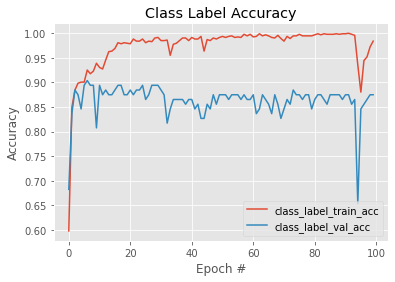

In [48]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom111_training_label_accuracy');

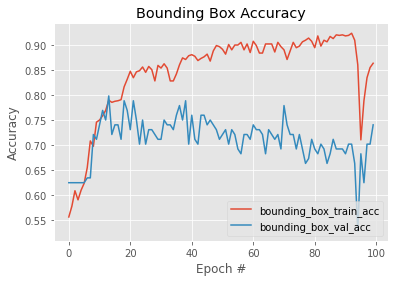

In [49]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom11_training_bounding_box_accuracy');

### Modeling - Custom12

In [50]:
# doubling the layers in the bounding box head

In [51]:
# creating custom model12
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(512, activation="relu")(flat)
bbox_head2 = Dropout(0.2)(bbox_head1)
bbox_head3 = Dense(512, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.2)(bbox_head3)
bbox_head5 = Dense(512, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.2)(bbox_head5)
bbox_head7 = Dense(512, activation="relu")(bbox_head6)
bbox_head8 = Dropout(0.2)(bbox_head7)
bbox_head9 = Dense(512, activation="relu")(bbox_head8)
bbox_head10 = Dropout(0.2)(bbox_head9)
bbox_head11 = Dense(512, activation="relu")(bbox_head10)
bbox_head12 = Dropout(0.2)(bbox_head11)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head12)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom12 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.001
opt = Adam(learning_rate = 0.001)

# compiling the model
model_custom12.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom12.summary())

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_12[0][0]           
_______________________________________________________________________________________

In [53]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom12.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=50, verbose=1)

Epoch 1/50
30/30 [==============================] - 33s 1s/step - loss: 0.7919 - bounding_box_loss: 0.0351 - class_label_loss: 0.7568 - bounding_box_accuracy: 0.5801 - class_label_accuracy: 0.5267 - val_loss: 0.5994 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.5838 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8462
Epoch 2/50
30/30 [==============================] - 37s 1s/step - loss: 0.4964 - bounding_box_loss: 0.0179 - class_label_loss: 0.4785 - bounding_box_accuracy: 0.5652 - class_label_accuracy: 0.7949 - val_loss: 0.4070 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.3927 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
Epoch 3/50
30/30 [==============================] - 36s 1s/step - loss: 0.4150 - bounding_box_loss: 0.0156 - class_label_loss: 0.3994 - bounding_box_accuracy: 0.5823 - class_label_accuracy: 0.8632 - val_loss: 0.4085 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.3951 - val_bounding_box_ac

30/30 [==============================] - 37s 1s/step - loss: 0.0176 - bounding_box_loss: 0.0025 - class_label_loss: 0.0151 - bounding_box_accuracy: 0.8408 - class_label_accuracy: 0.9979 - val_loss: 0.6252 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6173 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
Epoch 48/50
30/30 [==============================] - 37s 1s/step - loss: 0.0084 - bounding_box_loss: 0.0024 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 0.9968 - val_loss: 0.8474 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.8401 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
Epoch 49/50
30/30 [==============================] - 37s 1s/step - loss: 0.0088 - bounding_box_loss: 0.0024 - class_label_loss: 0.0064 - bounding_box_accuracy: 0.8536 - class_label_accuracy: 0.9968 - val_loss: 0.8431 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.8350 - val_bounding_box_accuracy: 0

In [ ]:
# Epoch 1/50
# 30/30 [==============================] - 33s 1s/step - loss: 0.7919 - bounding_box_loss: 0.0351 - class_label_loss: 0.7568 - bounding_box_accuracy: 0.5801 - class_label_accuracy: 0.5267 - val_loss: 0.5994 - val_bounding_box_loss: 0.0156 - val_class_label_loss: 0.5838 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8462
# Epoch 2/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.4964 - bounding_box_loss: 0.0179 - class_label_loss: 0.4785 - bounding_box_accuracy: 0.5652 - class_label_accuracy: 0.7949 - val_loss: 0.4070 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.3927 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8462
# Epoch 3/50
# 30/30 [==============================] - 36s 1s/step - loss: 0.4150 - bounding_box_loss: 0.0156 - class_label_loss: 0.3994 - bounding_box_accuracy: 0.5823 - class_label_accuracy: 0.8632 - val_loss: 0.4085 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.3951 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 4/50
# 30/30 [==============================] - 35s 1s/step - loss: 0.3836 - bounding_box_loss: 0.0163 - class_label_loss: 0.3673 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.8600 - val_loss: 0.3347 - val_bounding_box_loss: 0.0129 - val_class_label_loss: 0.3218 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 5/50
# 30/30 [==============================] - 35s 1s/step - loss: 0.3265 - bounding_box_loss: 0.0147 - class_label_loss: 0.3118 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.8964 - val_loss: 0.2969 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.2834 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 6/50
# 30/30 [==============================] - 34s 1s/step - loss: 0.3165 - bounding_box_loss: 0.0151 - class_label_loss: 0.3014 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.8985 - val_loss: 0.5326 - val_bounding_box_loss: 0.0190 - val_class_label_loss: 0.5136 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7788
# Epoch 7/50
# 30/30 [==============================] - 35s 1s/step - loss: 0.3159 - bounding_box_loss: 0.0169 - class_label_loss: 0.2990 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.8932 - val_loss: 0.3983 - val_bounding_box_loss: 0.0134 - val_class_label_loss: 0.3849 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 8/50
# 30/30 [==============================] - 35s 1s/step - loss: 0.2654 - bounding_box_loss: 0.0154 - class_label_loss: 0.2500 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9113 - val_loss: 0.3334 - val_bounding_box_loss: 0.0124 - val_class_label_loss: 0.3210 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 9/50
# 30/30 [==============================] - 36s 1s/step - loss: 0.2013 - bounding_box_loss: 0.0140 - class_label_loss: 0.1874 - bounding_box_accuracy: 0.6165 - class_label_accuracy: 0.9412 - val_loss: 0.2529 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.2418 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 10/50
# 30/30 [==============================] - 39s 1s/step - loss: 0.1663 - bounding_box_loss: 0.0126 - class_label_loss: 0.1537 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9434 - val_loss: 0.4250 - val_bounding_box_loss: 0.0173 - val_class_label_loss: 0.4078 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 11/50
# 30/30 [==============================] - 41s 1s/step - loss: 0.1711 - bounding_box_loss: 0.0133 - class_label_loss: 0.1578 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9519 - val_loss: 0.2807 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.2704 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 12/50
# 30/30 [==============================] - 50s 2s/step - loss: 0.1611 - bounding_box_loss: 0.0135 - class_label_loss: 0.1476 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.9434 - val_loss: 0.4124 - val_bounding_box_loss: 0.0136 - val_class_label_loss: 0.3987 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 13/50
# 30/30 [==============================] - 59s 2s/step - loss: 0.1490 - bounding_box_loss: 0.0117 - class_label_loss: 0.1373 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9626 - val_loss: 0.3675 - val_bounding_box_loss: 0.0171 - val_class_label_loss: 0.3504 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 14/50
# 30/30 [==============================] - 63s 2s/step - loss: 0.1213 - bounding_box_loss: 0.0131 - class_label_loss: 0.1082 - bounding_box_accuracy: 0.5812 - class_label_accuracy: 0.9690 - val_loss: 0.3454 - val_bounding_box_loss: 0.0135 - val_class_label_loss: 0.3319 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 15/50
# 30/30 [==============================] - 57s 2s/step - loss: 0.1083 - bounding_box_loss: 0.0133 - class_label_loss: 0.0949 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9712 - val_loss: 0.8102 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.8000 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8654
# Epoch 16/50
# 30/30 [==============================] - 54s 2s/step - loss: 0.0879 - bounding_box_loss: 0.0102 - class_label_loss: 0.0777 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9712 - val_loss: 0.4905 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.4811 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9231
# Epoch 17/50
# 30/30 [==============================] - 55s 2s/step - loss: 0.0923 - bounding_box_loss: 0.0097 - class_label_loss: 0.0826 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.9701 - val_loss: 0.3502 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.3415 - val_bounding_box_accuracy: 0.5385 - val_class_label_accuracy: 0.8750
# Epoch 18/50
# 30/30 [==============================] - 58s 2s/step - loss: 0.1006 - bounding_box_loss: 0.0094 - class_label_loss: 0.0912 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9669 - val_loss: 0.4632 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.4545 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9038
# Epoch 19/50
# 30/30 [==============================] - 60s 2s/step - loss: 0.0582 - bounding_box_loss: 0.0081 - class_label_loss: 0.0501 - bounding_box_accuracy: 0.6453 - class_label_accuracy: 0.9786 - val_loss: 0.5891 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.5805 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9038
# Epoch 20/50
# 30/30 [==============================] - 59s 2s/step - loss: 0.0597 - bounding_box_loss: 0.0075 - class_label_loss: 0.0522 - bounding_box_accuracy: 0.6410 - class_label_accuracy: 0.9850 - val_loss: 0.4090 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.4012 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9327
# Epoch 21/50
# 30/30 [==============================] - 59s 2s/step - loss: 0.0396 - bounding_box_loss: 0.0071 - class_label_loss: 0.0324 - bounding_box_accuracy: 0.6699 - class_label_accuracy: 0.9861 - val_loss: 0.5473 - val_bounding_box_loss: 0.0074 - val_class_label_loss: 0.5399 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 22/50
# 30/30 [==============================] - 58s 2s/step - loss: 0.0519 - bounding_box_loss: 0.0066 - class_label_loss: 0.0453 - bounding_box_accuracy: 0.6998 - class_label_accuracy: 0.9861 - val_loss: 0.4916 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4842 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135
# Epoch 23/50
# 30/30 [==============================] - 60s 2s/step - loss: 0.0321 - bounding_box_loss: 0.0066 - class_label_loss: 0.0255 - bounding_box_accuracy: 0.7233 - class_label_accuracy: 0.9915 - val_loss: 0.6153 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.6069 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9038
# Epoch 24/50
# 30/30 [==============================] - 59s 2s/step - loss: 0.0425 - bounding_box_loss: 0.0062 - class_label_loss: 0.0363 - bounding_box_accuracy: 0.7265 - class_label_accuracy: 0.9850 - val_loss: 0.6089 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.6004 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 25/50
# 30/30 [==============================] - 58s 2s/step - loss: 0.0237 - bounding_box_loss: 0.0059 - class_label_loss: 0.0178 - bounding_box_accuracy: 0.7350 - class_label_accuracy: 0.9904 - val_loss: 0.5554 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.5476 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 26/50
# 30/30 [==============================] - 56s 2s/step - loss: 0.0461 - bounding_box_loss: 0.0057 - class_label_loss: 0.0404 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 0.9850 - val_loss: 0.5259 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.5156 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 27/50
# 30/30 [==============================] - 57s 2s/step - loss: 0.3046 - bounding_box_loss: 0.0108 - class_label_loss: 0.2937 - bounding_box_accuracy: 0.7190 - class_label_accuracy: 0.8878 - val_loss: 1.0863 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 1.0753 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 28/50
# 30/30 [==============================] - 57s 2s/step - loss: 0.0859 - bounding_box_loss: 0.0071 - class_label_loss: 0.0788 - bounding_box_accuracy: 0.6955 - class_label_accuracy: 0.9797 - val_loss: 0.3976 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.3891 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9135
# Epoch 29/50
# 30/30 [==============================] - 59s 2s/step - loss: 0.0494 - bounding_box_loss: 0.0058 - class_label_loss: 0.0436 - bounding_box_accuracy: 0.7575 - class_label_accuracy: 0.9840 - val_loss: 0.6656 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.6579 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8846
# Epoch 30/50
# 30/30 [==============================] - 48s 2s/step - loss: 0.0303 - bounding_box_loss: 0.0055 - class_label_loss: 0.0248 - bounding_box_accuracy: 0.7671 - class_label_accuracy: 0.9882 - val_loss: 0.4690 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.4610 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 31/50
# 30/30 [==============================] - 38s 1s/step - loss: 0.0243 - bounding_box_loss: 0.0051 - class_label_loss: 0.0192 - bounding_box_accuracy: 0.7842 - class_label_accuracy: 0.9893 - val_loss: 1.1141 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.1061 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 32/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0401 - bounding_box_loss: 0.0053 - class_label_loss: 0.0348 - bounding_box_accuracy: 0.7981 - class_label_accuracy: 0.9904 - val_loss: 0.4886 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.4804 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 33/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0337 - bounding_box_loss: 0.0048 - class_label_loss: 0.0289 - bounding_box_accuracy: 0.8141 - class_label_accuracy: 0.9893 - val_loss: 0.6093 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.6010 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9135
# Epoch 34/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0279 - bounding_box_loss: 0.0046 - class_label_loss: 0.0233 - bounding_box_accuracy: 0.8205 - class_label_accuracy: 0.9915 - val_loss: 0.6410 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6331 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9135
# Epoch 35/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0270 - bounding_box_loss: 0.0039 - class_label_loss: 0.0231 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 0.9915 - val_loss: 0.6051 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.5970 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 36/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0186 - bounding_box_loss: 0.0039 - class_label_loss: 0.0148 - bounding_box_accuracy: 0.8291 - class_label_accuracy: 0.9925 - val_loss: 0.8161 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.8081 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 37/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0157 - bounding_box_loss: 0.0037 - class_label_loss: 0.0120 - bounding_box_accuracy: 0.8216 - class_label_accuracy: 0.9947 - val_loss: 0.8650 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.8567 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 38/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0213 - bounding_box_loss: 0.0036 - class_label_loss: 0.0178 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 0.9925 - val_loss: 0.8850 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.8762 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 39/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0235 - bounding_box_loss: 0.0038 - class_label_loss: 0.0197 - bounding_box_accuracy: 0.8173 - class_label_accuracy: 0.9925 - val_loss: 0.5803 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.5725 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 40/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0263 - bounding_box_loss: 0.0034 - class_label_loss: 0.0229 - bounding_box_accuracy: 0.8355 - class_label_accuracy: 0.9893 - val_loss: 0.7537 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.7457 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9038
# Epoch 41/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0127 - bounding_box_loss: 0.0034 - class_label_loss: 0.0094 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 0.9979 - val_loss: 1.0210 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 1.0130 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 42/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0143 - bounding_box_loss: 0.0038 - class_label_loss: 0.0106 - bounding_box_accuracy: 0.8429 - class_label_accuracy: 0.9957 - val_loss: 0.9290 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.9204 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 43/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0111 - bounding_box_loss: 0.0032 - class_label_loss: 0.0079 - bounding_box_accuracy: 0.8536 - class_label_accuracy: 0.9968 - val_loss: 0.9368 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.9276 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8942
# Epoch 44/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0059 - bounding_box_loss: 0.0029 - class_label_loss: 0.0030 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.9989 - val_loss: 0.9028 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.8943 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 45/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0124 - bounding_box_loss: 0.0027 - class_label_loss: 0.0097 - bounding_box_accuracy: 0.8494 - class_label_accuracy: 0.9957 - val_loss: 0.6553 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.6472 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9038
# Epoch 46/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0103 - bounding_box_loss: 0.0024 - class_label_loss: 0.0079 - bounding_box_accuracy: 0.8568 - class_label_accuracy: 0.9979 - val_loss: 0.7139 - val_bounding_box_loss: 0.0082 - val_class_label_loss: 0.7056 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 47/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0176 - bounding_box_loss: 0.0025 - class_label_loss: 0.0151 - bounding_box_accuracy: 0.8408 - class_label_accuracy: 0.9979 - val_loss: 0.6252 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6173 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 48/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0084 - bounding_box_loss: 0.0024 - class_label_loss: 0.0060 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 0.9968 - val_loss: 0.8474 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.8401 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 49/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0088 - bounding_box_loss: 0.0024 - class_label_loss: 0.0064 - bounding_box_accuracy: 0.8536 - class_label_accuracy: 0.9968 - val_loss: 0.8431 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.8350 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 50/50
# 30/30 [==============================] - 37s 1s/step - loss: 0.0118 - bounding_box_loss: 0.0023 - class_label_loss: 0.0096 - bounding_box_accuracy: 0.8515 - class_label_accuracy: 0.9936 - val_loss: 0.8976 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.8899 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135

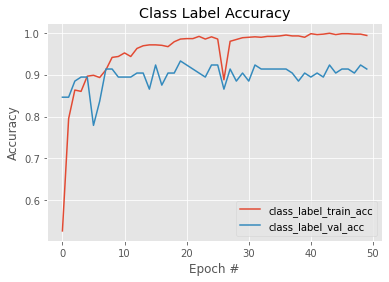

In [54]:
# plotting the class label accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom12_training_label_accuracy');

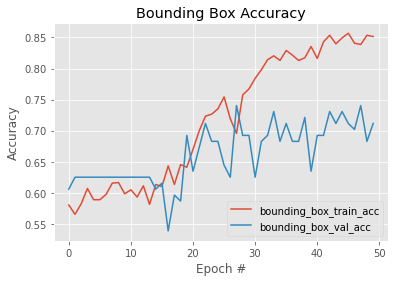

In [55]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 50) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom12_training_bounding_box_accuracy');

### Modeling - Custom13

In [56]:
# changing learning rate and increasing epochs

In [59]:
# creating custom model13
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(512, activation="relu")(flat)
bbox_head2 = Dropout(0.2)(bbox_head1)
bbox_head3 = Dense(512, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.2)(bbox_head3)
bbox_head5 = Dense(512, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.2)(bbox_head5)
bbox_head7 = Dense(512, activation="relu")(bbox_head6)
bbox_head8 = Dropout(0.2)(bbox_head7)
bbox_head9 = Dense(512, activation="relu")(bbox_head8)
bbox_head10 = Dropout(0.2)(bbox_head9)
bbox_head11 = Dense(512, activation="relu")(bbox_head10)
bbox_head12 = Dropout(0.2)(bbox_head11)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head12)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom13 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
model_custom13.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom13.summary())

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 111, 111, 32) 0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 109, 109, 64) 18496       max_pooling2d_21[0][0]           
______________________________________________________________________________________

In [60]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom13.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 33s 1s/step - loss: 0.7415 - bounding_box_loss: 0.0377 - class_label_loss: 0.7037 - bounding_box_accuracy: 0.5342 - class_label_accuracy: 0.5256 - val_loss: 0.6626 - val_bounding_box_loss: 0.0196 - val_class_label_loss: 0.6430 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
Epoch 2/100
30/30 [==============================] - 34s 1s/step - loss: 0.6532 - bounding_box_loss: 0.0202 - class_label_loss: 0.6330 - bounding_box_accuracy: 0.5726 - class_label_accuracy: 0.6848 - val_loss: 0.5214 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.5081 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
Epoch 3/100
30/30 [==============================] - 35s 1s/step - loss: 0.5030 - bounding_box_loss: 0.0162 - class_label_loss: 0.4868 - bounding_box_accuracy: 0.5385 - class_label_accuracy: 0.8280 - val_loss: 0.3978 - val_bounding_box_loss: 0.0161 - val_class_label_loss: 0.3817 - val_bounding_box

30/30 [==============================] - 37s 1s/step - loss: 0.0174 - bounding_box_loss: 0.0028 - class_label_loss: 0.0147 - bounding_box_accuracy: 0.8333 - class_label_accuracy: 0.9947 - val_loss: 0.5819 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.5739 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
Epoch 48/100
30/30 [==============================] - 37s 1s/step - loss: 0.0150 - bounding_box_loss: 0.0026 - class_label_loss: 0.0124 - bounding_box_accuracy: 0.8483 - class_label_accuracy: 0.9957 - val_loss: 0.5601 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.5501 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
Epoch 49/100
30/30 [==============================] - 37s 1s/step - loss: 0.0149 - bounding_box_loss: 0.0027 - class_label_loss: 0.0122 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9957 - val_loss: 0.6453 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.6349 - val_bounding_box_accuracy:

30/30 [==============================] - 37s 1s/step - loss: 0.0080 - bounding_box_loss: 0.0015 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.8953 - class_label_accuracy: 0.9979 - val_loss: 0.7221 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.7117 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8942
Epoch 94/100
30/30 [==============================] - 37s 1s/step - loss: 0.0053 - bounding_box_loss: 0.0014 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.8782 - class_label_accuracy: 0.9989 - val_loss: 0.7171 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.7077 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
Epoch 95/100
30/30 [==============================] - 37s 1s/step - loss: 0.0042 - bounding_box_loss: 0.0014 - class_label_loss: 0.0028 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9989 - val_loss: 0.7846 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.7742 - val_bounding_box_accuracy:

In [61]:
# Epoch 1/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.7415 - bounding_box_loss: 0.0377 - class_label_loss: 0.7037 - bounding_box_accuracy: 0.5342 - class_label_accuracy: 0.5256 - val_loss: 0.6626 - val_bounding_box_loss: 0.0196 - val_class_label_loss: 0.6430 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.6058
# Epoch 2/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.6532 - bounding_box_loss: 0.0202 - class_label_loss: 0.6330 - bounding_box_accuracy: 0.5726 - class_label_accuracy: 0.6848 - val_loss: 0.5214 - val_bounding_box_loss: 0.0133 - val_class_label_loss: 0.5081 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 3/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.5030 - bounding_box_loss: 0.0162 - class_label_loss: 0.4868 - bounding_box_accuracy: 0.5385 - class_label_accuracy: 0.8280 - val_loss: 0.3978 - val_bounding_box_loss: 0.0161 - val_class_label_loss: 0.3817 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 4/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.4402 - bounding_box_loss: 0.0156 - class_label_loss: 0.4246 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.8440 - val_loss: 0.3729 - val_bounding_box_loss: 0.0143 - val_class_label_loss: 0.3585 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 5/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.3799 - bounding_box_loss: 0.0143 - class_label_loss: 0.3655 - bounding_box_accuracy: 0.5876 - class_label_accuracy: 0.8857 - val_loss: 0.3481 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.3364 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 6/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.3350 - bounding_box_loss: 0.0136 - class_label_loss: 0.3215 - bounding_box_accuracy: 0.5801 - class_label_accuracy: 0.8996 - val_loss: 0.3659 - val_bounding_box_loss: 0.0117 - val_class_label_loss: 0.3542 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
# Epoch 7/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.3095 - bounding_box_loss: 0.0130 - class_label_loss: 0.2965 - bounding_box_accuracy: 0.5940 - class_label_accuracy: 0.9113 - val_loss: 0.3095 - val_bounding_box_loss: 0.0111 - val_class_label_loss: 0.2985 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 8/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.2888 - bounding_box_loss: 0.0129 - class_label_loss: 0.2759 - bounding_box_accuracy: 0.5609 - class_label_accuracy: 0.9092 - val_loss: 0.3474 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.3372 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
# Epoch 9/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.2645 - bounding_box_loss: 0.0123 - class_label_loss: 0.2522 - bounding_box_accuracy: 0.5887 - class_label_accuracy: 0.9167 - val_loss: 0.2852 - val_bounding_box_loss: 0.0119 - val_class_label_loss: 0.2733 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 10/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.2414 - bounding_box_loss: 0.0118 - class_label_loss: 0.2296 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9231 - val_loss: 0.3475 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.3371 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8654
# Epoch 11/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.2136 - bounding_box_loss: 0.0113 - class_label_loss: 0.2022 - bounding_box_accuracy: 0.5897 - class_label_accuracy: 0.9231 - val_loss: 0.3460 - val_bounding_box_loss: 0.0132 - val_class_label_loss: 0.3327 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8654
# Epoch 12/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.1983 - bounding_box_loss: 0.0116 - class_label_loss: 0.1867 - bounding_box_accuracy: 0.5962 - class_label_accuracy: 0.9423 - val_loss: 0.2864 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.2757 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 13/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.1534 - bounding_box_loss: 0.0113 - class_label_loss: 0.1420 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 0.9605 - val_loss: 0.3199 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.3102 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 14/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.1739 - bounding_box_loss: 0.0107 - class_label_loss: 0.1632 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.9509 - val_loss: 0.2862 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.2756 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 15/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.1253 - bounding_box_loss: 0.0103 - class_label_loss: 0.1151 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9637 - val_loss: 0.3701 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.3594 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 16/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.1255 - bounding_box_loss: 0.0098 - class_label_loss: 0.1157 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9690 - val_loss: 0.3243 - val_bounding_box_loss: 0.0102 - val_class_label_loss: 0.3141 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 17/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.1101 - bounding_box_loss: 0.0091 - class_label_loss: 0.1010 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.9679 - val_loss: 0.2794 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.2706 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 18/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0820 - bounding_box_loss: 0.0086 - class_label_loss: 0.0734 - bounding_box_accuracy: 0.6453 - class_label_accuracy: 0.9754 - val_loss: 0.3224 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.3130 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 19/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0717 - bounding_box_loss: 0.0085 - class_label_loss: 0.0631 - bounding_box_accuracy: 0.6549 - class_label_accuracy: 0.9808 - val_loss: 0.3471 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.3388 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9038
# Epoch 20/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0636 - bounding_box_loss: 0.0077 - class_label_loss: 0.0559 - bounding_box_accuracy: 0.6464 - class_label_accuracy: 0.9840 - val_loss: 0.3533 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.3437 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9038
# Epoch 21/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0555 - bounding_box_loss: 0.0076 - class_label_loss: 0.0479 - bounding_box_accuracy: 0.6400 - class_label_accuracy: 0.9861 - val_loss: 0.4936 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.4849 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8846
# Epoch 22/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0596 - bounding_box_loss: 0.0073 - class_label_loss: 0.0523 - bounding_box_accuracy: 0.6389 - class_label_accuracy: 0.9808 - val_loss: 0.3304 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.3223 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8942
# Epoch 23/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0497 - bounding_box_loss: 0.0071 - class_label_loss: 0.0427 - bounding_box_accuracy: 0.6741 - class_label_accuracy: 0.9893 - val_loss: 0.4657 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.4565 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 24/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0566 - bounding_box_loss: 0.0068 - class_label_loss: 0.0499 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 0.9818 - val_loss: 0.4152 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.4046 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8654
# Epoch 25/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0719 - bounding_box_loss: 0.0067 - class_label_loss: 0.0653 - bounding_box_accuracy: 0.7019 - class_label_accuracy: 0.9754 - val_loss: 0.4065 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.3978 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 26/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0490 - bounding_box_loss: 0.0060 - class_label_loss: 0.0430 - bounding_box_accuracy: 0.7212 - class_label_accuracy: 0.9893 - val_loss: 0.3850 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.3764 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8654
# Epoch 27/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0396 - bounding_box_loss: 0.0057 - class_label_loss: 0.0339 - bounding_box_accuracy: 0.7244 - class_label_accuracy: 0.9893 - val_loss: 0.5200 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.5105 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9135
# Epoch 28/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0328 - bounding_box_loss: 0.0053 - class_label_loss: 0.0276 - bounding_box_accuracy: 0.7457 - class_label_accuracy: 0.9915 - val_loss: 0.3796 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.3707 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8750
# Epoch 29/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0447 - bounding_box_loss: 0.0049 - class_label_loss: 0.0398 - bounding_box_accuracy: 0.7821 - class_label_accuracy: 0.9872 - val_loss: 0.4685 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.4605 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 30/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0400 - bounding_box_loss: 0.0049 - class_label_loss: 0.0351 - bounding_box_accuracy: 0.7596 - class_label_accuracy: 0.9893 - val_loss: 0.6175 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6096 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.8846
# Epoch 31/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0249 - bounding_box_loss: 0.0050 - class_label_loss: 0.0199 - bounding_box_accuracy: 0.7756 - class_label_accuracy: 0.9936 - val_loss: 0.5226 - val_bounding_box_loss: 0.0115 - val_class_label_loss: 0.5111 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 32/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0262 - bounding_box_loss: 0.0049 - class_label_loss: 0.0213 - bounding_box_accuracy: 0.7853 - class_label_accuracy: 0.9893 - val_loss: 0.4440 - val_bounding_box_loss: 0.0122 - val_class_label_loss: 0.4318 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9038
# Epoch 33/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0293 - bounding_box_loss: 0.0047 - class_label_loss: 0.0245 - bounding_box_accuracy: 0.7714 - class_label_accuracy: 0.9947 - val_loss: 0.4758 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.4672 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8558
# Epoch 34/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0390 - bounding_box_loss: 0.0043 - class_label_loss: 0.0347 - bounding_box_accuracy: 0.8098 - class_label_accuracy: 0.9872 - val_loss: 0.4484 - val_bounding_box_loss: 0.0110 - val_class_label_loss: 0.4374 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8558
# Epoch 35/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0292 - bounding_box_loss: 0.0041 - class_label_loss: 0.0251 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9915 - val_loss: 0.5046 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.4955 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 36/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0267 - bounding_box_loss: 0.0038 - class_label_loss: 0.0229 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 0.9936 - val_loss: 0.7499 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.7412 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 37/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0275 - bounding_box_loss: 0.0035 - class_label_loss: 0.0240 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 0.9915 - val_loss: 0.4637 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.4548 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9038
# Epoch 38/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0292 - bounding_box_loss: 0.0035 - class_label_loss: 0.0257 - bounding_box_accuracy: 0.8120 - class_label_accuracy: 0.9915 - val_loss: 0.4467 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.4372 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8942
# Epoch 39/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0308 - bounding_box_loss: 0.0040 - class_label_loss: 0.0268 - bounding_box_accuracy: 0.7959 - class_label_accuracy: 0.9947 - val_loss: 0.5837 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.5750 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9135
# Epoch 40/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0217 - bounding_box_loss: 0.0034 - class_label_loss: 0.0183 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.9947 - val_loss: 0.6352 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.6274 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
# Epoch 41/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0232 - bounding_box_loss: 0.0032 - class_label_loss: 0.0200 - bounding_box_accuracy: 0.8483 - class_label_accuracy: 0.9936 - val_loss: 0.5482 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.5388 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 42/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0248 - bounding_box_loss: 0.0030 - class_label_loss: 0.0218 - bounding_box_accuracy: 0.8248 - class_label_accuracy: 0.9925 - val_loss: 0.5218 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.5125 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8750
# Epoch 43/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0213 - bounding_box_loss: 0.0028 - class_label_loss: 0.0185 - bounding_box_accuracy: 0.8173 - class_label_accuracy: 0.9936 - val_loss: 0.5841 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.5758 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9135
# Epoch 44/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0189 - bounding_box_loss: 0.0028 - class_label_loss: 0.0160 - bounding_box_accuracy: 0.8259 - class_label_accuracy: 0.9947 - val_loss: 0.5350 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.5260 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9038
# Epoch 45/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0117 - bounding_box_loss: 0.0031 - class_label_loss: 0.0086 - bounding_box_accuracy: 0.8472 - class_label_accuracy: 0.9979 - val_loss: 0.5538 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.5446 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 46/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0182 - bounding_box_loss: 0.0028 - class_label_loss: 0.0154 - bounding_box_accuracy: 0.8429 - class_label_accuracy: 0.9947 - val_loss: 0.4919 - val_bounding_box_loss: 0.0108 - val_class_label_loss: 0.4811 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 47/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0174 - bounding_box_loss: 0.0028 - class_label_loss: 0.0147 - bounding_box_accuracy: 0.8333 - class_label_accuracy: 0.9947 - val_loss: 0.5819 - val_bounding_box_loss: 0.0080 - val_class_label_loss: 0.5739 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 48/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0150 - bounding_box_loss: 0.0026 - class_label_loss: 0.0124 - bounding_box_accuracy: 0.8483 - class_label_accuracy: 0.9957 - val_loss: 0.5601 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.5501 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 49/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0149 - bounding_box_loss: 0.0027 - class_label_loss: 0.0122 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 0.9957 - val_loss: 0.6453 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.6349 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9135
# Epoch 50/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0162 - bounding_box_loss: 0.0024 - class_label_loss: 0.0139 - bounding_box_accuracy: 0.8483 - class_label_accuracy: 0.9936 - val_loss: 0.5500 - val_bounding_box_loss: 0.0081 - val_class_label_loss: 0.5419 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9135
# Epoch 51/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0107 - bounding_box_loss: 0.0022 - class_label_loss: 0.0086 - bounding_box_accuracy: 0.8494 - class_label_accuracy: 0.9979 - val_loss: 0.5893 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.5801 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 52/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0163 - bounding_box_loss: 0.0022 - class_label_loss: 0.0141 - bounding_box_accuracy: 0.8729 - class_label_accuracy: 0.9957 - val_loss: 0.6696 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.6603 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9135
# Epoch 53/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0128 - bounding_box_loss: 0.0023 - class_label_loss: 0.0105 - bounding_box_accuracy: 0.8526 - class_label_accuracy: 0.9968 - val_loss: 0.7989 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.7890 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8942
# Epoch 54/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0211 - bounding_box_loss: 0.0023 - class_label_loss: 0.0188 - bounding_box_accuracy: 0.8536 - class_label_accuracy: 0.9947 - val_loss: 0.5080 - val_bounding_box_loss: 0.0112 - val_class_label_loss: 0.4967 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9038
# Epoch 55/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0168 - bounding_box_loss: 0.0022 - class_label_loss: 0.0147 - bounding_box_accuracy: 0.8323 - class_label_accuracy: 0.9957 - val_loss: 0.8009 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 0.7922 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8846
# Epoch 56/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0101 - bounding_box_loss: 0.0020 - class_label_loss: 0.0080 - bounding_box_accuracy: 0.8387 - class_label_accuracy: 1.0000 - val_loss: 0.6541 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.6453 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9038
# Epoch 57/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0200 - bounding_box_loss: 0.0022 - class_label_loss: 0.0178 - bounding_box_accuracy: 0.8568 - class_label_accuracy: 0.9947 - val_loss: 0.5872 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.5774 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 58/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0144 - bounding_box_loss: 0.0024 - class_label_loss: 0.0120 - bounding_box_accuracy: 0.8632 - class_label_accuracy: 0.9968 - val_loss: 0.6974 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.6866 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9135
# Epoch 59/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0099 - bounding_box_loss: 0.0020 - class_label_loss: 0.0080 - bounding_box_accuracy: 0.8665 - class_label_accuracy: 0.9968 - val_loss: 0.6098 - val_bounding_box_loss: 0.0079 - val_class_label_loss: 0.6019 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9038
# Epoch 60/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0125 - bounding_box_loss: 0.0017 - class_label_loss: 0.0108 - bounding_box_accuracy: 0.8654 - class_label_accuracy: 0.9957 - val_loss: 0.7018 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.6928 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8942
# Epoch 61/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0088 - bounding_box_loss: 0.0020 - class_label_loss: 0.0069 - bounding_box_accuracy: 0.8558 - class_label_accuracy: 0.9968 - val_loss: 0.6291 - val_bounding_box_loss: 0.0096 - val_class_label_loss: 0.6195 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 62/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0066 - bounding_box_loss: 0.0019 - class_label_loss: 0.0047 - bounding_box_accuracy: 0.8590 - class_label_accuracy: 0.9989 - val_loss: 0.7186 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.7100 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9038
# Epoch 63/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0058 - bounding_box_loss: 0.0018 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.8686 - class_label_accuracy: 1.0000 - val_loss: 0.6946 - val_bounding_box_loss: 0.0090 - val_class_label_loss: 0.6856 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9135
# Epoch 64/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0067 - bounding_box_loss: 0.0018 - class_label_loss: 0.0049 - bounding_box_accuracy: 0.8632 - class_label_accuracy: 0.9979 - val_loss: 0.7110 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.7011 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9038
# Epoch 65/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0074 - bounding_box_loss: 0.0019 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.8707 - class_label_accuracy: 0.9989 - val_loss: 0.7195 - val_bounding_box_loss: 0.0105 - val_class_label_loss: 0.7090 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 66/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0019 - class_label_loss: 0.0041 - bounding_box_accuracy: 0.8590 - class_label_accuracy: 0.9989 - val_loss: 0.6718 - val_bounding_box_loss: 0.0084 - val_class_label_loss: 0.6635 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 67/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0019 - class_label_loss: 0.0081 - bounding_box_accuracy: 0.8761 - class_label_accuracy: 0.9968 - val_loss: 0.6298 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.6200 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8846
# Epoch 68/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0074 - bounding_box_loss: 0.0018 - class_label_loss: 0.0056 - bounding_box_accuracy: 0.8782 - class_label_accuracy: 0.9979 - val_loss: 0.6985 - val_bounding_box_loss: 0.0107 - val_class_label_loss: 0.6879 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 69/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0090 - bounding_box_loss: 0.0017 - class_label_loss: 0.0073 - bounding_box_accuracy: 0.8750 - class_label_accuracy: 0.9979 - val_loss: 0.7131 - val_bounding_box_loss: 0.0106 - val_class_label_loss: 0.7025 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8462
# Epoch 70/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0077 - bounding_box_loss: 0.0018 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.8547 - class_label_accuracy: 1.0000 - val_loss: 0.6910 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.6818 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 71/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0118 - bounding_box_loss: 0.0019 - class_label_loss: 0.0099 - bounding_box_accuracy: 0.8654 - class_label_accuracy: 0.9957 - val_loss: 0.6980 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.6887 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 72/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0089 - bounding_box_loss: 0.0016 - class_label_loss: 0.0073 - bounding_box_accuracy: 0.8611 - class_label_accuracy: 0.9989 - val_loss: 0.7734 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.7639 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9135
# Epoch 73/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0087 - bounding_box_loss: 0.0018 - class_label_loss: 0.0070 - bounding_box_accuracy: 0.8504 - class_label_accuracy: 0.9979 - val_loss: 0.6722 - val_bounding_box_loss: 0.0069 - val_class_label_loss: 0.6653 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8942
# Epoch 74/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0223 - bounding_box_loss: 0.0022 - class_label_loss: 0.0202 - bounding_box_accuracy: 0.8761 - class_label_accuracy: 0.9915 - val_loss: 0.6748 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.6665 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 75/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0101 - bounding_box_loss: 0.0022 - class_label_loss: 0.0080 - bounding_box_accuracy: 0.8686 - class_label_accuracy: 1.0000 - val_loss: 0.6609 - val_bounding_box_loss: 0.0077 - val_class_label_loss: 0.6532 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8846
# Epoch 76/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0099 - bounding_box_loss: 0.0018 - class_label_loss: 0.0081 - bounding_box_accuracy: 0.8761 - class_label_accuracy: 0.9979 - val_loss: 0.6769 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.6671 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9038
# Epoch 77/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0098 - bounding_box_loss: 0.0018 - class_label_loss: 0.0080 - bounding_box_accuracy: 0.8568 - class_label_accuracy: 0.9979 - val_loss: 0.6418 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.6331 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 78/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0044 - bounding_box_loss: 0.0016 - class_label_loss: 0.0028 - bounding_box_accuracy: 0.8771 - class_label_accuracy: 1.0000 - val_loss: 0.6829 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.6746 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9038
# Epoch 79/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0035 - bounding_box_loss: 0.0017 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.8771 - class_label_accuracy: 1.0000 - val_loss: 0.7695 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.7601 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 80/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0047 - bounding_box_loss: 0.0017 - class_label_loss: 0.0031 - bounding_box_accuracy: 0.8729 - class_label_accuracy: 0.9989 - val_loss: 0.7273 - val_bounding_box_loss: 0.0091 - val_class_label_loss: 0.7182 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8846
# Epoch 81/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0070 - bounding_box_loss: 0.0015 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.8782 - class_label_accuracy: 0.9979 - val_loss: 0.7494 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.7395 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 82/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0016 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.8964 - class_label_accuracy: 0.9989 - val_loss: 0.7684 - val_bounding_box_loss: 0.0100 - val_class_label_loss: 0.7584 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 83/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0044 - bounding_box_loss: 0.0015 - class_label_loss: 0.0029 - bounding_box_accuracy: 0.8814 - class_label_accuracy: 0.9989 - val_loss: 0.7808 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.7722 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9038
# Epoch 84/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0064 - bounding_box_loss: 0.0015 - class_label_loss: 0.0049 - bounding_box_accuracy: 0.8803 - class_label_accuracy: 0.9989 - val_loss: 0.7591 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 0.7488 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9038
# Epoch 85/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0138 - bounding_box_loss: 0.0017 - class_label_loss: 0.0120 - bounding_box_accuracy: 0.8643 - class_label_accuracy: 0.9979 - val_loss: 0.7363 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.7271 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 86/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0056 - bounding_box_loss: 0.0016 - class_label_loss: 0.0040 - bounding_box_accuracy: 0.8846 - class_label_accuracy: 0.9979 - val_loss: 0.7241 - val_bounding_box_loss: 0.0095 - val_class_label_loss: 0.7145 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8654
# Epoch 87/100
# 30/30 [==============================] - 38s 1s/step - loss: 0.0206 - bounding_box_loss: 0.0018 - class_label_loss: 0.0187 - bounding_box_accuracy: 0.8761 - class_label_accuracy: 0.9947 - val_loss: 0.9380 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.9280 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8654
# Epoch 88/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0205 - bounding_box_loss: 0.0017 - class_label_loss: 0.0188 - bounding_box_accuracy: 0.8739 - class_label_accuracy: 0.9936 - val_loss: 0.7106 - val_bounding_box_loss: 0.0085 - val_class_label_loss: 0.7021 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.8846
# Epoch 89/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0086 - bounding_box_loss: 0.0015 - class_label_loss: 0.0071 - bounding_box_accuracy: 0.8942 - class_label_accuracy: 0.9979 - val_loss: 0.6766 - val_bounding_box_loss: 0.0098 - val_class_label_loss: 0.6668 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9038
# Epoch 90/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0070 - bounding_box_loss: 0.0015 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.8803 - class_label_accuracy: 0.9989 - val_loss: 0.6739 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.6653 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8942
# Epoch 91/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0082 - bounding_box_loss: 0.0015 - class_label_loss: 0.0067 - bounding_box_accuracy: 0.8889 - class_label_accuracy: 0.9989 - val_loss: 0.6938 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.6846 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9135
# Epoch 92/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0054 - bounding_box_loss: 0.0015 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.8793 - class_label_accuracy: 0.9989 - val_loss: 0.6985 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.6893 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 93/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0080 - bounding_box_loss: 0.0015 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.8953 - class_label_accuracy: 0.9979 - val_loss: 0.7221 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.7117 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.8942
# Epoch 94/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0053 - bounding_box_loss: 0.0014 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.8782 - class_label_accuracy: 0.9989 - val_loss: 0.7171 - val_bounding_box_loss: 0.0093 - val_class_label_loss: 0.7077 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
# Epoch 95/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0042 - bounding_box_loss: 0.0014 - class_label_loss: 0.0028 - bounding_box_accuracy: 0.9060 - class_label_accuracy: 0.9989 - val_loss: 0.7846 - val_bounding_box_loss: 0.0104 - val_class_label_loss: 0.7742 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9038
# Epoch 96/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0057 - bounding_box_loss: 0.0015 - class_label_loss: 0.0042 - bounding_box_accuracy: 0.8803 - class_label_accuracy: 0.9979 - val_loss: 0.8471 - val_bounding_box_loss: 0.0089 - val_class_label_loss: 0.8382 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 97/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0073 - bounding_box_loss: 0.0015 - class_label_loss: 0.0058 - bounding_box_accuracy: 0.8793 - class_label_accuracy: 0.9968 - val_loss: 0.7687 - val_bounding_box_loss: 0.0092 - val_class_label_loss: 0.7595 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9038
# Epoch 98/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0121 - bounding_box_loss: 0.0017 - class_label_loss: 0.0104 - bounding_box_accuracy: 0.8686 - class_label_accuracy: 0.9979 - val_loss: 0.6273 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.6174 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9038
# Epoch 99/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0092 - bounding_box_loss: 0.0015 - class_label_loss: 0.0077 - bounding_box_accuracy: 0.8825 - class_label_accuracy: 0.9989 - val_loss: 0.7574 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 0.7492 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9038
# Epoch 100/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0090 - bounding_box_loss: 0.0015 - class_label_loss: 0.0075 - bounding_box_accuracy: 0.8974 - class_label_accuracy: 0.9989 - val_loss: 0.7013 - val_bounding_box_loss: 0.0097 - val_class_label_loss: 0.6916 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9038
# ​


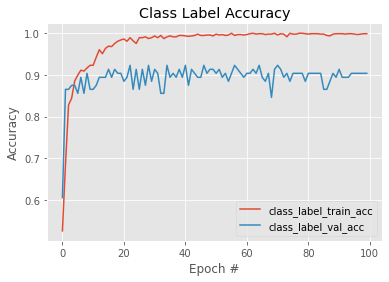

In [62]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom13_training_label_accuracy');

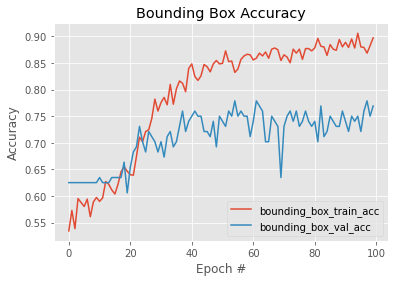

In [63]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom11_training_bounding_box_accuracy');

### Modeling - Custom14

In [23]:
# increasing the the proportion in the first 3 dropout layers in bounding box heads

In [24]:
# creating custom model14
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(512, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(512, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(512, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head7 = Dense(512, activation="relu")(bbox_head6)
bbox_head8 = Dropout(0.2)(bbox_head7)
bbox_head9 = Dense(512, activation="relu")(bbox_head8)
bbox_head10 = Dropout(0.2)(bbox_head9)
bbox_head11 = Dense(512, activation="relu")(bbox_head10)
bbox_head12 = Dropout(0.2)(bbox_head11)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head12)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom14 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
model_custom14.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom14.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 111, 111, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 109, 109, 64) 18496       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [25]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom14.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 31s 1s/step - loss: 0.7392 - bounding_box_loss: 0.0435 - class_label_loss: 0.6958 - bounding_box_accuracy: 0.4882 - class_label_accuracy: 0.5726 - val_loss: 0.6879 - val_bounding_box_loss: 0.0463 - val_class_label_loss: 0.6416 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6731
Epoch 2/100
30/30 [==============================] - 34s 1s/step - loss: 0.6042 - bounding_box_loss: 0.0219 - class_label_loss: 0.5823 - bounding_box_accuracy: 0.5481 - class_label_accuracy: 0.7671 - val_loss: 0.4777 - val_bounding_box_loss: 0.0318 - val_class_label_loss: 0.4459 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
Epoch 3/100
30/30 [==============================] - 34s 1s/step - loss: 0.4815 - bounding_box_loss: 0.0169 - class_label_loss: 0.4646 - bounding_box_accuracy: 0.5524 - class_label_accuracy: 0.8248 - val_loss: 0.4223 - val_bounding_box_loss: 0.0335 - val_class_label_loss: 0.3888 - val_bounding_box

30/30 [==============================] - 36s 1s/step - loss: 0.0693 - bounding_box_loss: 0.0104 - class_label_loss: 0.0588 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9776 - val_loss: 0.4716 - val_bounding_box_loss: 0.0400 - val_class_label_loss: 0.4316 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9038
Epoch 25/100
30/30 [==============================] - 35s 1s/step - loss: 0.0741 - bounding_box_loss: 0.0105 - class_label_loss: 0.0636 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9808 - val_loss: 0.5586 - val_bounding_box_loss: 0.0316 - val_class_label_loss: 0.5271 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
Epoch 26/100
30/30 [==============================] - 36s 1s/step - loss: 0.0622 - bounding_box_loss: 0.0106 - class_label_loss: 0.0516 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9840 - val_loss: 0.5398 - val_bounding_box_loss: 0.0377 - val_class_label_loss: 0.5021 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0225 - bounding_box_loss: 0.0090 - class_label_loss: 0.0135 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9947 - val_loss: 0.7002 - val_bounding_box_loss: 0.0412 - val_class_label_loss: 0.6590 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9135
Epoch 48/100
30/30 [==============================] - 36s 1s/step - loss: 0.0334 - bounding_box_loss: 0.0093 - class_label_loss: 0.0240 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9915 - val_loss: 0.5046 - val_bounding_box_loss: 0.0422 - val_class_label_loss: 0.4624 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.8942
Epoch 49/100
30/30 [==============================] - 36s 1s/step - loss: 0.0242 - bounding_box_loss: 0.0090 - class_label_loss: 0.0152 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9947 - val_loss: 0.5991 - val_bounding_box_loss: 0.0373 - val_class_label_loss: 0.5618 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0109 - bounding_box_loss: 0.0078 - class_label_loss: 0.0031 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 1.0000 - val_loss: 0.6827 - val_bounding_box_loss: 0.0316 - val_class_label_loss: 0.6511 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.8846
Epoch 71/100
30/30 [==============================] - 36s 1s/step - loss: 0.0129 - bounding_box_loss: 0.0075 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.6549 - class_label_accuracy: 0.9979 - val_loss: 0.8082 - val_bounding_box_loss: 0.0298 - val_class_label_loss: 0.7784 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
Epoch 72/100
30/30 [==============================] - 37s 1s/step - loss: 0.0115 - bounding_box_loss: 0.0075 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.6816 - class_label_accuracy: 0.9989 - val_loss: 0.8023 - val_bounding_box_loss: 0.0324 - val_class_label_loss: 0.7699 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0122 - bounding_box_loss: 0.0062 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9968 - val_loss: 0.8435 - val_bounding_box_loss: 0.0298 - val_class_label_loss: 0.8137 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8942
Epoch 94/100
30/30 [==============================] - 36s 1s/step - loss: 0.0075 - bounding_box_loss: 0.0064 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 1.0000 - val_loss: 0.7416 - val_bounding_box_loss: 0.0296 - val_class_label_loss: 0.7120 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
Epoch 95/100
30/30 [==============================] - 36s 1s/step - loss: 0.0109 - bounding_box_loss: 0.0062 - class_label_loss: 0.0047 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 0.9989 - val_loss: 0.7604 - val_bounding_box_loss: 0.0287 - val_class_label_loss: 0.7318 - val_bounding_box_accuracy:

In [26]:
# Epoch 1/100
# 30/30 [==============================] - 31s 1s/step - loss: 0.7392 - bounding_box_loss: 0.0435 - class_label_loss: 0.6958 - bounding_box_accuracy: 0.4882 - class_label_accuracy: 0.5726 - val_loss: 0.6879 - val_bounding_box_loss: 0.0463 - val_class_label_loss: 0.6416 - val_bounding_box_accuracy: 0.3750 - val_class_label_accuracy: 0.6731
# Epoch 2/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.6042 - bounding_box_loss: 0.0219 - class_label_loss: 0.5823 - bounding_box_accuracy: 0.5481 - class_label_accuracy: 0.7671 - val_loss: 0.4777 - val_bounding_box_loss: 0.0318 - val_class_label_loss: 0.4459 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 3/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.4815 - bounding_box_loss: 0.0169 - class_label_loss: 0.4646 - bounding_box_accuracy: 0.5524 - class_label_accuracy: 0.8248 - val_loss: 0.4223 - val_bounding_box_loss: 0.0335 - val_class_label_loss: 0.3888 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8558
# Epoch 4/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.4209 - bounding_box_loss: 0.0170 - class_label_loss: 0.4039 - bounding_box_accuracy: 0.5524 - class_label_accuracy: 0.8547 - val_loss: 0.4376 - val_bounding_box_loss: 0.0371 - val_class_label_loss: 0.4005 - val_bounding_box_accuracy: 0.5192 - val_class_label_accuracy: 0.8269
# Epoch 5/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.3691 - bounding_box_loss: 0.0166 - class_label_loss: 0.3525 - bounding_box_accuracy: 0.5630 - class_label_accuracy: 0.8814 - val_loss: 0.4171 - val_bounding_box_loss: 0.0318 - val_class_label_loss: 0.3853 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 6/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.3467 - bounding_box_loss: 0.0155 - class_label_loss: 0.3312 - bounding_box_accuracy: 0.5545 - class_label_accuracy: 0.8932 - val_loss: 0.5400 - val_bounding_box_loss: 0.0459 - val_class_label_loss: 0.4941 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7692
# Epoch 7/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.3332 - bounding_box_loss: 0.0163 - class_label_loss: 0.3169 - bounding_box_accuracy: 0.5748 - class_label_accuracy: 0.8985 - val_loss: 0.3544 - val_bounding_box_loss: 0.0366 - val_class_label_loss: 0.3178 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 8/100
# 30/30 [==============================] - 33s 1s/step - loss: 0.3008 - bounding_box_loss: 0.0142 - class_label_loss: 0.2866 - bounding_box_accuracy: 0.5353 - class_label_accuracy: 0.9081 - val_loss: 0.3319 - val_bounding_box_loss: 0.0366 - val_class_label_loss: 0.2953 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 9/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.2651 - bounding_box_loss: 0.0136 - class_label_loss: 0.2515 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.9231 - val_loss: 0.3141 - val_bounding_box_loss: 0.0388 - val_class_label_loss: 0.2753 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 10/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.2372 - bounding_box_loss: 0.0133 - class_label_loss: 0.2239 - bounding_box_accuracy: 0.5737 - class_label_accuracy: 0.9295 - val_loss: 0.4605 - val_bounding_box_loss: 0.0423 - val_class_label_loss: 0.4182 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 11/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.2150 - bounding_box_loss: 0.0129 - class_label_loss: 0.2022 - bounding_box_accuracy: 0.5726 - class_label_accuracy: 0.9316 - val_loss: 0.3906 - val_bounding_box_loss: 0.0305 - val_class_label_loss: 0.3601 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 12/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.2000 - bounding_box_loss: 0.0125 - class_label_loss: 0.1875 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9327 - val_loss: 0.4035 - val_bounding_box_loss: 0.0318 - val_class_label_loss: 0.3717 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 13/100
# 30/30 [==============================] - 34s 1s/step - loss: 0.1750 - bounding_box_loss: 0.0122 - class_label_loss: 0.1628 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.9348 - val_loss: 0.3247 - val_bounding_box_loss: 0.0455 - val_class_label_loss: 0.2792 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 14/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1576 - bounding_box_loss: 0.0127 - class_label_loss: 0.1449 - bounding_box_accuracy: 0.5791 - class_label_accuracy: 0.9562 - val_loss: 0.4332 - val_bounding_box_loss: 0.0403 - val_class_label_loss: 0.3929 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 15/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1665 - bounding_box_loss: 0.0125 - class_label_loss: 0.1540 - bounding_box_accuracy: 0.5929 - class_label_accuracy: 0.9487 - val_loss: 0.3346 - val_bounding_box_loss: 0.0309 - val_class_label_loss: 0.3037 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 16/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1214 - bounding_box_loss: 0.0113 - class_label_loss: 0.1101 - bounding_box_accuracy: 0.6165 - class_label_accuracy: 0.9626 - val_loss: 0.3153 - val_bounding_box_loss: 0.0280 - val_class_label_loss: 0.2873 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 17/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.1066 - bounding_box_loss: 0.0111 - class_label_loss: 0.0956 - bounding_box_accuracy: 0.5769 - class_label_accuracy: 0.9712 - val_loss: 0.3349 - val_bounding_box_loss: 0.0311 - val_class_label_loss: 0.3037 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 18/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0921 - bounding_box_loss: 0.0109 - class_label_loss: 0.0811 - bounding_box_accuracy: 0.5855 - class_label_accuracy: 0.9797 - val_loss: 0.3633 - val_bounding_box_loss: 0.0347 - val_class_label_loss: 0.3286 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 19/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0904 - bounding_box_loss: 0.0111 - class_label_loss: 0.0794 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9765 - val_loss: 0.3677 - val_bounding_box_loss: 0.0313 - val_class_label_loss: 0.3365 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 20/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0844 - bounding_box_loss: 0.0106 - class_label_loss: 0.0739 - bounding_box_accuracy: 0.5919 - class_label_accuracy: 0.9744 - val_loss: 0.4938 - val_bounding_box_loss: 0.0434 - val_class_label_loss: 0.4504 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9038
# Epoch 21/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0872 - bounding_box_loss: 0.0111 - class_label_loss: 0.0761 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9797 - val_loss: 0.4691 - val_bounding_box_loss: 0.0328 - val_class_label_loss: 0.4363 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 22/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0720 - bounding_box_loss: 0.0108 - class_label_loss: 0.0613 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9829 - val_loss: 0.4122 - val_bounding_box_loss: 0.0360 - val_class_label_loss: 0.3762 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 23/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0529 - bounding_box_loss: 0.0102 - class_label_loss: 0.0427 - bounding_box_accuracy: 0.5812 - class_label_accuracy: 0.9872 - val_loss: 0.4426 - val_bounding_box_loss: 0.0340 - val_class_label_loss: 0.4086 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 24/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0693 - bounding_box_loss: 0.0104 - class_label_loss: 0.0588 - bounding_box_accuracy: 0.5983 - class_label_accuracy: 0.9776 - val_loss: 0.4716 - val_bounding_box_loss: 0.0400 - val_class_label_loss: 0.4316 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9038
# Epoch 25/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0741 - bounding_box_loss: 0.0105 - class_label_loss: 0.0636 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9808 - val_loss: 0.5586 - val_bounding_box_loss: 0.0316 - val_class_label_loss: 0.5271 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 26/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0622 - bounding_box_loss: 0.0106 - class_label_loss: 0.0516 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9840 - val_loss: 0.5398 - val_bounding_box_loss: 0.0377 - val_class_label_loss: 0.5021 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 27/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0488 - bounding_box_loss: 0.0106 - class_label_loss: 0.0382 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9861 - val_loss: 0.5941 - val_bounding_box_loss: 0.0351 - val_class_label_loss: 0.5590 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 28/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0527 - bounding_box_loss: 0.0101 - class_label_loss: 0.0427 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9861 - val_loss: 0.4991 - val_bounding_box_loss: 0.0346 - val_class_label_loss: 0.4645 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 29/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0528 - bounding_box_loss: 0.0105 - class_label_loss: 0.0423 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9861 - val_loss: 0.6059 - val_bounding_box_loss: 0.0377 - val_class_label_loss: 0.5682 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 30/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0440 - bounding_box_loss: 0.0101 - class_label_loss: 0.0339 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9882 - val_loss: 0.5095 - val_bounding_box_loss: 0.0424 - val_class_label_loss: 0.4671 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 31/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0509 - bounding_box_loss: 0.0099 - class_label_loss: 0.0410 - bounding_box_accuracy: 0.6058 - class_label_accuracy: 0.9850 - val_loss: 0.4406 - val_bounding_box_loss: 0.0377 - val_class_label_loss: 0.4029 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8846
# Epoch 32/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0399 - bounding_box_loss: 0.0098 - class_label_loss: 0.0301 - bounding_box_accuracy: 0.6058 - class_label_accuracy: 0.9915 - val_loss: 0.4967 - val_bounding_box_loss: 0.0388 - val_class_label_loss: 0.4579 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9135
# Epoch 33/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0426 - bounding_box_loss: 0.0099 - class_label_loss: 0.0327 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9904 - val_loss: 0.4911 - val_bounding_box_loss: 0.0430 - val_class_label_loss: 0.4481 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8846
# Epoch 34/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0303 - bounding_box_loss: 0.0099 - class_label_loss: 0.0203 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.9947 - val_loss: 0.5060 - val_bounding_box_loss: 0.0374 - val_class_label_loss: 0.4685 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9327
# Epoch 35/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0374 - bounding_box_loss: 0.0095 - class_label_loss: 0.0279 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9904 - val_loss: 0.5108 - val_bounding_box_loss: 0.0406 - val_class_label_loss: 0.4702 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 36/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0333 - bounding_box_loss: 0.0095 - class_label_loss: 0.0238 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9915 - val_loss: 0.5314 - val_bounding_box_loss: 0.0461 - val_class_label_loss: 0.4853 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 37/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0356 - bounding_box_loss: 0.0095 - class_label_loss: 0.0261 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9915 - val_loss: 0.6233 - val_bounding_box_loss: 0.0391 - val_class_label_loss: 0.5843 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9327
# Epoch 38/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0442 - bounding_box_loss: 0.0100 - class_label_loss: 0.0342 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9893 - val_loss: 0.5034 - val_bounding_box_loss: 0.0409 - val_class_label_loss: 0.4625 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 39/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0277 - bounding_box_loss: 0.0095 - class_label_loss: 0.0183 - bounding_box_accuracy: 0.6346 - class_label_accuracy: 0.9957 - val_loss: 0.5456 - val_bounding_box_loss: 0.0411 - val_class_label_loss: 0.5045 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 40/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0271 - bounding_box_loss: 0.0095 - class_label_loss: 0.0176 - bounding_box_accuracy: 0.6314 - class_label_accuracy: 0.9968 - val_loss: 0.5612 - val_bounding_box_loss: 0.0433 - val_class_label_loss: 0.5179 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.9038
# Epoch 41/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0298 - bounding_box_loss: 0.0093 - class_label_loss: 0.0205 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9925 - val_loss: 0.5264 - val_bounding_box_loss: 0.0429 - val_class_label_loss: 0.4835 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9135
# Epoch 42/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0258 - bounding_box_loss: 0.0093 - class_label_loss: 0.0165 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9936 - val_loss: 0.6086 - val_bounding_box_loss: 0.0409 - val_class_label_loss: 0.5678 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9327
# Epoch 43/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0335 - bounding_box_loss: 0.0096 - class_label_loss: 0.0239 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9925 - val_loss: 0.5531 - val_bounding_box_loss: 0.0377 - val_class_label_loss: 0.5154 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9135
# Epoch 44/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0223 - bounding_box_loss: 0.0091 - class_label_loss: 0.0132 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.9947 - val_loss: 0.6186 - val_bounding_box_loss: 0.0426 - val_class_label_loss: 0.5760 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9135
# Epoch 45/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0187 - bounding_box_loss: 0.0092 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9979 - val_loss: 0.7275 - val_bounding_box_loss: 0.0382 - val_class_label_loss: 0.6892 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9327
# Epoch 46/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0255 - bounding_box_loss: 0.0089 - class_label_loss: 0.0165 - bounding_box_accuracy: 0.6100 - class_label_accuracy: 0.9957 - val_loss: 0.5921 - val_bounding_box_loss: 0.0398 - val_class_label_loss: 0.5523 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9231
# Epoch 47/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0225 - bounding_box_loss: 0.0090 - class_label_loss: 0.0135 - bounding_box_accuracy: 0.6079 - class_label_accuracy: 0.9947 - val_loss: 0.7002 - val_bounding_box_loss: 0.0412 - val_class_label_loss: 0.6590 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9135
# Epoch 48/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0334 - bounding_box_loss: 0.0093 - class_label_loss: 0.0240 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9915 - val_loss: 0.5046 - val_bounding_box_loss: 0.0422 - val_class_label_loss: 0.4624 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.8942
# Epoch 49/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0242 - bounding_box_loss: 0.0090 - class_label_loss: 0.0152 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9947 - val_loss: 0.5991 - val_bounding_box_loss: 0.0373 - val_class_label_loss: 0.5618 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
# Epoch 50/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0206 - bounding_box_loss: 0.0087 - class_label_loss: 0.0119 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9968 - val_loss: 0.5483 - val_bounding_box_loss: 0.0369 - val_class_label_loss: 0.5114 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8942
# Epoch 51/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0163 - bounding_box_loss: 0.0086 - class_label_loss: 0.0077 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.9979 - val_loss: 0.7399 - val_bounding_box_loss: 0.0349 - val_class_label_loss: 0.7050 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 52/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0189 - bounding_box_loss: 0.0085 - class_label_loss: 0.0104 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9979 - val_loss: 0.6264 - val_bounding_box_loss: 0.0345 - val_class_label_loss: 0.5920 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9231
# Epoch 53/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0170 - bounding_box_loss: 0.0088 - class_label_loss: 0.0082 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.9979 - val_loss: 0.6234 - val_bounding_box_loss: 0.0345 - val_class_label_loss: 0.5890 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8942
# Epoch 54/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0156 - bounding_box_loss: 0.0087 - class_label_loss: 0.0070 - bounding_box_accuracy: 0.6474 - class_label_accuracy: 0.9979 - val_loss: 0.7736 - val_bounding_box_loss: 0.0345 - val_class_label_loss: 0.7390 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9038
# Epoch 55/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0168 - bounding_box_loss: 0.0085 - class_label_loss: 0.0084 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9979 - val_loss: 0.6490 - val_bounding_box_loss: 0.0325 - val_class_label_loss: 0.6164 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 56/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0150 - bounding_box_loss: 0.0084 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9968 - val_loss: 0.6551 - val_bounding_box_loss: 0.0347 - val_class_label_loss: 0.6204 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 57/100
# 30/30 [==============================] - 35s 1s/step - loss: 0.0179 - bounding_box_loss: 0.0084 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9968 - val_loss: 0.6811 - val_bounding_box_loss: 0.0355 - val_class_label_loss: 0.6456 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9135
# Epoch 58/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0082 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 1.0000 - val_loss: 0.7166 - val_bounding_box_loss: 0.0330 - val_class_label_loss: 0.6836 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9327
# Epoch 59/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0149 - bounding_box_loss: 0.0081 - class_label_loss: 0.0068 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.9989 - val_loss: 0.6895 - val_bounding_box_loss: 0.0310 - val_class_label_loss: 0.6585 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9231
# Epoch 60/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0174 - bounding_box_loss: 0.0079 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.6239 - class_label_accuracy: 0.9968 - val_loss: 0.6201 - val_bounding_box_loss: 0.0354 - val_class_label_loss: 0.5847 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 61/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0122 - bounding_box_loss: 0.0079 - class_label_loss: 0.0042 - bounding_box_accuracy: 0.6485 - class_label_accuracy: 1.0000 - val_loss: 0.6332 - val_bounding_box_loss: 0.0338 - val_class_label_loss: 0.5993 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 62/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0130 - bounding_box_loss: 0.0080 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 1.0000 - val_loss: 0.6878 - val_bounding_box_loss: 0.0319 - val_class_label_loss: 0.6559 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9327
# Epoch 63/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0243 - bounding_box_loss: 0.0080 - class_label_loss: 0.0163 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9957 - val_loss: 0.5566 - val_bounding_box_loss: 0.0366 - val_class_label_loss: 0.5200 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.8846
# Epoch 64/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0169 - bounding_box_loss: 0.0079 - class_label_loss: 0.0090 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.9979 - val_loss: 0.6355 - val_bounding_box_loss: 0.0335 - val_class_label_loss: 0.6021 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8846
# Epoch 65/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0172 - bounding_box_loss: 0.0079 - class_label_loss: 0.0093 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9957 - val_loss: 0.8254 - val_bounding_box_loss: 0.0367 - val_class_label_loss: 0.7887 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8942
# Epoch 66/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0178 - bounding_box_loss: 0.0082 - class_label_loss: 0.0097 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9968 - val_loss: 0.6443 - val_bounding_box_loss: 0.0292 - val_class_label_loss: 0.6152 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 67/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0140 - bounding_box_loss: 0.0078 - class_label_loss: 0.0063 - bounding_box_accuracy: 0.6432 - class_label_accuracy: 0.9989 - val_loss: 0.6402 - val_bounding_box_loss: 0.0326 - val_class_label_loss: 0.6076 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9135
# Epoch 68/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0136 - bounding_box_loss: 0.0077 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.6442 - class_label_accuracy: 0.9989 - val_loss: 0.7502 - val_bounding_box_loss: 0.0324 - val_class_label_loss: 0.7178 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9231
# Epoch 69/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0113 - bounding_box_loss: 0.0077 - class_label_loss: 0.0036 - bounding_box_accuracy: 0.6165 - class_label_accuracy: 0.9989 - val_loss: 0.7108 - val_bounding_box_loss: 0.0335 - val_class_label_loss: 0.6773 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8942
# Epoch 70/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0109 - bounding_box_loss: 0.0078 - class_label_loss: 0.0031 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 1.0000 - val_loss: 0.6827 - val_bounding_box_loss: 0.0316 - val_class_label_loss: 0.6511 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.8846
# Epoch 71/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0129 - bounding_box_loss: 0.0075 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.6549 - class_label_accuracy: 0.9979 - val_loss: 0.8082 - val_bounding_box_loss: 0.0298 - val_class_label_loss: 0.7784 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 72/100
# 30/30 [==============================] - 37s 1s/step - loss: 0.0115 - bounding_box_loss: 0.0075 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.6816 - class_label_accuracy: 0.9989 - val_loss: 0.8023 - val_bounding_box_loss: 0.0324 - val_class_label_loss: 0.7699 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 73/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0111 - bounding_box_loss: 0.0074 - class_label_loss: 0.0037 - bounding_box_accuracy: 0.6421 - class_label_accuracy: 0.9979 - val_loss: 0.7786 - val_bounding_box_loss: 0.0328 - val_class_label_loss: 0.7459 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9231
# Epoch 74/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0117 - bounding_box_loss: 0.0072 - class_label_loss: 0.0045 - bounding_box_accuracy: 0.6677 - class_label_accuracy: 0.9979 - val_loss: 0.7404 - val_bounding_box_loss: 0.0330 - val_class_label_loss: 0.7074 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 75/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0075 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.6464 - class_label_accuracy: 0.9979 - val_loss: 0.8236 - val_bounding_box_loss: 0.0324 - val_class_label_loss: 0.7912 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9135
# Epoch 76/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0074 - class_label_loss: 0.0067 - bounding_box_accuracy: 0.6538 - class_label_accuracy: 0.9979 - val_loss: 0.7989 - val_bounding_box_loss: 0.0339 - val_class_label_loss: 0.7650 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 77/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0170 - bounding_box_loss: 0.0075 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.6784 - class_label_accuracy: 0.9968 - val_loss: 0.7204 - val_bounding_box_loss: 0.0351 - val_class_label_loss: 0.6853 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.8750
# Epoch 78/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0197 - bounding_box_loss: 0.0079 - class_label_loss: 0.0118 - bounding_box_accuracy: 0.6998 - class_label_accuracy: 0.9947 - val_loss: 0.6052 - val_bounding_box_loss: 0.0327 - val_class_label_loss: 0.5724 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.8942
# Epoch 79/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0171 - bounding_box_loss: 0.0071 - class_label_loss: 0.0101 - bounding_box_accuracy: 0.6752 - class_label_accuracy: 0.9947 - val_loss: 0.9881 - val_bounding_box_loss: 0.0354 - val_class_label_loss: 0.9527 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8750
# Epoch 80/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0256 - bounding_box_loss: 0.0076 - class_label_loss: 0.0180 - bounding_box_accuracy: 0.6891 - class_label_accuracy: 0.9957 - val_loss: 0.6073 - val_bounding_box_loss: 0.0306 - val_class_label_loss: 0.5767 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 81/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0158 - bounding_box_loss: 0.0070 - class_label_loss: 0.0088 - bounding_box_accuracy: 0.6859 - class_label_accuracy: 0.9957 - val_loss: 0.7304 - val_bounding_box_loss: 0.0299 - val_class_label_loss: 0.7005 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 82/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0145 - bounding_box_loss: 0.0069 - class_label_loss: 0.0076 - bounding_box_accuracy: 0.7019 - class_label_accuracy: 0.9968 - val_loss: 0.6633 - val_bounding_box_loss: 0.0304 - val_class_label_loss: 0.6329 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 83/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0123 - bounding_box_loss: 0.0068 - class_label_loss: 0.0056 - bounding_box_accuracy: 0.7329 - class_label_accuracy: 0.9979 - val_loss: 0.7214 - val_bounding_box_loss: 0.0292 - val_class_label_loss: 0.6922 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 84/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0163 - bounding_box_loss: 0.0067 - class_label_loss: 0.0097 - bounding_box_accuracy: 0.6720 - class_label_accuracy: 0.9957 - val_loss: 0.7287 - val_bounding_box_loss: 0.0322 - val_class_label_loss: 0.6965 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 85/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0130 - bounding_box_loss: 0.0065 - class_label_loss: 0.0065 - bounding_box_accuracy: 0.7297 - class_label_accuracy: 0.9979 - val_loss: 0.6547 - val_bounding_box_loss: 0.0298 - val_class_label_loss: 0.6249 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8846
# Epoch 86/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0160 - bounding_box_loss: 0.0071 - class_label_loss: 0.0089 - bounding_box_accuracy: 0.6912 - class_label_accuracy: 0.9968 - val_loss: 0.6543 - val_bounding_box_loss: 0.0281 - val_class_label_loss: 0.6262 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 87/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0107 - bounding_box_loss: 0.0065 - class_label_loss: 0.0042 - bounding_box_accuracy: 0.6998 - class_label_accuracy: 0.9979 - val_loss: 0.6792 - val_bounding_box_loss: 0.0290 - val_class_label_loss: 0.6502 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9135
# Epoch 88/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0096 - bounding_box_loss: 0.0066 - class_label_loss: 0.0030 - bounding_box_accuracy: 0.7073 - class_label_accuracy: 1.0000 - val_loss: 0.7528 - val_bounding_box_loss: 0.0289 - val_class_label_loss: 0.7239 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 89/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0131 - bounding_box_loss: 0.0063 - class_label_loss: 0.0068 - bounding_box_accuracy: 0.7222 - class_label_accuracy: 0.9979 - val_loss: 0.7975 - val_bounding_box_loss: 0.0291 - val_class_label_loss: 0.7684 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9038
# Epoch 90/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0121 - bounding_box_loss: 0.0065 - class_label_loss: 0.0056 - bounding_box_accuracy: 0.6944 - class_label_accuracy: 0.9979 - val_loss: 0.6952 - val_bounding_box_loss: 0.0294 - val_class_label_loss: 0.6658 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 91/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0120 - bounding_box_loss: 0.0062 - class_label_loss: 0.0058 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 0.9979 - val_loss: 0.6825 - val_bounding_box_loss: 0.0292 - val_class_label_loss: 0.6532 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 92/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0115 - bounding_box_loss: 0.0067 - class_label_loss: 0.0048 - bounding_box_accuracy: 0.7041 - class_label_accuracy: 0.9989 - val_loss: 0.6604 - val_bounding_box_loss: 0.0305 - val_class_label_loss: 0.6299 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9135
# Epoch 93/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0122 - bounding_box_loss: 0.0062 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9968 - val_loss: 0.8435 - val_bounding_box_loss: 0.0298 - val_class_label_loss: 0.8137 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.8942
# Epoch 94/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0075 - bounding_box_loss: 0.0064 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 1.0000 - val_loss: 0.7416 - val_bounding_box_loss: 0.0296 - val_class_label_loss: 0.7120 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 95/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0109 - bounding_box_loss: 0.0062 - class_label_loss: 0.0047 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 0.9989 - val_loss: 0.7604 - val_bounding_box_loss: 0.0287 - val_class_label_loss: 0.7318 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 96/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0114 - bounding_box_loss: 0.0063 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 0.9989 - val_loss: 0.6313 - val_bounding_box_loss: 0.0263 - val_class_label_loss: 0.6050 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8942
# Epoch 97/100
# 30/30 [==============================] - 36s 1s/step - loss: 0.0135 - bounding_box_loss: 0.0061 - class_label_loss: 0.0074 - bounding_box_accuracy: 0.6966 - class_label_accuracy: 0.9957 - val_loss: 0.8327 - val_bounding_box_loss: 0.0247 - val_class_label_loss: 0.8080 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 98/100
# 30/30 [==============================] - 43s 1s/step - loss: 0.0083 - bounding_box_loss: 0.0064 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.7115 - class_label_accuracy: 1.0000 - val_loss: 0.7821 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.7546 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9038
# Epoch 99/100
# 30/30 [==============================] - 41s 1s/step - loss: 0.0071 - bounding_box_loss: 0.0060 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.7543 - class_label_accuracy: 1.0000 - val_loss: 0.8576 - val_bounding_box_loss: 0.0230 - val_class_label_loss: 0.8346 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 100/100
# 30/30 [==============================] - 40s 1s/step - loss: 0.0118 - bounding_box_loss: 0.0062 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.7222 - class_label_accuracy: 0.9968 - val_loss: 1.0288 - val_bounding_box_loss: 0.0236 - val_class_label_loss: 1.0052 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# ​


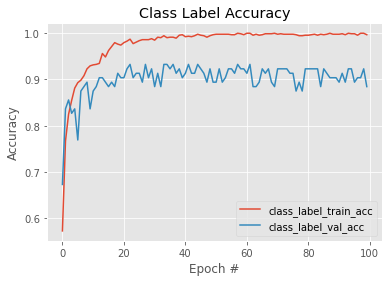

In [27]:
# plotting the class label accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom14_training_label_accuracy');

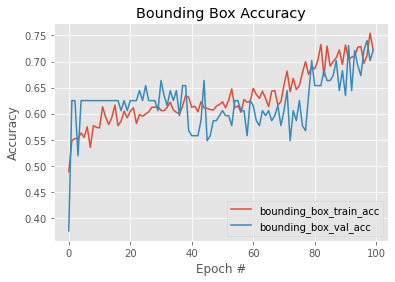

In [28]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 100) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom14_training_bounding_box_accuracy');

### Modeling - Custom15

In [ ]:
# increaseing the number of epochs to 200

In [29]:
# creating custom model15
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)

# constructing an output layer to predict bounding box coordinates
bbox_head1 = Dense(512, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(512, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(512, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head7 = Dense(512, activation="relu")(bbox_head6)
bbox_head8 = Dropout(0.2)(bbox_head7)
bbox_head9 = Dense(512, activation="relu")(bbox_head8)
bbox_head10 = Dropout(0.2)(bbox_head9)
bbox_head11 = Dense(512, activation="relu")(bbox_head10)
bbox_head12 = Dropout(0.2)(bbox_head11)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head12)

# constructing an output layer to predict class labels
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head = Dense(2, activation="sigmoid", name="class_label")(class_head4)

# creating a model that accepts an input image and outputs bounding box coordinates and a class label
model_custom15 = Model(inputs=input_layer, outputs=(bbox_head, class_head))

# creating dictionary for setting loss functions
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}

# creating dictionry for weighting loss functions
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

# initilizing an "Adam" optimizer with learning rate of 0.0001
opt = Adam(learning_rate = 0.0001)

# compiling the model
model_custom15.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)
print(model_custom15.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 222, 222, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 111, 111, 32) 0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 109, 109, 64) 18496       max_pooling2d_3[0][0]            
_______________________________________________________________________________________

In [31]:
# constructing a dictionary for our training outputs
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}

# constructing a dictionary for our test outputs
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}

# training model for class and bounding box predictions
model = model_custom15.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=32, epochs=200, verbose=1)

Epoch 1/200
30/30 [==============================] - 32s 1s/step - loss: 0.7390 - bounding_box_loss: 0.0415 - class_label_loss: 0.6975 - bounding_box_accuracy: 0.5427 - class_label_accuracy: 0.5417 - val_loss: 0.6837 - val_bounding_box_loss: 0.0422 - val_class_label_loss: 0.6415 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8269
Epoch 2/200
30/30 [==============================] - 34s 1s/step - loss: 0.5784 - bounding_box_loss: 0.0198 - class_label_loss: 0.5585 - bounding_box_accuracy: 0.5556 - class_label_accuracy: 0.7959 - val_loss: 0.5356 - val_bounding_box_loss: 0.0235 - val_class_label_loss: 0.5121 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7308
Epoch 3/200
30/30 [==============================] - 35s 1s/step - loss: 0.4457 - bounding_box_loss: 0.0176 - class_label_loss: 0.4281 - bounding_box_accuracy: 0.5449 - class_label_accuracy: 0.8355 - val_loss: 0.4670 - val_bounding_box_loss: 0.0334 - val_class_label_loss: 0.4336 - val_bounding_box

30/30 [==============================] - 36s 1s/step - loss: 0.0719 - bounding_box_loss: 0.0103 - class_label_loss: 0.0616 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9797 - val_loss: 0.4340 - val_bounding_box_loss: 0.0365 - val_class_label_loss: 0.3975 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
Epoch 25/200
30/30 [==============================] - 36s 1s/step - loss: 0.0643 - bounding_box_loss: 0.0105 - class_label_loss: 0.0538 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9818 - val_loss: 0.4940 - val_bounding_box_loss: 0.0480 - val_class_label_loss: 0.4460 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9038
Epoch 26/200
30/30 [==============================] - 36s 1s/step - loss: 0.0544 - bounding_box_loss: 0.0108 - class_label_loss: 0.0436 - bounding_box_accuracy: 0.5791 - class_label_accuracy: 0.9850 - val_loss: 0.4638 - val_bounding_box_loss: 0.0384 - val_class_label_loss: 0.4255 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0285 - bounding_box_loss: 0.0086 - class_label_loss: 0.0199 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.9936 - val_loss: 0.5631 - val_bounding_box_loss: 0.0341 - val_class_label_loss: 0.5290 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
Epoch 48/200
30/30 [==============================] - 36s 1s/step - loss: 0.0174 - bounding_box_loss: 0.0084 - class_label_loss: 0.0091 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 0.9989 - val_loss: 0.6389 - val_bounding_box_loss: 0.0361 - val_class_label_loss: 0.6028 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
Epoch 49/200
30/30 [==============================] - 36s 1s/step - loss: 0.0220 - bounding_box_loss: 0.0084 - class_label_loss: 0.0136 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9947 - val_loss: 0.8019 - val_bounding_box_loss: 0.0371 - val_class_label_loss: 0.7648 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0105 - bounding_box_loss: 0.0073 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.6357 - class_label_accuracy: 1.0000 - val_loss: 0.6634 - val_bounding_box_loss: 0.0292 - val_class_label_loss: 0.6342 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9231
Epoch 71/200
30/30 [==============================] - 36s 1s/step - loss: 0.0225 - bounding_box_loss: 0.0075 - class_label_loss: 0.0150 - bounding_box_accuracy: 0.6667 - class_label_accuracy: 0.9957 - val_loss: 0.5301 - val_bounding_box_loss: 0.0362 - val_class_label_loss: 0.4939 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
Epoch 72/200
30/30 [==============================] - 36s 1s/step - loss: 0.0183 - bounding_box_loss: 0.0075 - class_label_loss: 0.0107 - bounding_box_accuracy: 0.6806 - class_label_accuracy: 0.9968 - val_loss: 0.7064 - val_bounding_box_loss: 0.0249 - val_class_label_loss: 0.6815 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0062 - class_label_loss: 0.0038 - bounding_box_accuracy: 0.7051 - class_label_accuracy: 0.9979 - val_loss: 0.7409 - val_bounding_box_loss: 0.0301 - val_class_label_loss: 0.7108 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9135
Epoch 94/200
30/30 [==============================] - 36s 1s/step - loss: 0.0087 - bounding_box_loss: 0.0064 - class_label_loss: 0.0024 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 1.0000 - val_loss: 0.7019 - val_bounding_box_loss: 0.0327 - val_class_label_loss: 0.6692 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
Epoch 95/200
30/30 [==============================] - 36s 1s/step - loss: 0.0113 - bounding_box_loss: 0.0065 - class_label_loss: 0.0047 - bounding_box_accuracy: 0.6944 - class_label_accuracy: 0.9968 - val_loss: 0.8649 - val_bounding_box_loss: 0.0299 - val_class_label_loss: 0.8350 - val_bounding_box_accuracy:

30/30 [==============================] - 36s 1s/step - loss: 0.0166 - bounding_box_loss: 0.0055 - class_label_loss: 0.0112 - bounding_box_accuracy: 0.7650 - class_label_accuracy: 0.9957 - val_loss: 0.8901 - val_bounding_box_loss: 0.0271 - val_class_label_loss: 0.8630 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9135
Epoch 117/200
30/30 [==============================] - 36s 1s/step - loss: 0.0092 - bounding_box_loss: 0.0054 - class_label_loss: 0.0038 - bounding_box_accuracy: 0.7671 - class_label_accuracy: 1.0000 - val_loss: 0.7757 - val_bounding_box_loss: 0.0229 - val_class_label_loss: 0.7528 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
Epoch 118/200
30/30 [==============================] - 36s 1s/step - loss: 0.0067 - bounding_box_loss: 0.0053 - class_label_loss: 0.0013 - bounding_box_accuracy: 0.7201 - class_label_accuracy: 1.0000 - val_loss: 0.8664 - val_bounding_box_loss: 0.0258 - val_class_label_loss: 0.8407 - val_bounding_box_accurac

30/30 [==============================] - 36s 1s/step - loss: 0.0056 - bounding_box_loss: 0.0049 - class_label_loss: 7.3544e-04 - bounding_box_accuracy: 0.7810 - class_label_accuracy: 1.0000 - val_loss: 0.7886 - val_bounding_box_loss: 0.0246 - val_class_label_loss: 0.7640 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
Epoch 140/200
30/30 [==============================] - 36s 1s/step - loss: 0.0056 - bounding_box_loss: 0.0046 - class_label_loss: 9.1338e-04 - bounding_box_accuracy: 0.7575 - class_label_accuracy: 1.0000 - val_loss: 0.8448 - val_bounding_box_loss: 0.0250 - val_class_label_loss: 0.8198 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
Epoch 141/200
30/30 [==============================] - 36s 1s/step - loss: 0.0054 - bounding_box_loss: 0.0047 - class_label_loss: 6.2642e-04 - bounding_box_accuracy: 0.7863 - class_label_accuracy: 1.0000 - val_loss: 0.8181 - val_bounding_box_loss: 0.0272 - val_class_label_loss: 0.7910 - val_bounding

30/30 [==============================] - 36s 1s/step - loss: 0.0070 - bounding_box_loss: 0.0045 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.7949 - class_label_accuracy: 0.9989 - val_loss: 0.7589 - val_bounding_box_loss: 0.0247 - val_class_label_loss: 0.7342 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
Epoch 163/200
30/30 [==============================] - 35s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0041 - class_label_loss: 6.7480e-04 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 1.0000 - val_loss: 0.7854 - val_bounding_box_loss: 0.0238 - val_class_label_loss: 0.7616 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
Epoch 164/200
30/30 [==============================] - 35s 1s/step - loss: 0.0057 - bounding_box_loss: 0.0044 - class_label_loss: 0.0013 - bounding_box_accuracy: 0.7991 - class_label_accuracy: 1.0000 - val_loss: 0.7171 - val_bounding_box_loss: 0.0233 - val_class_label_loss: 0.6938 - val_bounding_box_acc

30/30 [==============================] - 37s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0040 - class_label_loss: 8.5090e-04 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 1.0000 - val_loss: 0.7730 - val_bounding_box_loss: 0.0238 - val_class_label_loss: 0.7493 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
Epoch 186/200
30/30 [==============================] - 36s 1s/step - loss: 0.0075 - bounding_box_loss: 0.0042 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.8184 - class_label_accuracy: 0.9989 - val_loss: 0.7605 - val_bounding_box_loss: 0.0221 - val_class_label_loss: 0.7384 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9038
Epoch 187/200
30/30 [==============================] - 35s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0037 - class_label_loss: 0.0023 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 0.9989 - val_loss: 0.7625 - val_bounding_box_loss: 0.0253 - val_class_label_loss: 0.7373 - val_bounding_box_acc

In [32]:
# Epoch 1/200
# 30/30 [==============================] - 32s 1s/step - loss: 0.7390 - bounding_box_loss: 0.0415 - class_label_loss: 0.6975 - bounding_box_accuracy: 0.5427 - class_label_accuracy: 0.5417 - val_loss: 0.6837 - val_bounding_box_loss: 0.0422 - val_class_label_loss: 0.6415 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8269
# Epoch 2/200
# 30/30 [==============================] - 34s 1s/step - loss: 0.5784 - bounding_box_loss: 0.0198 - class_label_loss: 0.5585 - bounding_box_accuracy: 0.5556 - class_label_accuracy: 0.7959 - val_loss: 0.5356 - val_bounding_box_loss: 0.0235 - val_class_label_loss: 0.5121 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7308
# Epoch 3/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.4457 - bounding_box_loss: 0.0176 - class_label_loss: 0.4281 - bounding_box_accuracy: 0.5449 - class_label_accuracy: 0.8355 - val_loss: 0.4670 - val_bounding_box_loss: 0.0334 - val_class_label_loss: 0.4336 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.7981
# Epoch 4/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.4172 - bounding_box_loss: 0.0162 - class_label_loss: 0.4010 - bounding_box_accuracy: 0.5491 - class_label_accuracy: 0.8600 - val_loss: 0.4080 - val_bounding_box_loss: 0.0326 - val_class_label_loss: 0.3753 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8750
# Epoch 5/200
# 30/30 [==============================] - 34s 1s/step - loss: 0.3715 - bounding_box_loss: 0.0153 - class_label_loss: 0.3562 - bounding_box_accuracy: 0.5524 - class_label_accuracy: 0.8782 - val_loss: 0.4024 - val_bounding_box_loss: 0.0278 - val_class_label_loss: 0.3746 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 6/200
# 30/30 [==============================] - 34s 1s/step - loss: 0.3356 - bounding_box_loss: 0.0148 - class_label_loss: 0.3209 - bounding_box_accuracy: 0.5684 - class_label_accuracy: 0.8953 - val_loss: 0.4241 - val_bounding_box_loss: 0.0359 - val_class_label_loss: 0.3882 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 7/200
# 30/30 [==============================] - 34s 1s/step - loss: 0.3093 - bounding_box_loss: 0.0143 - class_label_loss: 0.2950 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.9006 - val_loss: 0.3963 - val_bounding_box_loss: 0.0231 - val_class_label_loss: 0.3733 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8365
# Epoch 8/200
# 30/30 [==============================] - 34s 1s/step - loss: 0.2945 - bounding_box_loss: 0.0141 - class_label_loss: 0.2804 - bounding_box_accuracy: 0.5694 - class_label_accuracy: 0.9092 - val_loss: 0.3452 - val_bounding_box_loss: 0.0287 - val_class_label_loss: 0.3165 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8846
# Epoch 9/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.2603 - bounding_box_loss: 0.0138 - class_label_loss: 0.2465 - bounding_box_accuracy: 0.5652 - class_label_accuracy: 0.9209 - val_loss: 0.3127 - val_bounding_box_loss: 0.0347 - val_class_label_loss: 0.2780 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 10/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.2290 - bounding_box_loss: 0.0139 - class_label_loss: 0.2151 - bounding_box_accuracy: 0.5855 - class_label_accuracy: 0.9359 - val_loss: 0.2964 - val_bounding_box_loss: 0.0266 - val_class_label_loss: 0.2697 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 11/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.1962 - bounding_box_loss: 0.0129 - class_label_loss: 0.1833 - bounding_box_accuracy: 0.5609 - class_label_accuracy: 0.9455 - val_loss: 0.3183 - val_bounding_box_loss: 0.0375 - val_class_label_loss: 0.2808 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 12/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.1623 - bounding_box_loss: 0.0121 - class_label_loss: 0.1502 - bounding_box_accuracy: 0.5855 - class_label_accuracy: 0.9551 - val_loss: 0.3270 - val_bounding_box_loss: 0.0321 - val_class_label_loss: 0.2949 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 13/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.1838 - bounding_box_loss: 0.0124 - class_label_loss: 0.1714 - bounding_box_accuracy: 0.5459 - class_label_accuracy: 0.9466 - val_loss: 0.4094 - val_bounding_box_loss: 0.0337 - val_class_label_loss: 0.3757 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8846
# Epoch 14/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.1448 - bounding_box_loss: 0.0118 - class_label_loss: 0.1330 - bounding_box_accuracy: 0.5876 - class_label_accuracy: 0.9594 - val_loss: 0.3835 - val_bounding_box_loss: 0.0342 - val_class_label_loss: 0.3492 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 15/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.1318 - bounding_box_loss: 0.0117 - class_label_loss: 0.1201 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9637 - val_loss: 0.3051 - val_bounding_box_loss: 0.0347 - val_class_label_loss: 0.2704 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 16/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.1133 - bounding_box_loss: 0.0116 - class_label_loss: 0.1017 - bounding_box_accuracy: 0.5951 - class_label_accuracy: 0.9722 - val_loss: 0.3098 - val_bounding_box_loss: 0.0302 - val_class_label_loss: 0.2796 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 17/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0958 - bounding_box_loss: 0.0120 - class_label_loss: 0.0838 - bounding_box_accuracy: 0.5673 - class_label_accuracy: 0.9786 - val_loss: 0.3530 - val_bounding_box_loss: 0.0383 - val_class_label_loss: 0.3147 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9038
# Epoch 18/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.1291 - bounding_box_loss: 0.0114 - class_label_loss: 0.1177 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9615 - val_loss: 0.3909 - val_bounding_box_loss: 0.0374 - val_class_label_loss: 0.3536 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 19/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0943 - bounding_box_loss: 0.0109 - class_label_loss: 0.0834 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9765 - val_loss: 0.4384 - val_bounding_box_loss: 0.0334 - val_class_label_loss: 0.4050 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9327
# Epoch 20/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.1371 - bounding_box_loss: 0.0117 - class_label_loss: 0.1254 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9551 - val_loss: 0.3044 - val_bounding_box_loss: 0.0390 - val_class_label_loss: 0.2655 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 21/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0757 - bounding_box_loss: 0.0105 - class_label_loss: 0.0651 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9818 - val_loss: 0.3281 - val_bounding_box_loss: 0.0363 - val_class_label_loss: 0.2918 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 22/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0764 - bounding_box_loss: 0.0106 - class_label_loss: 0.0658 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9829 - val_loss: 0.3481 - val_bounding_box_loss: 0.0339 - val_class_label_loss: 0.3142 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8750
# Epoch 23/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0649 - bounding_box_loss: 0.0104 - class_label_loss: 0.0545 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9786 - val_loss: 0.3753 - val_bounding_box_loss: 0.0371 - val_class_label_loss: 0.3382 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 24/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0719 - bounding_box_loss: 0.0103 - class_label_loss: 0.0616 - bounding_box_accuracy: 0.5972 - class_label_accuracy: 0.9797 - val_loss: 0.4340 - val_bounding_box_loss: 0.0365 - val_class_label_loss: 0.3975 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9231
# Epoch 25/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0643 - bounding_box_loss: 0.0105 - class_label_loss: 0.0538 - bounding_box_accuracy: 0.5994 - class_label_accuracy: 0.9818 - val_loss: 0.4940 - val_bounding_box_loss: 0.0480 - val_class_label_loss: 0.4460 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9038
# Epoch 26/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0544 - bounding_box_loss: 0.0108 - class_label_loss: 0.0436 - bounding_box_accuracy: 0.5791 - class_label_accuracy: 0.9850 - val_loss: 0.4638 - val_bounding_box_loss: 0.0384 - val_class_label_loss: 0.4255 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 27/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0530 - bounding_box_loss: 0.0106 - class_label_loss: 0.0424 - bounding_box_accuracy: 0.6218 - class_label_accuracy: 0.9840 - val_loss: 0.4630 - val_bounding_box_loss: 0.0336 - val_class_label_loss: 0.4294 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9038
# Epoch 28/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0546 - bounding_box_loss: 0.0109 - class_label_loss: 0.0437 - bounding_box_accuracy: 0.6132 - class_label_accuracy: 0.9850 - val_loss: 0.4497 - val_bounding_box_loss: 0.0321 - val_class_label_loss: 0.4176 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 29/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0440 - bounding_box_loss: 0.0101 - class_label_loss: 0.0339 - bounding_box_accuracy: 0.5940 - class_label_accuracy: 0.9882 - val_loss: 0.5166 - val_bounding_box_loss: 0.0392 - val_class_label_loss: 0.4774 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9135
# Epoch 30/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0360 - bounding_box_loss: 0.0099 - class_label_loss: 0.0261 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9893 - val_loss: 0.5445 - val_bounding_box_loss: 0.0442 - val_class_label_loss: 0.5003 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9135
# Epoch 31/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0439 - bounding_box_loss: 0.0103 - class_label_loss: 0.0337 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9904 - val_loss: 0.5704 - val_bounding_box_loss: 0.0364 - val_class_label_loss: 0.5340 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 32/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0558 - bounding_box_loss: 0.0113 - class_label_loss: 0.0445 - bounding_box_accuracy: 0.6047 - class_label_accuracy: 0.9850 - val_loss: 0.5309 - val_bounding_box_loss: 0.0444 - val_class_label_loss: 0.4865 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9231
# Epoch 33/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0323 - bounding_box_loss: 0.0097 - class_label_loss: 0.0227 - bounding_box_accuracy: 0.6036 - class_label_accuracy: 0.9947 - val_loss: 0.5342 - val_bounding_box_loss: 0.0443 - val_class_label_loss: 0.4899 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 34/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0363 - bounding_box_loss: 0.0096 - class_label_loss: 0.0266 - bounding_box_accuracy: 0.6068 - class_label_accuracy: 0.9882 - val_loss: 0.4639 - val_bounding_box_loss: 0.0407 - val_class_label_loss: 0.4231 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 35/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0374 - bounding_box_loss: 0.0094 - class_label_loss: 0.0280 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.9893 - val_loss: 0.4773 - val_bounding_box_loss: 0.0384 - val_class_label_loss: 0.4388 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9231
# Epoch 36/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0275 - bounding_box_loss: 0.0094 - class_label_loss: 0.0181 - bounding_box_accuracy: 0.5908 - class_label_accuracy: 0.9957 - val_loss: 0.6452 - val_bounding_box_loss: 0.0345 - val_class_label_loss: 0.6107 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 37/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0352 - bounding_box_loss: 0.0096 - class_label_loss: 0.0256 - bounding_box_accuracy: 0.6004 - class_label_accuracy: 0.9936 - val_loss: 0.5590 - val_bounding_box_loss: 0.0406 - val_class_label_loss: 0.5184 - val_bounding_box_accuracy: 0.5096 - val_class_label_accuracy: 0.9231
# Epoch 38/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0272 - bounding_box_loss: 0.0094 - class_label_loss: 0.0178 - bounding_box_accuracy: 0.5940 - class_label_accuracy: 0.9968 - val_loss: 0.5329 - val_bounding_box_loss: 0.0389 - val_class_label_loss: 0.4941 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9135
# Epoch 39/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0274 - bounding_box_loss: 0.0090 - class_label_loss: 0.0184 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9936 - val_loss: 0.5075 - val_bounding_box_loss: 0.0363 - val_class_label_loss: 0.4712 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.8942
# Epoch 40/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0243 - bounding_box_loss: 0.0091 - class_label_loss: 0.0152 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.9936 - val_loss: 0.5820 - val_bounding_box_loss: 0.0395 - val_class_label_loss: 0.5426 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9135
# Epoch 41/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0311 - bounding_box_loss: 0.0091 - class_label_loss: 0.0220 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 0.9947 - val_loss: 0.5573 - val_bounding_box_loss: 0.0374 - val_class_label_loss: 0.5199 - val_bounding_box_accuracy: 0.5481 - val_class_label_accuracy: 0.9135
# Epoch 42/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0289 - bounding_box_loss: 0.0090 - class_label_loss: 0.0199 - bounding_box_accuracy: 0.6186 - class_label_accuracy: 0.9936 - val_loss: 0.5559 - val_bounding_box_loss: 0.0373 - val_class_label_loss: 0.5186 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9231
# Epoch 43/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0307 - bounding_box_loss: 0.0091 - class_label_loss: 0.0216 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9904 - val_loss: 0.4939 - val_bounding_box_loss: 0.0295 - val_class_label_loss: 0.4644 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.9231
# Epoch 44/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0269 - bounding_box_loss: 0.0090 - class_label_loss: 0.0179 - bounding_box_accuracy: 0.6143 - class_label_accuracy: 0.9936 - val_loss: 0.5420 - val_bounding_box_loss: 0.0343 - val_class_label_loss: 0.5077 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9038
# Epoch 45/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0246 - bounding_box_loss: 0.0090 - class_label_loss: 0.0156 - bounding_box_accuracy: 0.6175 - class_label_accuracy: 0.9957 - val_loss: 0.5456 - val_bounding_box_loss: 0.0348 - val_class_label_loss: 0.5108 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.9231
# Epoch 46/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0247 - bounding_box_loss: 0.0088 - class_label_loss: 0.0159 - bounding_box_accuracy: 0.6015 - class_label_accuracy: 0.9925 - val_loss: 0.7065 - val_bounding_box_loss: 0.0362 - val_class_label_loss: 0.6703 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
# Epoch 47/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0285 - bounding_box_loss: 0.0086 - class_label_loss: 0.0199 - bounding_box_accuracy: 0.6207 - class_label_accuracy: 0.9936 - val_loss: 0.5631 - val_bounding_box_loss: 0.0341 - val_class_label_loss: 0.5290 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 48/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0174 - bounding_box_loss: 0.0084 - class_label_loss: 0.0091 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 0.9989 - val_loss: 0.6389 - val_bounding_box_loss: 0.0361 - val_class_label_loss: 0.6028 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
# Epoch 49/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0220 - bounding_box_loss: 0.0084 - class_label_loss: 0.0136 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9947 - val_loss: 0.8019 - val_bounding_box_loss: 0.0371 - val_class_label_loss: 0.7648 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8846
# Epoch 50/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0306 - bounding_box_loss: 0.0090 - class_label_loss: 0.0215 - bounding_box_accuracy: 0.6026 - class_label_accuracy: 0.9882 - val_loss: 0.5906 - val_bounding_box_loss: 0.0351 - val_class_label_loss: 0.5555 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.9135
# Epoch 51/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0250 - bounding_box_loss: 0.0082 - class_label_loss: 0.0168 - bounding_box_accuracy: 0.6261 - class_label_accuracy: 0.9957 - val_loss: 0.4837 - val_bounding_box_loss: 0.0361 - val_class_label_loss: 0.4476 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.8942
# Epoch 52/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0211 - bounding_box_loss: 0.0082 - class_label_loss: 0.0128 - bounding_box_accuracy: 0.6090 - class_label_accuracy: 0.9957 - val_loss: 0.6501 - val_bounding_box_loss: 0.0303 - val_class_label_loss: 0.6198 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
# Epoch 53/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0155 - bounding_box_loss: 0.0083 - class_label_loss: 0.0072 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9989 - val_loss: 0.6912 - val_bounding_box_loss: 0.0331 - val_class_label_loss: 0.6581 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
# Epoch 54/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0231 - bounding_box_loss: 0.0082 - class_label_loss: 0.0149 - bounding_box_accuracy: 0.6111 - class_label_accuracy: 0.9936 - val_loss: 0.5397 - val_bounding_box_loss: 0.0339 - val_class_label_loss: 0.5058 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.8942
# Epoch 55/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0269 - bounding_box_loss: 0.0081 - class_label_loss: 0.0188 - bounding_box_accuracy: 0.6400 - class_label_accuracy: 0.9915 - val_loss: 0.6417 - val_bounding_box_loss: 0.0336 - val_class_label_loss: 0.6081 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 56/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0229 - bounding_box_loss: 0.0081 - class_label_loss: 0.0148 - bounding_box_accuracy: 0.6271 - class_label_accuracy: 0.9947 - val_loss: 0.4899 - val_bounding_box_loss: 0.0353 - val_class_label_loss: 0.4545 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 57/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0197 - bounding_box_loss: 0.0080 - class_label_loss: 0.0118 - bounding_box_accuracy: 0.6293 - class_label_accuracy: 0.9957 - val_loss: 0.5781 - val_bounding_box_loss: 0.0358 - val_class_label_loss: 0.5423 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9327
# Epoch 58/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0153 - bounding_box_loss: 0.0080 - class_label_loss: 0.0072 - bounding_box_accuracy: 0.6154 - class_label_accuracy: 0.9979 - val_loss: 0.6561 - val_bounding_box_loss: 0.0323 - val_class_label_loss: 0.6238 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 59/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0189 - bounding_box_loss: 0.0080 - class_label_loss: 0.0109 - bounding_box_accuracy: 0.6229 - class_label_accuracy: 0.9968 - val_loss: 0.5800 - val_bounding_box_loss: 0.0343 - val_class_label_loss: 0.5457 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9231
# Epoch 60/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0079 - class_label_loss: 0.0062 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.9979 - val_loss: 0.7096 - val_bounding_box_loss: 0.0356 - val_class_label_loss: 0.6741 - val_bounding_box_accuracy: 0.6058 - val_class_label_accuracy: 0.9231
# Epoch 61/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0152 - bounding_box_loss: 0.0079 - class_label_loss: 0.0073 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 1.0000 - val_loss: 0.5699 - val_bounding_box_loss: 0.0313 - val_class_label_loss: 0.5386 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 62/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0143 - bounding_box_loss: 0.0079 - class_label_loss: 0.0064 - bounding_box_accuracy: 0.6357 - class_label_accuracy: 0.9979 - val_loss: 0.6651 - val_bounding_box_loss: 0.0338 - val_class_label_loss: 0.6313 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9231
# Epoch 63/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0127 - bounding_box_loss: 0.0078 - class_label_loss: 0.0049 - bounding_box_accuracy: 0.6357 - class_label_accuracy: 0.9989 - val_loss: 0.6525 - val_bounding_box_loss: 0.0345 - val_class_label_loss: 0.6180 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.8942
# Epoch 64/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0250 - bounding_box_loss: 0.0078 - class_label_loss: 0.0172 - bounding_box_accuracy: 0.6282 - class_label_accuracy: 0.9957 - val_loss: 0.6711 - val_bounding_box_loss: 0.0287 - val_class_label_loss: 0.6424 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9135
# Epoch 65/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0154 - bounding_box_loss: 0.0075 - class_label_loss: 0.0079 - bounding_box_accuracy: 0.6122 - class_label_accuracy: 0.9968 - val_loss: 0.5174 - val_bounding_box_loss: 0.0323 - val_class_label_loss: 0.4851 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.9231
# Epoch 66/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0256 - bounding_box_loss: 0.0078 - class_label_loss: 0.0178 - bounding_box_accuracy: 0.6464 - class_label_accuracy: 0.9925 - val_loss: 0.9339 - val_bounding_box_loss: 0.0333 - val_class_label_loss: 0.9006 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8654
# Epoch 67/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0196 - bounding_box_loss: 0.0080 - class_label_loss: 0.0116 - bounding_box_accuracy: 0.6560 - class_label_accuracy: 0.9989 - val_loss: 0.6339 - val_bounding_box_loss: 0.0307 - val_class_label_loss: 0.6032 - val_bounding_box_accuracy: 0.5962 - val_class_label_accuracy: 0.9231
# Epoch 68/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0129 - bounding_box_loss: 0.0074 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.9979 - val_loss: 0.6081 - val_bounding_box_loss: 0.0325 - val_class_label_loss: 0.5756 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9135
# Epoch 69/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0159 - bounding_box_loss: 0.0072 - class_label_loss: 0.0087 - bounding_box_accuracy: 0.6517 - class_label_accuracy: 0.9979 - val_loss: 0.5848 - val_bounding_box_loss: 0.0340 - val_class_label_loss: 0.5509 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9135
# Epoch 70/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0105 - bounding_box_loss: 0.0073 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.6357 - class_label_accuracy: 1.0000 - val_loss: 0.6634 - val_bounding_box_loss: 0.0292 - val_class_label_loss: 0.6342 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9231
# Epoch 71/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0225 - bounding_box_loss: 0.0075 - class_label_loss: 0.0150 - bounding_box_accuracy: 0.6667 - class_label_accuracy: 0.9957 - val_loss: 0.5301 - val_bounding_box_loss: 0.0362 - val_class_label_loss: 0.4939 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
# Epoch 72/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0183 - bounding_box_loss: 0.0075 - class_label_loss: 0.0107 - bounding_box_accuracy: 0.6806 - class_label_accuracy: 0.9968 - val_loss: 0.7064 - val_bounding_box_loss: 0.0249 - val_class_label_loss: 0.6815 - val_bounding_box_accuracy: 0.5577 - val_class_label_accuracy: 0.9231
# Epoch 73/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0160 - bounding_box_loss: 0.0073 - class_label_loss: 0.0087 - bounding_box_accuracy: 0.6506 - class_label_accuracy: 0.9968 - val_loss: 0.5844 - val_bounding_box_loss: 0.0339 - val_class_label_loss: 0.5506 - val_bounding_box_accuracy: 0.6250 - val_class_label_accuracy: 0.8942
# Epoch 74/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0137 - bounding_box_loss: 0.0071 - class_label_loss: 0.0066 - bounding_box_accuracy: 0.6752 - class_label_accuracy: 0.9979 - val_loss: 0.6574 - val_bounding_box_loss: 0.0307 - val_class_label_loss: 0.6267 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9327
# Epoch 75/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0199 - bounding_box_loss: 0.0072 - class_label_loss: 0.0127 - bounding_box_accuracy: 0.6699 - class_label_accuracy: 0.9957 - val_loss: 0.7686 - val_bounding_box_loss: 0.0283 - val_class_label_loss: 0.7403 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9135
# Epoch 76/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0173 - bounding_box_loss: 0.0072 - class_label_loss: 0.0101 - bounding_box_accuracy: 0.6688 - class_label_accuracy: 0.9968 - val_loss: 0.5880 - val_bounding_box_loss: 0.0263 - val_class_label_loss: 0.5618 - val_bounding_box_accuracy: 0.5673 - val_class_label_accuracy: 0.9135
# Epoch 77/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0129 - bounding_box_loss: 0.0072 - class_label_loss: 0.0057 - bounding_box_accuracy: 0.6944 - class_label_accuracy: 0.9979 - val_loss: 0.6626 - val_bounding_box_loss: 0.0305 - val_class_label_loss: 0.6321 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 78/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0124 - bounding_box_loss: 0.0068 - class_label_loss: 0.0057 - bounding_box_accuracy: 0.6656 - class_label_accuracy: 0.9979 - val_loss: 0.7349 - val_bounding_box_loss: 0.0310 - val_class_label_loss: 0.7040 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 79/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0141 - bounding_box_loss: 0.0069 - class_label_loss: 0.0072 - bounding_box_accuracy: 0.6741 - class_label_accuracy: 0.9979 - val_loss: 0.5834 - val_bounding_box_loss: 0.0321 - val_class_label_loss: 0.5513 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 80/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0118 - bounding_box_loss: 0.0070 - class_label_loss: 0.0048 - bounding_box_accuracy: 0.6517 - class_label_accuracy: 0.9989 - val_loss: 0.6563 - val_bounding_box_loss: 0.0318 - val_class_label_loss: 0.6244 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 81/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0134 - bounding_box_loss: 0.0070 - class_label_loss: 0.0064 - bounding_box_accuracy: 0.6944 - class_label_accuracy: 0.9968 - val_loss: 0.6001 - val_bounding_box_loss: 0.0329 - val_class_label_loss: 0.5672 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9038
# Epoch 82/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0124 - bounding_box_loss: 0.0071 - class_label_loss: 0.0053 - bounding_box_accuracy: 0.6645 - class_label_accuracy: 0.9968 - val_loss: 0.6654 - val_bounding_box_loss: 0.0294 - val_class_label_loss: 0.6360 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9231
# Epoch 83/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0138 - bounding_box_loss: 0.0067 - class_label_loss: 0.0071 - bounding_box_accuracy: 0.6827 - class_label_accuracy: 0.9968 - val_loss: 0.5409 - val_bounding_box_loss: 0.0315 - val_class_label_loss: 0.5093 - val_bounding_box_accuracy: 0.5865 - val_class_label_accuracy: 0.9231
# Epoch 84/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0137 - bounding_box_loss: 0.0068 - class_label_loss: 0.0069 - bounding_box_accuracy: 0.6816 - class_label_accuracy: 0.9989 - val_loss: 0.5901 - val_bounding_box_loss: 0.0322 - val_class_label_loss: 0.5579 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8846
# Epoch 85/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0095 - bounding_box_loss: 0.0068 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.6880 - class_label_accuracy: 0.9989 - val_loss: 0.7730 - val_bounding_box_loss: 0.0290 - val_class_label_loss: 0.7440 - val_bounding_box_accuracy: 0.5769 - val_class_label_accuracy: 0.9231
# Epoch 86/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0089 - bounding_box_loss: 0.0067 - class_label_loss: 0.0022 - bounding_box_accuracy: 0.6624 - class_label_accuracy: 1.0000 - val_loss: 0.7725 - val_bounding_box_loss: 0.0297 - val_class_label_loss: 0.7428 - val_bounding_box_accuracy: 0.6154 - val_class_label_accuracy: 0.9135
# Epoch 87/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0117 - bounding_box_loss: 0.0066 - class_label_loss: 0.0051 - bounding_box_accuracy: 0.6912 - class_label_accuracy: 0.9957 - val_loss: 0.6785 - val_bounding_box_loss: 0.0349 - val_class_label_loss: 0.6436 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9135
# Epoch 88/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0214 - bounding_box_loss: 0.0070 - class_label_loss: 0.0144 - bounding_box_accuracy: 0.7062 - class_label_accuracy: 0.9968 - val_loss: 0.9744 - val_bounding_box_loss: 0.0381 - val_class_label_loss: 0.9363 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8654
# Epoch 89/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0167 - bounding_box_loss: 0.0079 - class_label_loss: 0.0088 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9989 - val_loss: 0.7837 - val_bounding_box_loss: 0.0291 - val_class_label_loss: 0.7546 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 90/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0121 - bounding_box_loss: 0.0066 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.7073 - class_label_accuracy: 0.9968 - val_loss: 0.7549 - val_bounding_box_loss: 0.0291 - val_class_label_loss: 0.7258 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.9231
# Epoch 91/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0114 - bounding_box_loss: 0.0064 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.7083 - class_label_accuracy: 0.9989 - val_loss: 0.8245 - val_bounding_box_loss: 0.0303 - val_class_label_loss: 0.7942 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9231
# Epoch 92/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0119 - bounding_box_loss: 0.0065 - class_label_loss: 0.0054 - bounding_box_accuracy: 0.7030 - class_label_accuracy: 0.9979 - val_loss: 0.7204 - val_bounding_box_loss: 0.0296 - val_class_label_loss: 0.6908 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.9135
# Epoch 93/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0100 - bounding_box_loss: 0.0062 - class_label_loss: 0.0038 - bounding_box_accuracy: 0.7051 - class_label_accuracy: 0.9979 - val_loss: 0.7409 - val_bounding_box_loss: 0.0301 - val_class_label_loss: 0.7108 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9135
# Epoch 94/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0087 - bounding_box_loss: 0.0064 - class_label_loss: 0.0024 - bounding_box_accuracy: 0.7286 - class_label_accuracy: 1.0000 - val_loss: 0.7019 - val_bounding_box_loss: 0.0327 - val_class_label_loss: 0.6692 - val_bounding_box_accuracy: 0.6346 - val_class_label_accuracy: 0.8942
# Epoch 95/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0113 - bounding_box_loss: 0.0065 - class_label_loss: 0.0047 - bounding_box_accuracy: 0.6944 - class_label_accuracy: 0.9968 - val_loss: 0.8649 - val_bounding_box_loss: 0.0299 - val_class_label_loss: 0.8350 - val_bounding_box_accuracy: 0.6538 - val_class_label_accuracy: 0.8846
# Epoch 96/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0116 - bounding_box_loss: 0.0064 - class_label_loss: 0.0052 - bounding_box_accuracy: 0.7051 - class_label_accuracy: 0.9989 - val_loss: 0.5993 - val_bounding_box_loss: 0.0270 - val_class_label_loss: 0.5723 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 97/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0116 - bounding_box_loss: 0.0062 - class_label_loss: 0.0054 - bounding_box_accuracy: 0.7105 - class_label_accuracy: 0.9979 - val_loss: 0.7409 - val_bounding_box_loss: 0.0287 - val_class_label_loss: 0.7123 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9135
# Epoch 98/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0078 - bounding_box_loss: 0.0059 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.7212 - class_label_accuracy: 1.0000 - val_loss: 0.7997 - val_bounding_box_loss: 0.0297 - val_class_label_loss: 0.7700 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 99/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0091 - bounding_box_loss: 0.0062 - class_label_loss: 0.0028 - bounding_box_accuracy: 0.7179 - class_label_accuracy: 0.9989 - val_loss: 0.7396 - val_bounding_box_loss: 0.0290 - val_class_label_loss: 0.7106 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.9135
# Epoch 100/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0073 - bounding_box_loss: 0.0059 - class_label_loss: 0.0014 - bounding_box_accuracy: 0.7297 - class_label_accuracy: 1.0000 - val_loss: 0.7431 - val_bounding_box_loss: 0.0257 - val_class_label_loss: 0.7174 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9135
# Epoch 101/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0093 - bounding_box_loss: 0.0060 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.7233 - class_label_accuracy: 0.9979 - val_loss: 0.8999 - val_bounding_box_loss: 0.0303 - val_class_label_loss: 0.8696 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 102/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0079 - bounding_box_loss: 0.0057 - class_label_loss: 0.0023 - bounding_box_accuracy: 0.7201 - class_label_accuracy: 0.9989 - val_loss: 0.7272 - val_bounding_box_loss: 0.0293 - val_class_label_loss: 0.6979 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 103/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0083 - bounding_box_loss: 0.0058 - class_label_loss: 0.0025 - bounding_box_accuracy: 0.7340 - class_label_accuracy: 0.9989 - val_loss: 0.7718 - val_bounding_box_loss: 0.0297 - val_class_label_loss: 0.7420 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 104/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0081 - bounding_box_loss: 0.0059 - class_label_loss: 0.0022 - bounding_box_accuracy: 0.7276 - class_label_accuracy: 1.0000 - val_loss: 0.7453 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.7178 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 105/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0094 - bounding_box_loss: 0.0059 - class_label_loss: 0.0035 - bounding_box_accuracy: 0.7329 - class_label_accuracy: 0.9979 - val_loss: 0.8603 - val_bounding_box_loss: 0.0266 - val_class_label_loss: 0.8337 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 106/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0090 - bounding_box_loss: 0.0058 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.7254 - class_label_accuracy: 0.9979 - val_loss: 0.8240 - val_bounding_box_loss: 0.0251 - val_class_label_loss: 0.7989 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 107/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0086 - bounding_box_loss: 0.0056 - class_label_loss: 0.0030 - bounding_box_accuracy: 0.7436 - class_label_accuracy: 0.9989 - val_loss: 0.8811 - val_bounding_box_loss: 0.0294 - val_class_label_loss: 0.8517 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9231
# Epoch 108/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0242 - bounding_box_loss: 0.0063 - class_label_loss: 0.0179 - bounding_box_accuracy: 0.7585 - class_label_accuracy: 0.9925 - val_loss: 0.9912 - val_bounding_box_loss: 0.0232 - val_class_label_loss: 0.9680 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 109/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0216 - bounding_box_loss: 0.0078 - class_label_loss: 0.0138 - bounding_box_accuracy: 0.7169 - class_label_accuracy: 0.9957 - val_loss: 0.6925 - val_bounding_box_loss: 0.0371 - val_class_label_loss: 0.6554 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9231
# Epoch 110/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0129 - bounding_box_loss: 0.0070 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.7147 - class_label_accuracy: 0.9989 - val_loss: 0.6683 - val_bounding_box_loss: 0.0250 - val_class_label_loss: 0.6433 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 111/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0089 - bounding_box_loss: 0.0057 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.7714 - class_label_accuracy: 0.9989 - val_loss: 0.7730 - val_bounding_box_loss: 0.0276 - val_class_label_loss: 0.7454 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9135
# Epoch 112/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0105 - bounding_box_loss: 0.0056 - class_label_loss: 0.0049 - bounding_box_accuracy: 0.7415 - class_label_accuracy: 0.9979 - val_loss: 0.7506 - val_bounding_box_loss: 0.0267 - val_class_label_loss: 0.7239 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9327
# Epoch 113/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0086 - bounding_box_loss: 0.0057 - class_label_loss: 0.0029 - bounding_box_accuracy: 0.7308 - class_label_accuracy: 0.9989 - val_loss: 0.7156 - val_bounding_box_loss: 0.0274 - val_class_label_loss: 0.6882 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 114/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0110 - bounding_box_loss: 0.0057 - class_label_loss: 0.0052 - bounding_box_accuracy: 0.7425 - class_label_accuracy: 0.9979 - val_loss: 0.6914 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.6639 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 115/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0089 - bounding_box_loss: 0.0055 - class_label_loss: 0.0034 - bounding_box_accuracy: 0.7799 - class_label_accuracy: 0.9989 - val_loss: 0.8024 - val_bounding_box_loss: 0.0286 - val_class_label_loss: 0.7738 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 116/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0166 - bounding_box_loss: 0.0055 - class_label_loss: 0.0112 - bounding_box_accuracy: 0.7650 - class_label_accuracy: 0.9957 - val_loss: 0.8901 - val_bounding_box_loss: 0.0271 - val_class_label_loss: 0.8630 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9135
# Epoch 117/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0092 - bounding_box_loss: 0.0054 - class_label_loss: 0.0038 - bounding_box_accuracy: 0.7671 - class_label_accuracy: 1.0000 - val_loss: 0.7757 - val_bounding_box_loss: 0.0229 - val_class_label_loss: 0.7528 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 118/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0067 - bounding_box_loss: 0.0053 - class_label_loss: 0.0013 - bounding_box_accuracy: 0.7201 - class_label_accuracy: 1.0000 - val_loss: 0.8664 - val_bounding_box_loss: 0.0258 - val_class_label_loss: 0.8407 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 119/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0079 - bounding_box_loss: 0.0055 - class_label_loss: 0.0025 - bounding_box_accuracy: 0.7585 - class_label_accuracy: 0.9989 - val_loss: 0.7465 - val_bounding_box_loss: 0.0293 - val_class_label_loss: 0.7172 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
# Epoch 120/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0083 - bounding_box_loss: 0.0055 - class_label_loss: 0.0028 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9989 - val_loss: 0.7927 - val_bounding_box_loss: 0.0270 - val_class_label_loss: 0.7656 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 121/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0063 - bounding_box_loss: 0.0053 - class_label_loss: 0.0010 - bounding_box_accuracy: 0.7318 - class_label_accuracy: 1.0000 - val_loss: 0.7533 - val_bounding_box_loss: 0.0232 - val_class_label_loss: 0.7300 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9231
# Epoch 122/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0080 - bounding_box_loss: 0.0056 - class_label_loss: 0.0024 - bounding_box_accuracy: 0.7425 - class_label_accuracy: 1.0000 - val_loss: 0.8018 - val_bounding_box_loss: 0.0259 - val_class_label_loss: 0.7759 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 123/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0080 - bounding_box_loss: 0.0053 - class_label_loss: 0.0027 - bounding_box_accuracy: 0.7447 - class_label_accuracy: 0.9979 - val_loss: 0.7046 - val_bounding_box_loss: 0.0234 - val_class_label_loss: 0.6811 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 124/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0068 - bounding_box_loss: 0.0050 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.7650 - class_label_accuracy: 0.9989 - val_loss: 0.7977 - val_bounding_box_loss: 0.0248 - val_class_label_loss: 0.7729 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 125/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0063 - bounding_box_loss: 0.0052 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.7863 - class_label_accuracy: 1.0000 - val_loss: 0.7565 - val_bounding_box_loss: 0.0255 - val_class_label_loss: 0.7310 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 126/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0085 - bounding_box_loss: 0.0052 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.7756 - class_label_accuracy: 0.9989 - val_loss: 0.8365 - val_bounding_box_loss: 0.0216 - val_class_label_loss: 0.8149 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 127/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0054 - class_label_loss: 6.0080e-04 - bounding_box_accuracy: 0.7735 - class_label_accuracy: 1.0000 - val_loss: 0.8309 - val_bounding_box_loss: 0.0253 - val_class_label_loss: 0.8057 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 128/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0113 - bounding_box_loss: 0.0053 - class_label_loss: 0.0059 - bounding_box_accuracy: 0.7607 - class_label_accuracy: 0.9979 - val_loss: 0.6989 - val_bounding_box_loss: 0.0243 - val_class_label_loss: 0.6746 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 129/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0081 - bounding_box_loss: 0.0051 - class_label_loss: 0.0030 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9989 - val_loss: 0.7817 - val_bounding_box_loss: 0.0275 - val_class_label_loss: 0.7541 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 130/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0080 - bounding_box_loss: 0.0050 - class_label_loss: 0.0029 - bounding_box_accuracy: 0.7788 - class_label_accuracy: 0.9989 - val_loss: 0.6908 - val_bounding_box_loss: 0.0241 - val_class_label_loss: 0.6667 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 131/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0074 - bounding_box_loss: 0.0050 - class_label_loss: 0.0024 - bounding_box_accuracy: 0.7927 - class_label_accuracy: 0.9989 - val_loss: 0.7900 - val_bounding_box_loss: 0.0269 - val_class_label_loss: 0.7631 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 132/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0092 - bounding_box_loss: 0.0049 - class_label_loss: 0.0044 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 0.9979 - val_loss: 0.7922 - val_bounding_box_loss: 0.0242 - val_class_label_loss: 0.7680 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 133/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0078 - bounding_box_loss: 0.0050 - class_label_loss: 0.0029 - bounding_box_accuracy: 0.7532 - class_label_accuracy: 0.9989 - val_loss: 0.7355 - val_bounding_box_loss: 0.0257 - val_class_label_loss: 0.7098 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 134/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0057 - bounding_box_loss: 0.0050 - class_label_loss: 6.2922e-04 - bounding_box_accuracy: 0.7831 - class_label_accuracy: 1.0000 - val_loss: 0.7598 - val_bounding_box_loss: 0.0274 - val_class_label_loss: 0.7323 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9038
# Epoch 135/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0067 - bounding_box_loss: 0.0047 - class_label_loss: 0.0020 - bounding_box_accuracy: 0.7724 - class_label_accuracy: 0.9989 - val_loss: 0.7872 - val_bounding_box_loss: 0.0263 - val_class_label_loss: 0.7609 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9327
# Epoch 136/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0099 - bounding_box_loss: 0.0049 - class_label_loss: 0.0050 - bounding_box_accuracy: 0.7596 - class_label_accuracy: 0.9968 - val_loss: 0.7859 - val_bounding_box_loss: 0.0242 - val_class_label_loss: 0.7617 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 137/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0058 - bounding_box_loss: 0.0048 - class_label_loss: 9.8340e-04 - bounding_box_accuracy: 0.7575 - class_label_accuracy: 1.0000 - val_loss: 0.8097 - val_bounding_box_loss: 0.0224 - val_class_label_loss: 0.7873 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 138/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0063 - bounding_box_loss: 0.0048 - class_label_loss: 0.0015 - bounding_box_accuracy: 0.7756 - class_label_accuracy: 0.9989 - val_loss: 0.7569 - val_bounding_box_loss: 0.0253 - val_class_label_loss: 0.7316 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9038
# Epoch 139/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0056 - bounding_box_loss: 0.0049 - class_label_loss: 7.3544e-04 - bounding_box_accuracy: 0.7810 - class_label_accuracy: 1.0000 - val_loss: 0.7886 - val_bounding_box_loss: 0.0246 - val_class_label_loss: 0.7640 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9038
# Epoch 140/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0056 - bounding_box_loss: 0.0046 - class_label_loss: 9.1338e-04 - bounding_box_accuracy: 0.7575 - class_label_accuracy: 1.0000 - val_loss: 0.8448 - val_bounding_box_loss: 0.0250 - val_class_label_loss: 0.8198 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 141/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0054 - bounding_box_loss: 0.0047 - class_label_loss: 6.2642e-04 - bounding_box_accuracy: 0.7863 - class_label_accuracy: 1.0000 - val_loss: 0.8181 - val_bounding_box_loss: 0.0272 - val_class_label_loss: 0.7910 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 142/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0059 - bounding_box_loss: 0.0048 - class_label_loss: 0.0011 - bounding_box_accuracy: 0.7810 - class_label_accuracy: 1.0000 - val_loss: 0.8368 - val_bounding_box_loss: 0.0266 - val_class_label_loss: 0.8102 - val_bounding_box_accuracy: 0.8077 - val_class_label_accuracy: 0.9231
# Epoch 143/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0066 - bounding_box_loss: 0.0047 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.7671 - class_label_accuracy: 0.9989 - val_loss: 0.7597 - val_bounding_box_loss: 0.0232 - val_class_label_loss: 0.7365 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8942
# Epoch 144/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0053 - bounding_box_loss: 0.0046 - class_label_loss: 6.9929e-04 - bounding_box_accuracy: 0.7895 - class_label_accuracy: 1.0000 - val_loss: 0.9282 - val_bounding_box_loss: 0.0250 - val_class_label_loss: 0.9032 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 145/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0051 - bounding_box_loss: 0.0045 - class_label_loss: 5.2299e-04 - bounding_box_accuracy: 0.7981 - class_label_accuracy: 1.0000 - val_loss: 0.8490 - val_bounding_box_loss: 0.0255 - val_class_label_loss: 0.8234 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.9231
# Epoch 146/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0056 - bounding_box_loss: 0.0047 - class_label_loss: 9.6345e-04 - bounding_box_accuracy: 0.7714 - class_label_accuracy: 1.0000 - val_loss: 0.7704 - val_bounding_box_loss: 0.0256 - val_class_label_loss: 0.7447 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8942
# Epoch 147/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0057 - bounding_box_loss: 0.0043 - class_label_loss: 0.0014 - bounding_box_accuracy: 0.7553 - class_label_accuracy: 0.9989 - val_loss: 0.7556 - val_bounding_box_loss: 0.0267 - val_class_label_loss: 0.7289 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 148/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0071 - bounding_box_loss: 0.0046 - class_label_loss: 0.0025 - bounding_box_accuracy: 0.7970 - class_label_accuracy: 0.9989 - val_loss: 0.8803 - val_bounding_box_loss: 0.0246 - val_class_label_loss: 0.8557 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9231
# Epoch 149/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0067 - bounding_box_loss: 0.0045 - class_label_loss: 0.0021 - bounding_box_accuracy: 0.7981 - class_label_accuracy: 0.9989 - val_loss: 0.7648 - val_bounding_box_loss: 0.0234 - val_class_label_loss: 0.7414 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 150/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0059 - bounding_box_loss: 0.0045 - class_label_loss: 0.0014 - bounding_box_accuracy: 0.7938 - class_label_accuracy: 0.9989 - val_loss: 0.7270 - val_bounding_box_loss: 0.0250 - val_class_label_loss: 0.7020 - val_bounding_box_accuracy: 0.7981 - val_class_label_accuracy: 0.9231
# Epoch 151/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0081 - bounding_box_loss: 0.0044 - class_label_loss: 0.0037 - bounding_box_accuracy: 0.7863 - class_label_accuracy: 0.9989 - val_loss: 0.7516 - val_bounding_box_loss: 0.0281 - val_class_label_loss: 0.7235 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 152/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0065 - bounding_box_loss: 0.0044 - class_label_loss: 0.0022 - bounding_box_accuracy: 0.7959 - class_label_accuracy: 0.9989 - val_loss: 0.7396 - val_bounding_box_loss: 0.0245 - val_class_label_loss: 0.7151 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 153/200
# 30/30 [==============================] - 37s 1s/step - loss: 0.0054 - bounding_box_loss: 0.0048 - class_label_loss: 6.0173e-04 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 1.0000 - val_loss: 0.8328 - val_bounding_box_loss: 0.0266 - val_class_label_loss: 0.8063 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9231
# Epoch 154/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0061 - bounding_box_loss: 0.0043 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.7917 - class_label_accuracy: 0.9989 - val_loss: 0.9089 - val_bounding_box_loss: 0.0245 - val_class_label_loss: 0.8844 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 155/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0051 - bounding_box_loss: 0.0046 - class_label_loss: 4.9373e-04 - bounding_box_accuracy: 0.7895 - class_label_accuracy: 1.0000 - val_loss: 0.7427 - val_bounding_box_loss: 0.0259 - val_class_label_loss: 0.7168 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9135
# Epoch 156/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0088 - bounding_box_loss: 0.0046 - class_label_loss: 0.0042 - bounding_box_accuracy: 0.7906 - class_label_accuracy: 0.9979 - val_loss: 0.7647 - val_bounding_box_loss: 0.0242 - val_class_label_loss: 0.7405 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 157/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0066 - bounding_box_loss: 0.0044 - class_label_loss: 0.0022 - bounding_box_accuracy: 0.7842 - class_label_accuracy: 0.9989 - val_loss: 0.7736 - val_bounding_box_loss: 0.0265 - val_class_label_loss: 0.7470 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.9231
# Epoch 158/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0072 - bounding_box_loss: 0.0045 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.7831 - class_label_accuracy: 0.9989 - val_loss: 0.7450 - val_bounding_box_loss: 0.0246 - val_class_label_loss: 0.7204 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 159/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0057 - bounding_box_loss: 0.0042 - class_label_loss: 0.0015 - bounding_box_accuracy: 0.8045 - class_label_accuracy: 1.0000 - val_loss: 0.6971 - val_bounding_box_loss: 0.0247 - val_class_label_loss: 0.6724 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8942
# Epoch 160/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0103 - bounding_box_loss: 0.0047 - class_label_loss: 0.0055 - bounding_box_accuracy: 0.7810 - class_label_accuracy: 0.9979 - val_loss: 0.6658 - val_bounding_box_loss: 0.0278 - val_class_label_loss: 0.6381 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.8942
# Epoch 161/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0068 - bounding_box_loss: 0.0042 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.7639 - class_label_accuracy: 0.9989 - val_loss: 0.6813 - val_bounding_box_loss: 0.0276 - val_class_label_loss: 0.6537 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 162/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0070 - bounding_box_loss: 0.0045 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.7949 - class_label_accuracy: 0.9989 - val_loss: 0.7589 - val_bounding_box_loss: 0.0247 - val_class_label_loss: 0.7342 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 163/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0041 - class_label_loss: 6.7480e-04 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 1.0000 - val_loss: 0.7854 - val_bounding_box_loss: 0.0238 - val_class_label_loss: 0.7616 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 164/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0057 - bounding_box_loss: 0.0044 - class_label_loss: 0.0013 - bounding_box_accuracy: 0.7991 - class_label_accuracy: 1.0000 - val_loss: 0.7171 - val_bounding_box_loss: 0.0233 - val_class_label_loss: 0.6938 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 165/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0052 - bounding_box_loss: 0.0043 - class_label_loss: 9.2323e-04 - bounding_box_accuracy: 0.8056 - class_label_accuracy: 1.0000 - val_loss: 0.8010 - val_bounding_box_loss: 0.0281 - val_class_label_loss: 0.7729 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 166/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0049 - bounding_box_loss: 0.0042 - class_label_loss: 6.7425e-04 - bounding_box_accuracy: 0.8066 - class_label_accuracy: 1.0000 - val_loss: 0.8416 - val_bounding_box_loss: 0.0251 - val_class_label_loss: 0.8165 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.9231
# Epoch 167/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0057 - bounding_box_loss: 0.0042 - class_label_loss: 0.0015 - bounding_box_accuracy: 0.8088 - class_label_accuracy: 1.0000 - val_loss: 0.9310 - val_bounding_box_loss: 0.0267 - val_class_label_loss: 0.9043 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 168/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0040 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.7991 - class_label_accuracy: 0.9989 - val_loss: 0.9466 - val_bounding_box_loss: 0.0228 - val_class_label_loss: 0.9238 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.9231
# Epoch 169/200
# 30/30 [==============================] - 37s 1s/step - loss: 0.0312 - bounding_box_loss: 0.0042 - class_label_loss: 0.0270 - bounding_box_accuracy: 0.8120 - class_label_accuracy: 0.9915 - val_loss: 0.8718 - val_bounding_box_loss: 0.0234 - val_class_label_loss: 0.8485 - val_bounding_box_accuracy: 0.6442 - val_class_label_accuracy: 0.9038
# Epoch 170/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0375 - bounding_box_loss: 0.0065 - class_label_loss: 0.0310 - bounding_box_accuracy: 0.7788 - class_label_accuracy: 0.9893 - val_loss: 0.5858 - val_bounding_box_loss: 0.0280 - val_class_label_loss: 0.5579 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 171/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0126 - bounding_box_loss: 0.0044 - class_label_loss: 0.0082 - bounding_box_accuracy: 0.7895 - class_label_accuracy: 0.9957 - val_loss: 0.6398 - val_bounding_box_loss: 0.0219 - val_class_label_loss: 0.6179 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.9231
# Epoch 172/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0085 - bounding_box_loss: 0.0046 - class_label_loss: 0.0039 - bounding_box_accuracy: 0.8109 - class_label_accuracy: 1.0000 - val_loss: 0.6220 - val_bounding_box_loss: 0.0258 - val_class_label_loss: 0.5962 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9038
# Epoch 173/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0058 - bounding_box_loss: 0.0040 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.8216 - class_label_accuracy: 1.0000 - val_loss: 0.6767 - val_bounding_box_loss: 0.0229 - val_class_label_loss: 0.6538 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9231
# Epoch 174/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0041 - class_label_loss: 7.5369e-04 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 1.0000 - val_loss: 0.6958 - val_bounding_box_loss: 0.0213 - val_class_label_loss: 0.6745 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9038
# Epoch 175/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0065 - bounding_box_loss: 0.0039 - class_label_loss: 0.0026 - bounding_box_accuracy: 0.8045 - class_label_accuracy: 0.9989 - val_loss: 0.7396 - val_bounding_box_loss: 0.0226 - val_class_label_loss: 0.7170 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 176/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0066 - bounding_box_loss: 0.0044 - class_label_loss: 0.0021 - bounding_box_accuracy: 0.8184 - class_label_accuracy: 0.9989 - val_loss: 0.6383 - val_bounding_box_loss: 0.0228 - val_class_label_loss: 0.6155 - val_bounding_box_accuracy: 0.7885 - val_class_label_accuracy: 0.9038
# Epoch 177/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0313 - bounding_box_loss: 0.0067 - class_label_loss: 0.0246 - bounding_box_accuracy: 0.7821 - class_label_accuracy: 0.9904 - val_loss: 0.5554 - val_bounding_box_loss: 0.0194 - val_class_label_loss: 0.5360 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9135
# Epoch 178/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0103 - bounding_box_loss: 0.0049 - class_label_loss: 0.0054 - bounding_box_accuracy: 0.8002 - class_label_accuracy: 0.9989 - val_loss: 0.9520 - val_bounding_box_loss: 0.0282 - val_class_label_loss: 0.9238 - val_bounding_box_accuracy: 0.7596 - val_class_label_accuracy: 0.8654
# Epoch 179/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0108 - bounding_box_loss: 0.0047 - class_label_loss: 0.0061 - bounding_box_accuracy: 0.7842 - class_label_accuracy: 0.9989 - val_loss: 0.6189 - val_bounding_box_loss: 0.0244 - val_class_label_loss: 0.5946 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8846
# Epoch 180/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0043 - class_label_loss: 0.0017 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 1.0000 - val_loss: 0.6321 - val_bounding_box_loss: 0.0231 - val_class_label_loss: 0.6090 - val_bounding_box_accuracy: 0.7019 - val_class_label_accuracy: 0.8942
# Epoch 181/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0058 - bounding_box_loss: 0.0040 - class_label_loss: 0.0019 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 0.9989 - val_loss: 0.8053 - val_bounding_box_loss: 0.0252 - val_class_label_loss: 0.7801 - val_bounding_box_accuracy: 0.7500 - val_class_label_accuracy: 0.9231
# Epoch 182/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0067 - bounding_box_loss: 0.0041 - class_label_loss: 0.0027 - bounding_box_accuracy: 0.8077 - class_label_accuracy: 0.9989 - val_loss: 0.6277 - val_bounding_box_loss: 0.0217 - val_class_label_loss: 0.6060 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.9135
# Epoch 183/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0054 - bounding_box_loss: 0.0040 - class_label_loss: 0.0014 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 1.0000 - val_loss: 0.7079 - val_bounding_box_loss: 0.0263 - val_class_label_loss: 0.6816 - val_bounding_box_accuracy: 0.6827 - val_class_label_accuracy: 0.9135
# Epoch 184/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0040 - class_label_loss: 0.0020 - bounding_box_accuracy: 0.8056 - class_label_accuracy: 0.9979 - val_loss: 0.7318 - val_bounding_box_loss: 0.0268 - val_class_label_loss: 0.7050 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 185/200
# 30/30 [==============================] - 37s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0040 - class_label_loss: 8.5090e-04 - bounding_box_accuracy: 0.8130 - class_label_accuracy: 1.0000 - val_loss: 0.7730 - val_bounding_box_loss: 0.0238 - val_class_label_loss: 0.7493 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9231
# Epoch 186/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0075 - bounding_box_loss: 0.0042 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.8184 - class_label_accuracy: 0.9989 - val_loss: 0.7605 - val_bounding_box_loss: 0.0221 - val_class_label_loss: 0.7384 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.9038
# Epoch 187/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0060 - bounding_box_loss: 0.0037 - class_label_loss: 0.0023 - bounding_box_accuracy: 0.8013 - class_label_accuracy: 0.9989 - val_loss: 0.7625 - val_bounding_box_loss: 0.0253 - val_class_label_loss: 0.7373 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8942
# Epoch 188/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0053 - bounding_box_loss: 0.0039 - class_label_loss: 0.0014 - bounding_box_accuracy: 0.8248 - class_label_accuracy: 1.0000 - val_loss: 0.7014 - val_bounding_box_loss: 0.0222 - val_class_label_loss: 0.6792 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
# Epoch 189/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0046 - bounding_box_loss: 0.0042 - class_label_loss: 4.5898e-04 - bounding_box_accuracy: 0.8216 - class_label_accuracy: 1.0000 - val_loss: 0.7831 - val_bounding_box_loss: 0.0256 - val_class_label_loss: 0.7574 - val_bounding_box_accuracy: 0.6923 - val_class_label_accuracy: 0.9135
# Epoch 190/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0045 - bounding_box_loss: 0.0038 - class_label_loss: 7.4424e-04 - bounding_box_accuracy: 0.8141 - class_label_accuracy: 1.0000 - val_loss: 0.8146 - val_bounding_box_loss: 0.0225 - val_class_label_loss: 0.7921 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 191/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0057 - bounding_box_loss: 0.0039 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.8323 - class_label_accuracy: 1.0000 - val_loss: 0.8210 - val_bounding_box_loss: 0.0260 - val_class_label_loss: 0.7950 - val_bounding_box_accuracy: 0.7308 - val_class_label_accuracy: 0.9231
# Epoch 192/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0070 - bounding_box_loss: 0.0038 - class_label_loss: 0.0032 - bounding_box_accuracy: 0.8088 - class_label_accuracy: 0.9989 - val_loss: 0.8466 - val_bounding_box_loss: 0.0203 - val_class_label_loss: 0.8263 - val_bounding_box_accuracy: 0.6635 - val_class_label_accuracy: 0.8750
# Epoch 193/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0076 - bounding_box_loss: 0.0042 - class_label_loss: 0.0034 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 1.0000 - val_loss: 0.7115 - val_bounding_box_loss: 0.0267 - val_class_label_loss: 0.6848 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8942
# Epoch 194/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0065 - bounding_box_loss: 0.0041 - class_label_loss: 0.0023 - bounding_box_accuracy: 0.8141 - class_label_accuracy: 0.9989 - val_loss: 0.8184 - val_bounding_box_loss: 0.0241 - val_class_label_loss: 0.7942 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8942
# Epoch 195/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0056 - bounding_box_loss: 0.0038 - class_label_loss: 0.0018 - bounding_box_accuracy: 0.7821 - class_label_accuracy: 0.9989 - val_loss: 0.7134 - val_bounding_box_loss: 0.0255 - val_class_label_loss: 0.6879 - val_bounding_box_accuracy: 0.7788 - val_class_label_accuracy: 0.8942
# Epoch 196/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0041 - bounding_box_loss: 0.0036 - class_label_loss: 5.5933e-04 - bounding_box_accuracy: 0.8162 - class_label_accuracy: 1.0000 - val_loss: 0.7178 - val_bounding_box_loss: 0.0243 - val_class_label_loss: 0.6935 - val_bounding_box_accuracy: 0.7404 - val_class_label_accuracy: 0.8942
# Epoch 197/200
# 30/30 [==============================] - 35s 1s/step - loss: 0.0042 - bounding_box_loss: 0.0035 - class_label_loss: 6.5844e-04 - bounding_box_accuracy: 0.8173 - class_label_accuracy: 1.0000 - val_loss: 0.7243 - val_bounding_box_loss: 0.0262 - val_class_label_loss: 0.6981 - val_bounding_box_accuracy: 0.7212 - val_class_label_accuracy: 0.8942
# Epoch 198/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0041 - bounding_box_loss: 0.0035 - class_label_loss: 5.3839e-04 - bounding_box_accuracy: 0.8173 - class_label_accuracy: 1.0000 - val_loss: 0.7884 - val_bounding_box_loss: 0.0258 - val_class_label_loss: 0.7626 - val_bounding_box_accuracy: 0.6731 - val_class_label_accuracy: 0.8846
# Epoch 199/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0046 - bounding_box_loss: 0.0037 - class_label_loss: 8.9369e-04 - bounding_box_accuracy: 0.8045 - class_label_accuracy: 1.0000 - val_loss: 0.7909 - val_bounding_box_loss: 0.0209 - val_class_label_loss: 0.7701 - val_bounding_box_accuracy: 0.7115 - val_class_label_accuracy: 0.8846
# Epoch 200/200
# 30/30 [==============================] - 36s 1s/step - loss: 0.0048 - bounding_box_loss: 0.0040 - class_label_loss: 8.2009e-04 - bounding_box_accuracy: 0.7991 - class_label_accuracy: 1.0000 - val_loss: 0.7518 - val_bounding_box_loss: 0.0256 - val_class_label_loss: 0.7262 - val_bounding_box_accuracy: 0.7692 - val_class_label_accuracy: 0.8942
# ​

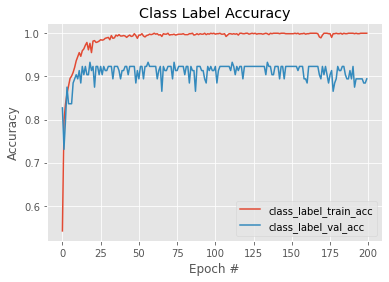

In [33]:
# plotting the class label accuracies during model training
N = np.arange(0, 200) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["class_label_accuracy"],
label="class_label_train_acc")
plt.plot(N, model.history["val_class_label_accuracy"],
label="class_label_val_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom15_training_label_accuracy');

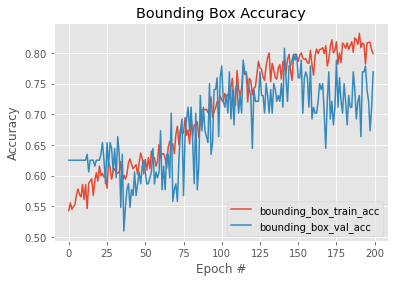

In [34]:
# plotting the bounding box accuracies during model training
N = np.arange(0, 200) #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(N, model.history["bounding_box_accuracy"],
label="bounding_box_train_acc")
plt.plot(N, model.history["val_bounding_box_accuracy"],
label="bounding_box_val_acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('../Images/Custom15_training_bounding_box_accuracy');